<img src="logos/Icos_cp_Logo_RGB.svg" width="400" align="left"/>
<img src="logos/stilt_logo.png" width="190" align="right"/>

<a id='intro'></a>

# 1. Introduction
In this notebook we present data from [ICOS CP](https://www.icos-cp.eu/)  in conjunction with results of the Stochastic Time-Inverted Lagrangian Transport model - [STILT](http://stilt-model.org/index.php/Main/HomePage). It is possible to run the STILT model and produce new results using the [STILT footprint tool](https://www.icos-cp.eu/footprint-tool), which is available on ICOS CP.
<br>

The notebook is divided in three parts; the first part shows a [data availability table](#data_availability) per data package, the second presents [visualizations of STILT Model Results and ICOS Atmospheric Observations](#stilt_icosAtmObs) and the third part displays STILT [footprint maps](#fp_maps). Some parts is subdivided to sections. Every part or section contains a short description of the output and/or tool to use to produce the output as well as the Python code used for the implementation.

It is possible to navigate to different parts of the notebook using the links at the right side of the notebook code cells.

Type __?__ and the name of a Python function, to view a short description of what that particular function does. 


<br>
<br>

## 1.1 Import Python Modules

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;}

<IPython.core.display.Javascript object>

In [2]:
#Import modules:
import numpy as np
from numpy import nan
import pandas as pd
import pickle
import zipfile
import netCDF4 as cdf
import datetime as dt
from datetime import datetime
import requests
import fnmatch
import os
from itertools import chain
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.markers as markers

from cartopy import config
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature, LAND, COASTLINE
import cartopy.feature as cfeature


from ipywidgets import interact, interact_manual, ColorPicker, Dropdown, SelectMultiple, Checkbox, DatePicker, SelectionRangeSlider
import bokeh.io
from bokeh.io import show, output_notebook

#Set the notebook as the default output location:
bokeh.io.reset_output()
bokeh.io.output_notebook()

import warnings
warnings.filterwarnings('ignore')

Loading BokehJS ...

<a id='data_availability'></a>
<br>
<br>
<br>

# 2. Data Availability
This part presents the data availability of different data packages. More in particular, it presents a table of available STILT model results for ICOS Atmospheric Stations. It should be noted that the content of the table is continuously updated. At present, STILT model results are only available for a subset of the existent ICOS Atmospheric Stations. The table is colorcoded to mark the availability of ICOS Level-1 Atmospheric $CO_2$ Data (pink color) and ICOS Level-2 Atmospheric $CO_2$ Data (blue color). A legend with the marker symbols for every data category can be found below the table. 

An interactive map is also provided, depicting the location of all ICOS Atmospheric Stations. Hover with your mouse over the station locations and get more information about every station (e.g. station name, station PI, station country, station longitude, station latitude, availability of ICOS Level-1 $CO_2$ data, availability of ICOS Level-2 $CO_2$ data, etc.). Click on the station and be redirected to the corresponding station landing page o ICOS CP. From there it is possible to view and download available data.

<br>
<br>
<div style="text-align: right"> 
    <a href="#intro">Back to top</a>
</div>

## 2.1 Data Availability --- > Python Code
This section contains the Python code used to implement the ICOS-STILT Data Availability table. 
<br>
<div style="text-align: right"> 
    <a href="#data_availability_table">Go to table</a>
</div>

In [3]:
#Function that takes one parameter as input,
#checks if it can be converted to an integer and
#returns True or False correspondingly:
def is_int(var):
    
    #Define and initialize control value:
    check = True
    
    #Check if input-value can be converted to an integer:
    try:
        val = int(var)
    
    #If input-value can not be converted to an integer:
    except ValueError:
        
        #Set control value to "False":
        check = False
    
    #Return control value:
    return check

In [4]:
def createDatetimeObjList(df_data):

    """
    Project:         'ICOS Carbon Portal'
    Created:          Mon Nov 05 10:27:00 2019
    Last Changed:     Mon Nov 05 10:27:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Add a column with datetime objects to the input dataframe. The datetime objects are created 
                      based on the content of the 'Year', 'Month', 'Day', 'Hour' and 'Minute' columns of every row.
    Input parameters: ICOS data pandas dataframe (Atmospheric Level-1 or Level-2 Data)
    Output:           pandas dataframe
                      columns: 
                            1.  Station 3-character Code (var_name: 'Site', var_type: String)
                            2.  Sampling Height (var_name: 'SamplingHeight', var_type: String)
                            3.  Sampling Year (var_name: 'Year', var_type: String)
                            4.  Sampling Month (var_name: 'Month', var_type: String)
                            5.  Sampling Day (var_name: 'Day', var_type: String)
                            6.  Sampling Hour (var_name: 'Hour', var_type: String)
                            7.  Sampling Minute (var_name: 'Minute', var_type: String)
                            8.  Sampling Decimal Date (var_name: 'DecimalDate', var_type: String)
                            9.  Tracer/Gas concentration (var_name: 'ch4' or 'co2' or 'co', var_type: String)
                            10. Standard Deviation (var_name: 'Stdev', var_type: String)
                            11. Number of Points used for the measurement(var_name: 'NbPoints', var_type: String)
                            12. Quality Flag (var_name: 'Flag', var_type: String)
                            13. Instrument ID (var_name: 'InstrumentId', var_type: String)
                            14. Quality ID (var_name: 'QualityId', var_type: String)
                            15. Internal Flag: only for Level-1 data
                                (var_name: 'InternalFlag', var_type: String)
                            15. LTR: only for Level-2 data (var_name: 'LTR', var_type: String)
                            16. Auto-Descriptive Flag: only for Level-1 data
                                (var_name: 'AutoDescriptiveFlag', var_type: String)
                            16. CMR: only for Level-2 data (var_name: 'CMR', var_type: String)
                            17. Manual-Descriptive Flag: only for Level-1 data
                                (var_name: 'ManualDescriptiveFlag', var_type: String)
                            17: STTB: only for Level-2 data (var_name: 'STTB', var_type: String)
                            18: Datetime object (var_name: 'DateTime', var_type: Stri)
                            
    """
    
    #Add a column with datetime obj:
    df_data['DateTime'] = [datetime.strptime((df_data['Year'][i]+"-"+
                                              df_data['Month'][i]+"-"+
                                              df_data['Day'][i]+" "+
                                              df_data['Hour'][i] +":"+
                                              df_data['Minute'][i]),'%Y-%m-%d %H:%M')
                           for i in range(len(df_data))]
    
    
    
    #Return dataframe:
    return df_data

In [5]:
def get_coords_icos_stations_atc():
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Thur Mar 28 17:27:00 2019
    Last Changed:     Thur Mar 28 17:27:00 2019
    Version:          1.0.0
    Author(s):        Karolina, Oleg, Claudio
    
    Description:      Download ICOS station metadata from ICOS CP with a SPARQL-query.
    Input parameters: No input parameter/s
    Output:           pandas dataframe
                      columns: 
                            1. URL to station landing page (var_name: 'station', var_type: String)
                            2. Name of station PI (var_name: 'PI_names', var_type: String)
                            3. Station name (var_name: 'stationName', var_type: String)
                            4. 3-character Station ID (var_name: 'stationId', var_type: String)
                            5. 2-character Country (var_name: 'Country', var_type: String)
                            6. Station Latitude (var_name: 'lat', var_type: String)
                            7. Station Longitude (var_name: 'lon', var_type: String)

    """
    
    #import modules:
    import requests
    
    #Define URL:
    url = 'https://meta.icos-cp.eu/sparql'
    
    #Define sparQL-query:
    query = """
        prefix cpmeta: <http://meta.icos-cp.eu/ontologies/cpmeta/>
        select *
        from <http://meta.icos-cp.eu/resources/icos/>
        where{
        {
        select ?station (GROUP_CONCAT(?piLname; separator=";") AS ?PI_names)
        where{
          ?station a cpmeta:AS .
          ?pi cpmeta:hasMembership ?piMemb .
          ?piMemb cpmeta:atOrganization ?station  .
           ?piMemb cpmeta:hasRole <http://meta.icos-cp.eu/resources/roles/PI> .
           filter not exists {?piMemb cpmeta:hasEndTime []}
           ?pi cpmeta:hasLastName ?piLname .
        }
        group by ?station
        }
        ?station a cpmeta:AS .
        ?station cpmeta:hasName ?stationName ;
           cpmeta:hasStationId ?stationId ;
           cpmeta:countryCode ?Country ;
           cpmeta:hasLatitude ?lat ;
           cpmeta:hasLongitude ?lon .
        }
        order by ?Short_name
    """
    
    #Send request:
    r = requests.get(url, params = {'format': 'json', 'query': query})
    
    #Get response as json:
    data = r.json()
    
    #Convert the the response into a table.
    #Output is an array, where each row contains information about the station:
    data_ls = [[data['results']['bindings'][row].get(col, {}).get('value')
                for col in data['head']['vars']]
               for row in range(len(data['results']['bindings']))]

    #Create a pandas dataframe from the list:
    df = pd.DataFrame(data_ls, columns=data['head']['vars'])
    
    #Return dataframe:
    return df

In [6]:
def get_icos_stations_atc_L1():

    """
    Project:         'ICOS Carbon Portal'
    Created:          Thu Mar 28 17:27:00 2019
    Last Changed:     Tue Apr 01 09:20:00 2019
    Version:          1.1.0
    Author(s):        Karolina, Oleg, Claudio
    
    Description:      Download ICOS station names for all L1 gases from ICOS CP with a SPARQL-query.
    Input parameters: No input parameter/s
    Output:           Pandas Dataframe
                      columns: 
                            1. URL to ICOS RI Data Object Landing Page (var_name: 'dobj', var_type: String)
                            2. Filename for Data Object (var_name: 'filename', var_type: String)
                            3. Name of gas (var_name: 'variable', var_type: String)
                            4. Station name (var_name: 'stationName', var_type: String)
                            5. Sampling height a.g.l. (var_name: 'height', var_type: String)
                            6. Sampling Start Time (var_name: 'timeStart', var_type: String)
                            7. Sampling End Time (var_naem: 'timeEnd', var_type: String)

    """
    
    
    url = 'https://meta.icos-cp.eu/sparql'
    
    query = """
        prefix cpres: <http://meta.icos-cp.eu/resources/cpmeta/>
        prefix cpmeta: <http://meta.icos-cp.eu/ontologies/cpmeta/>
        prefix prov: <http://www.w3.org/ns/prov#>
        select ?dobj ?fileName ?variable ?stationName ?height ?timeStart ?timeEnd #?stationId
        where{
           values ?vtype { cpres:co2MixingRatio cpres:coMixingRatioPpb cpres:ch4MixingRatioPpb}
           #values ?spec {cpres:atcCo2NrtGrowingDataObject cpres:atcCoNrtGrowingDataObject cpres:atcCh4NrtGrowingDataObject}
           ?vtype rdfs:label ?variable .
           ?col cpmeta:hasValueType ?vtype .
           ?dset cpmeta:hasColumn ?col .
           ?spec cpmeta:containsDataset ?dset .
           ?spec cpmeta:hasAssociatedProject <http://meta.icos-cp.eu/resources/projects/icos> .
           ?spec cpmeta:hasDataLevel "1"^^xsd:integer .
           ?dobj cpmeta:hasObjectSpec ?spec .
           ?dobj cpmeta:hasName ?fileName .
           ?dobj cpmeta:hasSizeInBytes ?fileSize .
           filter not exists {[] cpmeta:isNextVersionOf ?dobj}
           ?dobj cpmeta:wasAcquiredBy [
              #prov:wasAssociatedWith/cpmeta:hasStationId ?stationId ;
              prov:startedAtTime ?timeStart ;
              prov:endedAtTime ?timeEnd ;
              prov:wasAssociatedWith/cpmeta:hasName ?stationName ;
              cpmeta:hasSamplingHeight ?height
            ]
        }
        order by ?variable ?stationName ?height
    """

    r = requests.get(url, params = {'format': 'json', 'query': query})
    data = r.json()

    #Convert the the result into a table
    # output is an array, where each row contains 
    # information about the station:
    data_ls = [[data['results']['bindings'][row].get(col, {}).get('value')
                for col in data['head']['vars']]
               for row in range(len(data['results']['bindings']))]

    #Create a pandas dataframe from the list:
    df = pd.DataFrame(data_ls, columns=data['head']['vars'])

    #Return dataframe:
    return df

In [7]:
def create_lookup_df_atc_L1():
    
    """
    Project:     'ICOS Carbon Portal'
    Created:      Wed Mar 28 17:40:00 2019
    Last Changed: Tue Apr 01 10:00:00 2019
    Version:      1.1.0
    Author(s):    Karolina
    
    Description:  Return a pandas dataframe with information for all available ICOS Level-1 Atmospheric Data Files.
    Input:        No input parameter/s  
    Output:       pandas dataframe
                  columns:
                      1. URL to ICOS RI Data Object Landing Page (var_name: 'dobj', var_type: String)
                      2. Filename for Data Object (var_name: 'filename', var_type: String)
                      3. Name of gas/tracer (var_name: 'variable', var_type: String)
                      4. Station name (var_name: 'stationName', var_type: String)
                      5. Sampling height a.g.l. (var_name: 'height', var_type: String)
                      6. Sampling start time (var_name:'timeStart', var_type: String)
                      7. Sampling end time (var_name: 'timeEnd', var_type: String)
                      8. 3-character Station ID (var_name: 'stationId', var_type: String)
    """
    
    #Get ICOS-stations with level-1 gas-data:
    icos_stations_L1_gas_df = get_icos_stations_atc_L1()
    
    #Get ICOS-station info:
    station_info_df = get_coords_icos_stations_atc()
    
    #Create lookup dataframe:
    lookup_df = icos_stations_L1_gas_df.join(station_info_df.filter(['stationName',
                                                                     'stationId']).set_index('stationName'),
                                             on='stationName')
    
    #Return dataframe:
    return lookup_df

In [8]:
def get_icos_stations_atc_L2():

    """
    Project:         'ICOS Carbon Portal'
    Created:          Thu Mar 28 17:27:00 2019
    Last Changed:     Tue Apr 30 17:27:00 2019
    Version:          1.1.0
    Author(s):        Karolina, Oleg, Claudio
    
    Description:      Download ICOS station names for all L2 gases from ICOS CP with a SPARQL-query.
    Input parameters: No input parameter/s
    Output:           pandas dataframe
                      columns: 
                            1. URL to ICOS RI Data Object Landing Page (var_name: 'dobj', var_type: String)
                            2. Filename for Data Object (var_name: 'filename', var_type: String)
                            3. Name of gas (var_name: 'variable', var_type: String)
                            4. Station name (var_name: 'stationName', var_type: String)
                            5. Sampling height a.g.l. (var_name: 'height', var_type: String)
                            6. Sampling Start Time (var_name: "timeStart", var_type: Datetime Object)
                            7. Sampling End Time (var_name: "timeEnd", var_type: Datetime Object)

    """
    
    
    url = 'https://meta.icos-cp.eu/sparql'
    
    query = """
        prefix cpres: <http://meta.icos-cp.eu/resources/cpmeta/>
        prefix cpmeta: <http://meta.icos-cp.eu/ontologies/cpmeta/>
        prefix prov: <http://www.w3.org/ns/prov#>
        select ?dobj ?fileName ?variable ?stationName ?height ?timeStart ?timeEnd #?stationId
        where{
           values ?vtype {cpres:coMixingRatioPpb cpres:ch4MixingRatioPpb cpres:co2MixingRatio }
           #values ?spec {cpres:atcCo2L2DataObject cpres:atcCoL2DataObject cpres:atcCh4L2DataObject}
           ?vtype rdfs:label ?variable .
           ?col cpmeta:hasValueType ?vtype .
           ?dset cpmeta:hasColumn ?col .
           ?spec cpmeta:containsDataset ?dset .
           ?spec cpmeta:hasAssociatedProject <http://meta.icos-cp.eu/resources/projects/icos> .
           ?spec cpmeta:hasDataLevel "2"^^xsd:integer .
           ?dobj cpmeta:hasObjectSpec ?spec .
           ?dobj cpmeta:hasName ?fileName .
           filter not exists {[] cpmeta:isNextVersionOf ?dobj}
           ?dobj cpmeta:wasAcquiredBy [
              #prov:wasAssociatedWith/cpmeta:hasStationId ?stationId ;
              prov:startedAtTime ?timeStart ;
              prov:endedAtTime ?timeEnd ;
              prov:wasAssociatedWith/cpmeta:hasName ?stationName ;
              cpmeta:hasSamplingHeight ?height
            ]
        }
        order by ?variable ?stationName ?height
    """

    r = requests.get(url, params = {'format': 'json', 'query': query})
    data = r.json()

    #Convert the the result into a table
    # output is an array, where each row contains 
    # information about the station
    data_ls = [[data['results']['bindings'][row].get(col, {}).get('value')
                for col in data['head']['vars']]
               for row in range(len(data['results']['bindings']))]

    #Create a pandas dataframe from the list:
    df = pd.DataFrame(data_ls, columns=data['head']['vars'])

    #Return dataframe:
    return df

In [9]:
def create_lookup_df_atc_L2():
    
    """
    Project:     'ICOS Carbon Portal'
    Created:      Wed Apr 01 10:00:00 2019
    Last Changed: Wed Apr 01 10:00:00 2019
    Version:      1.0.0
    Author(s):    Karolina
    
    Description:  Return a pandas dataframe with information for all available ICOS Level-2 Atmospheric Data Files.
    Input:        No input parameter/s  
    Output:       pandas dataframe
                  columns:
                      1. URL to ICOS RI Data Object Landing Page (var_name: 'dobj', var_type: String)
                      2. Filename for Data Object (var_name: 'filename', var_type: String)
                      3. Name of gas/tracer (var_name: 'variable', var_type: String)
                      4. Station name (var_name: 'stationName', var_type: String)
                      5. Sampling height a.g.l. (var_name: 'height', var_type: String)
                      6. Sampling start time (var_name:'timeStart', var_type: String)
                      7. Sampling end time (var_name: 'timeEnd', var_type: String)
                      8. 3-character Station ID (var_name: 'stationId', var_type: String)
    """
    
    #Get ICOS-stations with level-1 gas-data:
    icos_stations_L2_gas_df = get_icos_stations_atc_L2()
    
    #Get ICOS-station info:
    station_info_df = get_coords_icos_stations_atc()
    
    #Create lookup dataframe:
    lookup_df = icos_stations_L2_gas_df.join(station_info_df.filter(['stationName',
                                                                     'stationId']).set_index('stationName'),
                                             on='stationName')
    
    #Return dataframe:
    return lookup_df

In [10]:
def get_icos_citation(dataObject):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Fri May 10 12:35:00 2019
    Last Changed:     Fri May 10 12:35:00 2019
    Version:          1.0.0
    Author(s):        Oleg, Karolina
    
    Description:      Function that takes a string variable representing the data object URL as input and
                      returns a string with the citation for the corresponding data object. The data object
                      is a unique identifier of every separate ICOS dataset.
    
    Input parameters: Data Object ID (var_name: "dataObject", var_type: String)
    
    Output:           Citation (var_type: String)

    """
    
    #Define URL:
    url = 'https://meta.icos-cp.eu/sparql'
    
    #Define SPARQL-query to get the citation for the given data object id:
    query = """
        prefix cpmeta: <http://meta.icos-cp.eu/ontologies/cpmeta/>
        select * where{
        optional{<"""+dataObject+"""> cpmeta:hasCitationString ?cit}}
    """
    
    #Send request with the defined SPARQL-query & set the response format to JSON:
    r = requests.get(url, params = {'format': 'json', 'query': query})
    
    #Get the response as JSON:
    data = r.json()

    #Convert the JSON repsonse into a list
    # output is an array, where each row contains 
    # information about the station
    data_ls = [[data['results']['bindings'][row].get(col, {}).get('value')
                for col in data['head']['vars']]
               for row in range(len(data['results']['bindings']))]

    #Create a pandas dataframe from the list:
    df = pd.DataFrame(data_ls, columns=data['head']['vars'])

    #Return dataframe:
    return df
    

In [11]:
def printmd(string):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Fri May 10 12:00:00 2019
    Last Changed:     Fri May 10 12:00:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that allows you to print the string input parameter using
                      markdown formatting code.
                      
    Input parameters: String of characters
                      (var_name: 'string', var_type: String)

    Output:           String     
    
    """
    
    #import module:
    from IPython.display import Markdown, display
    
    #Enable displaying string with markdown code:
    display(Markdown(string))

In [12]:
def changeprojection(inprojection, outprojection, dataset_df, longitude_col_name, latitude_col_name):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Fri Apr 04 09:30:00 2019
    Last Changed:     Fri Apr 04 09:30:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that changes the projection of x- and y-coordinates stored in a pandas dataframe. 
                      The function takes 5 input parameters (input projection, output projection, dataframe,
                      column name for longitude data, column name for latitude data), and adds to the existing
                      dataframe two new columns containing the reprojected x- and y-coordinates correspondigly. 
                      
    Input parameters: 1. Projection of Input Coordinates (var_name: 'inprojection', var_type: String)
                      2. Projection of Output Coordinates (var_name: 'outprojection', var_type: String)
                      3. Dataframe Containing Coordinates (var_name: 'dataset_df', var_type: Pandas Dataframe)
                      4. Column Name of Input Longitude Coordinates (var_name: 'longitude_col_name', var_type: String)
                      5. Column Name of Input Latitude Coordinates (var_name: 'latitude_col_name', var_type: String)

    Output:           pandas dataframe (with 2 new additonal columns; proj_x, proj_y)
    
    """
    
    #Import Python projection modules:
    from pyproj import Proj, transform
    
    #Reproject coordinates of point data.
    #Store the tuples containing the reprojected coordinates as a column to a list:
    proj_coords = [transform(Proj(init=inprojection),
                             Proj(init=outprojection),
                             dataset_df['lon'].iloc[i],
                             dataset_df['lat'].iloc[i])
                   for i in range(len(dataset_df))]
    
    #Set the labels for the projected coordinate columns:
    labels = ['proj_x','proj_y']
    
    #Create a pandas dataframe from the list of reprojected coordinates:
    coords_df = pd.DataFrame.from_records(proj_coords,columns =labels)
    
    #Add the columns with the projected coordinates to the initial pandas dataframe:
    dataset_df[coords_df.columns] = coords_df
    
    #Return dataframe containing reprojected coordinates:
    return dataset_df

In [13]:
def rounddown_100(x):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Tue May 07 09:00:00 2018
    Last Changed:     Tue May 07 09:00:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that takes a number as input and floors it to the nearest "100".
                      
    Input parameters: Number (var_name: 'x', var_type: Integer or Float)

    Output:           Float
    
    """
    
    #Import module:
    import numbers
    
    #Check if input parameter is numeric:
    if(isinstance(x, numbers.Number)==True):

        #If the number is an integral multiple of 100:
        if(((x/100.0)%2==0) or (x<=0) or (x==100)):

            return(int(x / 100.0) * 100) - 100
        
        #If the input number is NOT an integral multiple of 100:
        else:

            return(int(x / 100.0) * 100)

    #If input parameter is not numeric, prompt an error message:
    else:
        print("Input parameter is not numeric!")

In [14]:
def roundup_100(x):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Tue May 07 09:00:00 2018
    Last Changed:     Tue May 07 09:00:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that takes a number as input and rounds it up to the nearest "100".
                      
    Input parameters: Number (var_name: 'x', var_type: Integer or Float)

    Output:           Float
    
    """
    
    #Import modules:
    import math
    import numbers
    
    #Check if input parameter is numeric:
    if(isinstance(x, numbers.Number)==True):
        
        #for integral mulitples of 100 and for the special cases of 100, 0 and -100:
        if(((x/100.0)%2==0) or (x==100) or (x==-100)):  
            return int(math.ceil(x / 100.0)) * 100 + 100

        else:
            return int(math.ceil(x / 100.0)) * 100
    
    #If input parameter is not numeric, prompt an error message:
    else:
        print("Input parameter is not numeric!")
    

In [15]:
def rounddown_20(x):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Tue May 07 09:00:00 2018
    Last Changed:     Tue May 07 09:00:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that takes a number as input and floors it to the nearest "20".
                      
    Input parameters: Number (var_name: 'x', var_type: Integer or Float)

    Output:           Float
    
    """
    
    #Import module:
    import math
    import numbers
    
    #Check if input parameter is numeric:
    if(isinstance(x, numbers.Number)==True):
    
        #If the 2nd digit from the decimal point is an even number:
        if(int(x/10.0)%2==0):

            return(int(x / 10.0) * 10) - 20

        #If the 2nd digit from the decimal point is an odd number:
        else:

            return(int(x / 10.0) * 10) - 10
        
    #If input parameter is not numeric, prompt an error message:
    else:
        print("Input parameter is not numeric!")

In [16]:
def roundup_20(x):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Tue May 07 09:00:00 2018
    Last Changed:     Tue May 07 09:00:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that takes a number as input and rounds it up to the closest "20".
                      
    Input parameters: Number (var_name: 'x', var_type: Integer or Float)

    Output:           Float
    
    """
    
    #Import module:
    import math
    import numbers
    
    #Check if input parameter is numeric:
    if(isinstance(x, numbers.Number)==True):
    
        #for positive numbers, multiples of 20.0:
        if((x>=0)&(((x/10.0)%20)%2 == 0)):  
            return int(math.ceil(x / 10.0)) * 10 +20

        #for positive numbers with an even number as 2nd digit:
        elif((x>0)&(int(x/10.0)%2==0)):
            return int(math.ceil(x / 10.0)) * 10 +10

        #for positive and negative numbers, whose 2nd digit is an odd number (except for i in [-1,-9]):
        elif(int(x/10.0)%2!=0):
            return int((x / 10.0)) * 10 +10

        #for negative numbers, whose 1st or 2nd digit is an even number:
        elif((x<-10) & (int(x)%2==0)):   
            return int((x / 10.0)) * 10 +20

        else:
            return 0
    
    #If input parameter is NOT numeric, prompt an error message:
    else:
        print("Input parameter is not numeric!")
    

In [17]:
def roundup_10(x):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Tue May 07 10:30:00 2018
    Last Changed:     Tue May 07 10:30:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that takes a number as input and rounds it up to the closest "10".
                      
    Input parameters: Number (var_name: 'x', var_type: Integer or Float)

    Output:           Float
    
    """
    
    #import module:
    import math
    import numbers
    
    #Check if input parameter is numeric:
    if(isinstance(x, numbers.Number)==True):
    
        #Return rounded value:
        return int(math.ceil(x / 10.0)) * 10
    
    #If input parameter is NOT numeric, prompt an error message:
    else:
        print("Input parameter is not numeric!")

In [18]:
def rounddown_10(x):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Tue May 07 10:30:00 2018
    Last Changed:     Tue May 07 10:30:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that takes a number as input and floors it down to the closest "10".
                      
    Input parameters: Number (var_name: 'x', var_type: Integer or Float)

    Output:           Float
    
    """
    
    #import module:
    import math
    import numbers
    
    #Check if input parameter is numeric:
    if(isinstance(x, numbers.Number)==True):
    
        #Return rounded value:
        return int(math.ceil(x / 10.0)) * 10 -10
    
    #If input parameter is NOT numeric, prompt an error message:
    else:
        print("Input parameter is not numeric!")

In [19]:
def set_yranges_2y(y1_min, y1_max, y2_min, y2_max, y1_step, y2_step ,new_yrange_name):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Tue May 07 10:30:00 2018
    Last Changed:     Tue May 07 10:30:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that takes the primary and secondary y-axis min/max values as well as
                      the step values for every y-axis and the secondary y-axis new range name as input
                      parameters, performs computations so that the two axes are alligned and returns
                      their corresponding RangeId objects. Works only for Bokeh plots.
                      
    Input parameters: 1. Min value of primary y-axis (var_name: 'y1_min', var_type: Integer or Float)
                      2. Max value of primary y-axis (var_name: 'y1_max', var_type: Integer or Float)
                      3. Min value of secondary y-axis (var_name: 'y2_min', var_type: Integer or Float)
                      4. Max value of secondary y-axis (var_name: 'y2_max', var_type: Integer or Float)
                      5. Step of primary y-axis (var_name: 'y1_step', var_type: Integer or Float)
                      6. Step of primary y-axis (var_name: 'y2_step', var_type: Integer or Float)
                      7. Name of new yrange object for secondary y-axis
                         (var_name: "new_yrange_name", var_type: Bokeh Plot yrange object)

    Output:           Bokeh Plot yrange objects for primary and secondary y-axes.
    
    """
    
    #import modules:
    import numpy as np
    from bokeh.models import Range1d
          
    #yrange and tick function for plot with primary and secondary y-axis:
    yticks1 = np.arange(y1_min, y1_max + y1_step, y1_step)
    yticks2 = np.arange(y2_min, y2_max + y2_step, y2_step)

    #Get difference in total number of ticks between primary and secondary y-axis:  
    diff = abs(len(yticks2)-len(yticks1))

    #Get how many times the step needs to be added to start and end:
    num_of_steps = int(diff/2)
    
    #If the primary and the secondary y-axis have the same number of ticks:
    if(diff==0):

        #Set the range of the 1st y-axis:
        y_range = Range1d(start=y1_min, end=y1_max)

        #Set the 2nd y-axis, range-name, range:
        extra_y_ranges = {new_yrange_name: Range1d(start=y2_min, end=y2_max)}

        
    #If the primary y-axis has fewer ticks than the secondary y-axis:    
    elif(len(yticks2)>len(yticks1)):
    
        #If the difference in ticks between the two axes is an odd number:
        if(diff%2==1):

            #Set the range of the 1st y-axis:
            y_range = Range1d(start=y1_min-(y1_step*(num_of_steps+1)), end=y1_max+(y1_step*num_of_steps))

            #Set the 2nd y-axis, range-name, range:
            extra_y_ranges = {new_yrange_name: Range1d(start=y2_min, end=y2_max)}

        #If the difference in ticks between the two axes is an even number:
        else:
            #Set the range of the 1st y-axis:
            y_range = Range1d(start=y1_min-(y1_step*num_of_steps), end=y1_max+(y1_step*num_of_steps))

            #Set the 2nd y-axis, range-name, range:
            extra_y_ranges = {new_yrange_name: Range1d(start=y2_min, end=y2_max)}
            
            
    #If the primary y-axis has more ticks than the secondary y-axis, e.g. len(yticks1)>len(yticks2_test):
    else:
        
        #If the difference in ticks between the two axes is an odd number:
        if(diff%2==1):
            
            #Set the range of the 1st y-axis:
            y_range = Range1d(start=y1_min, end=y1_max)

            #Set the 2nd y-axis, range-name, range:
            extra_y_ranges = {new_yrange_name: Range1d(start=y2_min - (y2_step*(num_of_steps)), end=y2_max + (y2_step*(num_of_steps+1)))}

        #If the difference in ticks between the two axes is an even number:
        else:
            #Set the range of the 1st y-axis:
            y_range = Range1d(start=y1_min, end=y1_max)

            #Set the 2nd y-axis, range-name, range:
            extra_y_ranges = {new_yrange_name: Range1d(start=y2_min - (y2_step*num_of_steps), end=y2_max + (y2_step*num_of_steps))}
              
        
    #Return y-range for primary and secondary y-axes:
    return y_range, extra_y_ranges


In [20]:
#################################################### NEW FUNCTIONS ###################################################

In [21]:
def get_stilt_stationID_samplHeight(stiltStatInfo):
   
    """
    Project:         'ICOS Carbon Portal'
    Created:          Thu Apr 25 09:10:00 2019
    Last Changed:     Thu Apr 25 09:10:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that takes a string as input representing the STILT station ID (e.g. 'CES050').
                      The function discards the first 3 chatacters in the string 
                      (representing the station code) and checks the remaining part of the string; if the
                      remaining part contains digits, it converts the string to float and returns the 
                      sampling height as a numeric value, otherwise it returns an empty string.
                      
    Input parameters: STILT station ID (var_name: 'stiltStatInfo', var_type: String)

    Output:           Sampling Height (var_type: Float or String)
    
    """
    
    if(stiltStatInfo[3:len(stiltStatInfo)].isdigit()):
        stSH = str(float(stiltStatInfo[3:len(stiltStatInfo)]))
        return stSH
        
    else:
        return ''
    

In [22]:
def get_stilt_stations_df(pathStations):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Fri Apr 26 09:00:00 2019
    Last Changed:     Fri Apr 26 09:00:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that takes a string as input representing the path to the STILT station directories.
                      The function return discards the first 3 chatacters in the string 
                      (representing the station code) and checks the remaining part of the string; if the
                      remaining part contains digits, it converts the string to float and returns the 
                      sampling height as a numeric value, otherwise it returns an empty string.
                      
    Input parameters: Path to STILT output directory (var_name: 'pathStations', var_type: String)

    Output:           Pandas Dataframe
    
                      Columns: 
                      STILT station ID (var_name: 'stiltStationId', var_type: String)
                      Sampling Height (var_name: 'stiltSamplingHeight', var_type: String)
    
    """
    #Check if directory exists:
    if os.path.exists(pathStations):
        #Get a list of stations for existing STILT-runs:
        allStations = os.listdir(pathStations)

        #Get a list of tuples with unique occurances of station ID and sampling height:
        stiltStId = list(set([(allStations[i][0:3], get_stilt_stationID_samplHeight(allStations[i]))
                     for i in range(len(allStations))]))

        #Convert the list of tuples to a pandas dataframe:
        stilt_stationID_df = pd.DataFrame(stiltStId, columns=['stiltStationId', 'stiltSamplingHeight'])
    
    else:
        print ('Directory '+pathStations+ ' does not exist!')
        
    #Return dataframe:
    return stilt_stationID_df

In [23]:
def create_sampHeight_for_STILT_StationID(icos_stationId, stilt_sampHeight):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Tue Apr 30 09:00:00 2019
    Last Changed:     Tue Apr 30 09:00:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that takes two strings as input representing the ICOS station ID and 
                      STILT station sampling height.
                      The function creates the corresponding STILT station ID by putting together the
                      ICOS station ID and STILT station sampling height. ICOS stations that only have
                      measuring instruments at one sampling height have no sampling height information
                      in their STILT station ID. Stations with a sampling height lower than 100, have a
                      '0' digit between their 3-character station code and sampling height.
                      
    Input parameters: 1. ICOS station ID
                         (var_name: 'icos_stationId', var_type: String)
                      2. STILT station sampling height expressed as meters above ground level
                         (var_name: 'stilt_sampHeight', var_type: String)

    Output:           STILT Station ID (var_type: String)
    
    """
    
    #Get STILT station sampling height:
    stilt_sh = stilt_sampHeight.split('.',1)[0]

    #Get STILT station ID:
    if((len(stilt_sh)<3) & (stilt_sh!='')):
        stilt_id = icos_stationId + '0' + stilt_sh
    else:
        stilt_id = icos_stationId + stilt_sh
        
    #return STILT Station ID:
    return stilt_id

In [24]:
def get_df_for_stilt_icos_stations(pathStations):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Tue Apr 30 09:30:00 2019
    Last Changed:     Tue Apr 30 09:30:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that takes a string representing the path to the directory where all STILT results are stored
                      and returns a dataframe with info for all ICOS Atmospheric Stations for which results of STILT-runs
                      are available.
                      
    Input parameters: Path to STILT output directory (var_name: 'pathStations', var_type: String)

    Output:           Pandas Dataframe
                    
                      Columns:
                            1. STILT station ID (var_name: 'stiltStationId', var_type: String)
                            2. ICOS 3-character station ID (var_name: 'stationId', var_type: String)
                            3. URL to station landing page (var_name: 'station', var_type: String)
                            4. Name of station PI (var_name: 'PI_names', var_type: String)
                            5. Station name (var_name: 'stationName', var_type: String
                            6. 2-character Country (var_name: 'Country', var_type: String)
                            7. Station Latitude (var_name: 'lat', var_type: String)
                            8. Station Longitude (var_name: 'lon', var_type: String)
                            9. STILT sampling height (var_name: 'stiltSamplingHeight', var_type: String)
    
    """
    
    #Get a dataframe contianing info for all ICOS Atmospheric Stations:
    icos_AS_df = get_coords_icos_stations_atc()

    #Get a list of stations for existing STILT model runs:
    stilt_stationID_df = get_stilt_stations_df(pathStations)

    #Get all STILT model run stations that have been executed for ICOS Atmospheric Stations:
    stilt_icos_stations = icos_AS_df.set_index('stationId').join(stilt_stationID_df.set_index('stiltStationId'))

    #Remove records where "SamplingHeight" is NaN
    #Observe that "SamplingHeight=='' is allowed
    stilt_icos_stations = stilt_icos_stations[stilt_icos_stations.stiltSamplingHeight.notnull()]

    #Add column with STILT station-ID:
    stilt_icos_stations['stiltStationId'] = [create_sampHeight_for_STILT_StationID(stilt_icos_stations.index.values[i],
                                                                                   stilt_icos_stations.stiltSamplingHeight.iloc[i])
                                             for i in range(len(stilt_icos_stations))]

    #Reset index to auto-increment:
    stilt_icos_stations_df = stilt_icos_stations.reset_index()

    #Rename old index-column to 'stationId' ---> representing ICOS station ID:
    stilt_icos_stations_df.rename(columns={'index':'stationId'}, inplace=True)

    #Set STILT-station-ID as index:
    stilt_icos_stations_df.set_index('stiltStationId', inplace=True)

    #Return dataframe:
    return stilt_icos_stations_df

    

    

In [25]:
def get_STILT_ICOS_Lx_availability_list(icos_Lx_stations, stilt_icos_stations):
   
    """
    Project:         'ICOS Carbon Portal'
    Created:          Tue Apr 30 09:30:00 2019
    Last Changed:     Tue Apr 30 09:30:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Creates a list of tuples with the stationID, stationSamplingHeight (if available), a boolean 
                      value indicating the presence or absence of ICOS Level-x Atmospheric CO2-data for a given
                      station, the sampling start time and the sampling end time.
                      
    Input parameters: 1. Station info for ICOS Lx Atmospheric Tracer Data
                         (var_name: "stilt_icos_stations", var_type: Pandas Dataframe)
                      2. ICOS Stations for which STILT Model Results are available for
                         (var_name: "stilt_icos_stations", var_type: Pandas Dataframe)

    Output:           List of tuples
    
    """
    
    
    #Create an empty list to store the tuples:
    ls_Lx=[]

    #Loop through every station:
    for i in range(len(stilt_icos_stations)):

        #Check if the STILT station-ID and the STILT station sampling height are included
        #in the ICOS Level-x Atmospheric Station dataframe: 
        if(((icos_Lx_stations.stationId == stilt_icos_stations.stationId.iloc[i]) &
            (icos_Lx_stations.height == stilt_icos_stations.stiltSamplingHeight.iloc[i])).any()):

            #Append tuple containing:
            #station 3-character code, station sampling height, ICOS L-x CO2-data availability -- > 1 (True),
            #ICOS L-x CO2-data sampling height, start time and end time:
            ls_Lx.append((stilt_icos_stations.stationId.iloc[i],
                          stilt_icos_stations.stiltSamplingHeight.iloc[i],
                          stilt_icos_stations.stiltSamplingHeight.iloc[i],
                          1,
                          datetime.strptime(icos_Lx_stations.timeStart.loc[(icos_Lx_stations.stationId==stilt_icos_stations.stationId.iloc[i]) &
                                                                           (icos_Lx_stations.height==stilt_icos_stations.stiltSamplingHeight.iloc[i])].min(),
                                            '%Y-%m-%dT%H:%M:%SZ'),
                          datetime.strptime(icos_Lx_stations.timeEnd.loc[(icos_Lx_stations.stationId==stilt_icos_stations.stationId.iloc[i]) &
                                                                         (icos_Lx_stations.height==stilt_icos_stations.stiltSamplingHeight.iloc[i])].max(),
                                            '%Y-%m-%dT%H:%M:%SZ')))


        #Check if the STILT station-ID is included in the ICOS Level-x Atmospheric Station dataframe and
        #if the STILT station sampling height is '':         
        elif(((icos_Lx_stations.stationId == stilt_icos_stations.stationId.iloc[i]).any()) &
             (stilt_icos_stations.stiltSamplingHeight.iloc[i]=='')):

            #Append tuple containing:
            #station 3-character code, station sampling height & availability -- > 1 (True),
            #ICOS L-x CO2-data sampling height, start time and end time:
            ls_Lx.append((stilt_icos_stations.stationId.iloc[i],
                          stilt_icos_stations.stiltSamplingHeight.iloc[i],
                          icos_Lx_stations.height.loc[icos_Lx_stations.stationId==stilt_icos_stations.stationId.iloc[i]].values[0],
                          1,
                          datetime.strptime(icos_Lx_stations.timeStart.loc[icos_Lx_stations.stationId==stilt_icos_stations.stationId.iloc[i]].min(),
                                            '%Y-%m-%dT%H:%M:%SZ'),
                          datetime.strptime(icos_Lx_stations.timeEnd.loc[icos_Lx_stations.stationId==stilt_icos_stations.stationId.iloc[i]].max(),
                                            '%Y-%m-%dT%H:%M:%SZ')))


        #Check if the STILT station-ID is included in the ICOS Level-x Atmospheric Station dataframe and
        #if the STILT station sampling height is not eaqual to '':         
        elif(((icos_Lx_stations.stationId == stilt_icos_stations.stationId.iloc[i]).any()) &
             (stilt_icos_stations.stiltSamplingHeight.iloc[i]!='')):

                #Check if the STILT station-ID is included in the ICOS Level-x Atmospheric Station dataframe and
                #if there is a corresponding ICOS station sampling height that falls in the range
                #[STILT-station-sampling-height - 10m, STILT-station-sampling-height + 10m]: 
                if(((icos_Lx_stations.stationId == stilt_icos_stations.stationId.iloc[i]) &
                   (icos_Lx_stations.height.astype('float') >= float(stilt_icos_stations.stiltSamplingHeight.iloc[i])-10.0) &
                   (icos_Lx_stations.height.astype('float') <= float(stilt_icos_stations.stiltSamplingHeight.iloc[i])+10.0)).any()):

                    #Append tuple containing:
                    #station 3-character code, station sampling height & availability -- > 1 (True),
                    #ICOS L-x CO2-data sampling height, start time and end time:
                    ls_Lx.append((stilt_icos_stations.stationId.iloc[i],
                                  stilt_icos_stations.stiltSamplingHeight.iloc[i],
                                  icos_Lx_stations.height[(icos_Lx_stations.stationId == stilt_icos_stations.stationId.iloc[i])&
                                                          (icos_Lx_stations.height.astype('float') >= float(stilt_icos_stations.stiltSamplingHeight.iloc[i])-10.0) &
                                                          (icos_Lx_stations.height.astype('float') <= float(stilt_icos_stations.stiltSamplingHeight.iloc[i])+10.0)].values[0],
                                  1,
                                  datetime.strptime(icos_Lx_stations.timeStart.loc[icos_Lx_stations.stationId==stilt_icos_stations.stationId.iloc[i]].min(),
                                                    '%Y-%m-%dT%H:%M:%SZ'),
                                  datetime.strptime(icos_Lx_stations.timeEnd.loc[icos_Lx_stations.stationId==stilt_icos_stations.stationId.iloc[i]].max(),
                                                    '%Y-%m-%dT%H:%M:%SZ')))

                #If the corresponding ICOS-station-sampling-height does not fall within the range,
                #set the availability to "0" (False) and ICOS L-x CO2-data sampling start time and end time to "None":
                else:
                    ls_Lx.append((stilt_icos_stations.stationId.iloc[i],
                                  stilt_icos_stations.stiltSamplingHeight.iloc[i],
                                  np.nan,
                                  0,
                                  None,
                                  None))

        #If none of the previous conditions are met,
        #set the availability to "0" (False) and ICOS L-x CO2-data sampling start time and end time to "None":
        else:
            ls_Lx.append((stilt_icos_stations.stationId.iloc[i],
                          stilt_icos_stations.stiltSamplingHeight.iloc[i],
                          np.nan,
                          0,
                          None,
                          None))

    #Return list of tuples:
    return ls_Lx

In [26]:
def STILT_get_ICOS_L1_L2_ATM_Station_Availability_df(stilt_icos_stations):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Tue Apr 30 09:30:00 2019
    Last Changed:     Tue Apr 30 09:30:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Creates a dataframe with ICOS stations for which STILT Model results are available for.
                      This dataframe shows ICOS Level-1 & Level-2 Atmospheric Data availability for these stations.
                      
    Input parameters: ICOS Stations for which STILT Model Results are available for
                      (var_name: "stilt_icos_stations", var_type: Pandas Dataframe)

    Output:           Pandas Dataframe
    
                      Columns:
                       1. STILT Station ID (var_name: "stiltStationId", var_type: String)
                       2. ICOS Station ID, 3-character code (var_name: "stationId", var_type: String)
                       3. ICOS Station URL (var_name: "station", var_type: String)
                       4. ICOS Station PI (var_name: "PI_names", var_type: String)
                       5. ICOS Station Long Name (var_name: "stationName", var_type: String)
                       6. ICOS Station Country, 2-character code (var_name: "Country", var_type: string)
                       7. ICOS Station Latitude (var_name: "lat", var_type: String)
                       8. ICOS Station Longitude (var_name: "lon", var_type: String)
                       9. STILT Station Sampling Height (var_name: "stiltSamplingHeight", var_type: String)
                      10. ICOS Station Sampling Height (var_name: "ICOS_SamplHeight", var_type: String)
                      11. ICOS Level-1 CO2 Data Availability - boolean (var_name: "ICOS_L1_AS_CO2", var_type: Integer)
                      12. ICOS Level-1 CO2 Data Availability - boolean (var_name: "ICOS_L2_AS_CO2", var_type: Integer)
                      13. ICOS Level-1 CO2 Data Sampling Start Time
                          (var_name: "ICOS_L1_AS_CO2_Time_Start", var_type: Datetime Object)
                      14. ICOS Level-1 CO2 Data Sampling End Time
                          (var_name: "ICOS_L1_AS_CO2_Time_End", var_type: Datetime Object)
                      15. ICOS Level-2 CO2 Data Sampling Start Time 
                          (var_name: "ICOS_L2_AS_CO2_Time_Start", var_type: Datetime Object)
                      16. ICOS Level-2 CO2 Data Sampling End Time
                          (var_name: "ICOS_L2_AS_CO2_Time_End", var_type: Datetime Object)
                      
    """
    
    #Get dataframe with info for ICOS Level-1 & Level-2 Atmosphere Stations (all-tracers):
    icos_L1_atm_stations = create_lookup_df_atc_L1() #Stations providing ICOS Level-1 Atm. Data
    icos_L2_atm_stations = create_lookup_df_atc_L2() #Stations providing ICOS Level-2 Atm. Data

    #Filter out entries that belong to tracers other than "CO2":
    icos_L1_atm_stations = icos_L1_atm_stations[icos_L1_atm_stations.variable == 'CO2 mixing ratio (dry mole fraction)']
    icos_L2_atm_stations = icos_L2_atm_stations[icos_L2_atm_stations.variable == 'CO2 mixing ratio (dry mole fraction)']
    
    #Get list of tuples indincating the ICOS Level-1 Atmospheric data availability for every STILT station:
    ls_L1 = get_STILT_ICOS_Lx_availability_list(icos_L1_atm_stations, stilt_icos_stations)
    
    #Get list of tuples indincating the ICOS Level-2 Atmospheric data availability for every STILT station:
    ls_L2 = get_STILT_ICOS_Lx_availability_list(icos_L2_atm_stations, stilt_icos_stations)
    
    #Add column with ICOS Station sampling height:
    stilt_icos_stations['ICOS_SamplHeight']= [ls_L1[i][2] for i in range(len(ls_L1))]
    
    #Add column with ICOS Level-1 CO2-data availability per station:
    stilt_icos_stations['ICOS_L1_AS_CO2']= [ls_L1[i][3] for i in range(len(ls_L1))]
    
    #Add column with ICOS Level-2 CO2-data availability per station:
    stilt_icos_stations['ICOS_L2_AS_CO2']= [ls_L2[i][3] for i in range(len(ls_L2))]
    
    #Add columns with time information regarding ICOS Level-1 CO2-data availability per station:
    stilt_icos_stations['ICOS_L1_AS_CO2_Time_Start']= [ls_L1[i][4] for i in range(len(ls_L1))]
    stilt_icos_stations['ICOS_L1_AS_CO2_Time_End']= [ls_L1[i][5] for i in range(len(ls_L1))]
    
    #Add columns with time information regarding ICOS Level-2 CO2-data availability per station:
    stilt_icos_stations['ICOS_L2_AS_CO2_Time_Start']= [ls_L2[i][4] for i in range(len(ls_L2))]
    stilt_icos_stations['ICOS_L2_AS_CO2_Time_End']= [ls_L2[i][5] for i in range(len(ls_L2))]
    
    #Return dataframe with STILT-ICOS stations showing ICOS Level-1 & Level-2 Atmospheric Data availability:
    return stilt_icos_stations

In [27]:
def get_nmonths_per_year_Lx_availability(stiltStationID, timeStartMonth, timeStartYear, timeEndMonth, timeEndYear):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Tue Apr 30 09:30:00 2019
    Last Changed:     Tue Apr 30 09:30:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that returns a list of tuples with STILT station ID, year and number of months 
                      for which icos Level-x data are available for.
                      
    Input parameters: 1. STILT Station ID (var_name: "stiltStationID", var_type: String)
                      2. Month of Station Sampling Start Date (var_name: "timeStartMonth", var_type: Integer)
                      3. Year of Station Sampling Start Date (var_name: "timeStartYear", var_type: Integer)
                      4. Month of Station Sampling End Date (var_name: "timeEndtMonth", var_type: Integer)
                      5. Year of Station Sampling End Date (var_name: "timeEndYear", var_type: Integer)

    Output:           List of tuples
                      
                      Tuple Items:
                      1. STILT Station ID
                      2. Year
                      3. Total number of months with STILT results for a given year
    
    """
    
    #Create list to store tuples with availability info:
    Lx_availability_ls = []
    
    #Calculate difference between sampling start year and end year:
    diff = timeEndYear - timeStartYear
    
    #If the difference is equal to zero:
    if(diff==0):

        #Add tuple with availability info (i.e. STILT station ID, Year, num of months) to list:
        Lx_availability_ls.append((stiltStationID, timeStartYear, timeEndMonth - timeStartMonth + 1))
        
    
    #If the difference is equal to one year:
    if(diff==1):

        #Add tuples with availability info (i.e. STILT station ID, Year, num of months) for the two sepparate years to list:
        Lx_availability_ls.append((stiltStationID, timeStartYear, 12 - timeStartMonth + 1)) #values for start year
        Lx_availability_ls.append((stiltStationID, timeEndYear, timeEndMonth)) #values for end year
    
    
    #If the difference is more the one year:
    else:
        
        #Create a list of years including values for the year(s) between start year and end year:
        years = np.arange(timeStartYear+1, timeEndYear, 1)
        
        #Add tuple with availability info (i.e. STILT station ID, Year, num of months) to list:
        Lx_availability_ls.append((stiltStationID, timeStartYear, 12 - timeStartMonth + 1)) #values for start year
        
        #Add tuple with availability info for every year between start year and end year to list:
        for year in years:
            
            #Add tuple with availability info for current year to list:
            Lx_availability_ls.append((stiltStationID, year, 12))
            
        #Add tuple with availability info (i.e. STILT station ID, Year, num of months) to list:
        Lx_availability_ls.append((stiltStationID, timeEndYear, timeEndMonth)) #values for end year
    
    #Return availability list:
    return Lx_availability_ls

In [28]:
def get_stilt_availability_df(pathStations, stilt_icos_availability_df):

    """
    Project:         'ICOS Carbon Portal'
    Created:          Tue Apr 30 09:30:00 2019
    Last Changed:     Tue Apr 30 09:30:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that takes two input parameters; a string containing the path to the
                      directory where the STILT model run output is stored and a dataframe with info
                      for ICOS atmospheric stations for which STILT model run results are available for.
                      The function returns a pandas dataframe with three columns; STILTstatioID, year,
                      number of available months. Every row contains information regarding the total
                      number of months for which STILT data is available for a given station and year.
                      
    Input parameters: 1. Path to directory containing STILT Model Results
                         (var_name: "pathStations", var_type: String)
                      2. ICOS Stations for which STILT Model Results are available for
                         (var_name: "stilt_icos_availability_df", var_type: Pandas Dataframe)

    Output:           Pandas Dataframe
    
                      Columns:
                      1. STILT Station ID (var_name: "stiltStationId", var_type: String)
                      2. Year (var_name: "year", var_type: Integer)
                      3. Num of Months for which STILT Model Results are available for for given year
                        (var_name: "nmonthsSTILT", var_type: Integer)
    
    """
    
    #Create list of tuples to store availability of stilt results for icos stations expressed as
    #number of months per year per station:
    stilt_output_months_per_year_ls = [(stilt_stationId,
                                        int(year),
                                        len(sorted([x for i,x in enumerate(os.listdir(pathStations+'/'+stilt_stationId+'/'+year), 1)
                                                    if len(x)<3])))
                                       for stilt_stationId in stilt_icos_availability_df.index.values
                                       for year in sorted(os.listdir(pathStations+'/'+stilt_stationId))
                                       if is_int(year)]
    

    #Convert list of tuples to dataframe:
    stilt_output_months_per_year_df = pd.DataFrame(stilt_output_months_per_year_ls, columns=['stiltStationId',
                                                                                             'year',
                                                                                             'nmonthsSTILT'])
   
    #Set the combination of [STILT station ID, year] as index:
    #stilt_output_months_per_year_df.set_index(['stiltStationId', 'year'])
    
    #Return dataframe:
    return stilt_output_months_per_year_df

In [29]:
def get_icos_L1_availability_df(pathStations, stilt_icos_availability_df):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Tue Apr 30 09:30:00 2019
    Last Changed:     Tue Apr 30 09:30:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that returns an availability dataframe for ICOS Level-1 Atmospheric Data
                      for stations that STILT model outputs are available for.
                      
    Input parameters: 1. Path to directory containing STILT Model Results
                         (var_name: "pathStations", var_type: String)
                      2. ICOS Stations for which STILT Model Results are available for
                         (var_name: "stilt_icos_availability_df", var_type: Pandas Dataframe)

    Output:           Pandas Dataframe
    
                      Columns:
                      1. STILT Station ID (var_name: "stiltStationId", var_type: String)
                      2. Year (var_name: "year", var_type: Integer)
                      3. Num of Months for which ICOS Level-1 CO2 data are available for for given year
                        (var_name: "nmonthsICOSL1", var_type: Integer)
    
    """
    #Get availability df of ICOS Level-2 Atmospheric Data for stations that STILT model outputs are available for:
    L1_availability_ls = [get_nmonths_per_year_Lx_availability(stilt_icos_availability_df.loc[stilt_icos_availability_df.ICOS_L1_AS_CO2_Time_Start.notnull()].index.values[i],
                                                               stilt_icos_availability_df.loc[stilt_icos_availability_df.ICOS_L1_AS_CO2_Time_Start.notnull()].ICOS_L1_AS_CO2_Time_Start.iloc[i].month,
                                                               stilt_icos_availability_df.loc[stilt_icos_availability_df.ICOS_L1_AS_CO2_Time_Start.notnull()].ICOS_L1_AS_CO2_Time_Start.iloc[i].year,
                                                               stilt_icos_availability_df.loc[stilt_icos_availability_df.ICOS_L1_AS_CO2_Time_Start.notnull()].ICOS_L1_AS_CO2_Time_End.iloc[i].month,
                                                               stilt_icos_availability_df.loc[stilt_icos_availability_df.ICOS_L1_AS_CO2_Time_Start.notnull()].ICOS_L1_AS_CO2_Time_End.iloc[i].year)
                          for i in range(len(stilt_icos_availability_df.loc[stilt_icos_availability_df.ICOS_L1_AS_CO2_Time_Start.notnull()].reset_index()))]

    #Extract all tuples from nested lists and store them in one single list:
    L1_availability_ls = list(chain(*L1_availability_ls))

    #Convert list of tuples to dataframe:
    icos_L1_output_months_per_year_df = pd.DataFrame(L1_availability_ls, columns=['stiltStationId',
                                                                                  'year',
                                                                                  'nmonthsICOSL1'])

    #Return dataframe:
    return icos_L1_output_months_per_year_df

In [30]:
def get_icos_L2_availability_df(pathStations, stilt_icos_availability_df):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Tue Apr 30 09:30:00 2019
    Last Changed:     Tue Apr 30 09:30:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that returns an availability dataframe for ICOS Level-2 Atmospheric Data
                      for stations that STILT model outputs are available for.
                      
    Input parameters: 1. Path to directory containing STILT Model Results
                         (var_name: "pathStations", var_type: String)
                      2. ICOS Stations for which STILT Model Results are available for
                         (var_name: "stilt_icos_availability_df", var_type: Pandas Dataframe)

    Output:           Pandas Dataframe
    
                      Columns:
                      1. STILT Station ID (var_name: "stiltStationId", var_type: String)
                      2. Year (var_name: "year", var_type: Integer)
                      3. Num of Months for which ICOS Level-2 CO2 data are available for for given year
                        (var_name: "nmonthsICOSL2", var_type: Integer)
    
    """
    
    #Get availability df of ICOS Level-2 Atmospheric Data for stations that STILT model outputs are available for:
    L2_availability_ls = [get_nmonths_per_year_Lx_availability(stilt_icos_availability_df.loc[stilt_icos_availability_df.ICOS_L2_AS_CO2_Time_Start.notnull()].index.values[i],
                                                               stilt_icos_availability_df.loc[stilt_icos_availability_df.ICOS_L2_AS_CO2_Time_Start.notnull()].ICOS_L2_AS_CO2_Time_Start.iloc[i].month,
                                                               stilt_icos_availability_df.loc[stilt_icos_availability_df.ICOS_L2_AS_CO2_Time_Start.notnull()].ICOS_L2_AS_CO2_Time_Start.iloc[i].year,
                                                               stilt_icos_availability_df.loc[stilt_icos_availability_df.ICOS_L2_AS_CO2_Time_Start.notnull()].ICOS_L2_AS_CO2_Time_End.iloc[i].month,
                                                               stilt_icos_availability_df.loc[stilt_icos_availability_df.ICOS_L2_AS_CO2_Time_Start.notnull()].ICOS_L2_AS_CO2_Time_End.iloc[i].year)
                          for i in range(len(stilt_icos_availability_df.loc[stilt_icos_availability_df.ICOS_L2_AS_CO2_Time_Start.notnull()].reset_index()))]

    #Extract all tuples from nested lists and store them in one single list:
    L2_availability_ls = list(chain(*L2_availability_ls))

    #Convert list of tuples to dataframe:
    icos_L2_output_months_per_year_df = pd.DataFrame(L2_availability_ls, columns=['stiltStationId',
                                                                                  'year',
                                                                                  'nmonthsICOSL2'])

    #Return dataframe:
    return icos_L2_output_months_per_year_df

In [31]:
def get_stilt_icosL1L2_months_per_year_availability_df(stilt_output_months_per_year_df, icos_L1_output_months_per_year_df, icos_L2_output_months_per_year_df):
  
    """
    Project:         'ICOS Carbon Portal'
    Created:          Tue Apr 30 09:30:00 2019
    Last Changed:     Tue Apr 30 09:30:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that joins together the STILT-, ICOS_L1- and ICOS_L2-availability dataframes
                      and returns a dataframe containing the STILT station ID, year, number of available months
                      with STILT-results, number of available months with ICOS-L1 data and number of available
                      months with ICOS-L2 data.
                      
    Input parameters: 1. Dataframe with info regarding total num of months per year with STILT data per station
                         (var_name: "stilt_output_months_per_year_df", var_type: Pandas Dataframe)
                      2. Dataframe with info regarding total num of months per year with ICOS Level-1 data per station
                         (var_name: "icos_L1_output_months_per_year_df", var_type: Pandas Dataframe)
                      3. Dataframe with info regarding total num of months per year with ICOS Level-2 data per station
                         (var_name: "icos_L2_output_months_per_year_df", var_type: Pandas Dataframe)

    Output:           Pandas Dataframe
    
                      Columns:
                      1. STILT Station ID (var_name: "stiltStationId", var_type: String)
                      2. Year (var_name: "year", var_type: Integer)
                      3. Num of Months for which ICOS Level-1 CO2 data are available for for given year
                        (var_name: "nmonthsICOSL1", var_type: Integer)
                      4. Num of Months for which ICOS Level-2 CO2 data are available for for given year
                        (var_name: "nmonthsICOSL2", var_type: Integer)
                      5. Num of Months for which STILT Model Results are available for for given year
                        (var_name: "nmonthsSTILT", var_type: Integer)
    
    """
    
    availability_df = icos_L1_output_months_per_year_df.set_index(['stiltStationId',
                                                                   'year']).join(icos_L2_output_months_per_year_df.set_index(['stiltStationId',
                                                                                                                              'year']), how='outer').join(stilt_output_months_per_year_df.set_index(['stiltStationId',
                                                                                                                              'year']), how='outer')
    
    #Return dataframe:
    return availability_df


In [32]:
def get_stilt_icos_availability_table_legend():
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Tue May 14 09:30:00 2019
    Last Changed:     Tue May 14 09:30:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that creates a legend for the ICOS-STILT Data Availability Table.
                      
    Input parameters: No input parameter(s)

    Output:           Matplotlib plot
    
    """
    
    #Import modules:
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D
    
    #Create marker symbols and marker labels for all marker categories.
    #STILT-Marker:
    text_style_stilt = dict(horizontalalignment='right', verticalalignment='center',
                            fontsize=14, fontdict={'family': 'monospace'})
    marker_style_stilt = dict(color='black', linestyle='', marker='o',
                              markersize=15, markerfacecoloralt='black')

    #ICOS Level-1 Marker:
    text_style_icos_L1 = dict(horizontalalignment='right', verticalalignment='center',
                              fontsize=14, fontdict={'family': 'monospace'})
    marker_style_icos_L1 = dict(color='#e63274', linestyle='', marker='s',
                                markersize=15, markerfacecoloralt='black')

    #ICOS Level-2 Marker:
    text_style_icos_L2 = dict(horizontalalignment='right', verticalalignment='center',
                              fontsize=14, fontdict={'family': 'monospace'})
    marker_style_icos_L2 = dict(color='b', linestyle='', marker='D',
                                markersize=15, markerfacecoloralt='black')

    #ICOS Level-1 & Level-2 Marker:
    text_style_icos_L1_L2 = dict(horizontalalignment='right', verticalalignment='center',
                                 fontsize=14, fontdict={'family': 'monospace'})
    marker_style_icos_L1_L2 = dict(color='#e63274', linestyle='', marker='D',
                                   markersize=15, markerfacecoloralt='b',
                                   markeredgewidth = 2.0, markeredgecolor='b')

    #STILT & ICOS Level-1 Marker:
    text_style_stilt_icos_L1 = dict(horizontalalignment='right', verticalalignment='center',
                                 fontsize=14, fontdict={'family': 'monospace'})
    marker_style_stilt_icos_L1 = dict(color='#e63274', linestyle='', marker='s',
                                   markersize=15, markerfacecoloralt='#e63274')

    #STILT & ICOS Level-2 Marker:
    text_style_stilt_icos_L2 = dict(horizontalalignment='right', verticalalignment='center',
                                 fontsize=14, fontdict={'family': 'monospace'})
    marker_style_stilt_icos_L2 = dict(color='b', linestyle='', marker='D',
                                   markersize=15, markerfacecoloralt='b')

    #STILT, ICOS Level-1, ICOS Level-2 Marker:
    text_style_stilt_icos_L1_L2 = dict(horizontalalignment='right', verticalalignment='center',
                                 fontsize=14, fontdict={'family': 'monospace'})
    marker_style_stilt_icos_L1_L2 = dict(color='#e63274', linestyle='', marker='o',
                                   markersize=15, markerfacecoloralt='b',
                                   markeredgewidth = 2.0, markeredgecolor='b')

    #Function that sets of the plot axes and creates some margins:
    def format_axes(ax):
        ax.margins(0.2)
        ax.set_axis_off()

    #Create Plot Figure and subplots:
    fig, ax = plt.subplots()

    #Add subplots for every marker type
    #Add STILT-marker symbol and label:
    ax.plot(-0.08+30,(1*6+0.5)-0.065,
            fillstyle='top', **marker_style_stilt)
    ax.text(-0.079+31, 1*6+0.25, 'STILT', color='black', fontsize=16)

    #Add ICOS_L1-marker symbol and label:
    ax.plot(-0.08+30,(1*5+0.5)-0.065,
            fillstyle='none', **marker_style_icos_L1)
    ax.text(-0.079+31, 1*5+0.25, 'ICOS L1', color='black', fontsize=16)

    #Add STILT- & ICOS_L1-marker symbol and label:
    ax.plot(-0.08+30,(1*4+0.5)-0.065,
            fillstyle='full', **marker_style_stilt_icos_L1)
    ax.text(-0.079+31, 1*4+0.25, 'STILT & ICOS L1', color='black', fontsize=16)

    #Add ICOS_L2-marker symbol and label:
    ax.plot(-0.08+30,(1*3+0.5)-0.065,
            fillstyle='none', **marker_style_icos_L2)
    ax.text(-0.079+31, 1*3+0.25, 'ICOS L2', color='black', fontsize=16)

    #Add STILT- & ICOS_L2-marker symbol and label:
    ax.plot(-0.08+30,(1*2+0.5)-0.065,
            fillstyle='full', **marker_style_stilt_icos_L2)
    ax.text(-0.079+31, 1*2+0.25, 'STILT & ICOS L2', color='black', fontsize=16)

    #Add ICOS_L1 & ICOS_L2-marker symbol and label:
    ax.plot(-0.08+30,(1*1+0.5)-0.065,
            fillstyle='full', **marker_style_icos_L1_L2)
    ax.text(-0.079+31, 1*1+0.25, 'ICOS L1 & L2', color='black', fontsize=16)

    #Add STILT-, ICOS_L1- & ICOS_L2-marker symbol and label:
    ax.plot(-0.08+30,(1*0+0.5)-0.065,
            fillstyle='full', **marker_style_stilt_icos_L1_L2)
    ax.text(-0.079+31, 0*1+0.25, 'STILT, ICOS L1 & L2', color='black', fontsize=16)

    #Add margins and remove grid:
    format_axes(ax)

    #Add "Legend"-title:
    ax.set_title('                     Marker Legend', size=20)

    #Show Plot:
    plt.show()
    
    #Close plot:
    plt.close()

In [33]:
def plot_available_STILT_ICOS_L1_L2(availability_df):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Tue Apr 30 09:30:00 2019
    Last Changed:     Tue Apr 30 09:30:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Data Availability Table. Each dot in the figure below represents one year. The size of
                      the dot is proportional to the number of months per year for which footprints are available. 
                      
    Input parameters: Dataframe with info regarding total num of months per year with available STILT Model Results
                      and ICOS Level-1 & Level-2 data per station
                      (var_name: "availability_df", var_type: Pandas Dataframe)

    Output:           Matplotlib Plot
    
    """
    
    #Get the earliest year with available data:
    start_year = availability_df.index.levels[1].min()

    #Get most recent year with available data:
    end_year = availability_df.index.levels[1].max()

    ny = end_year - start_year + 1 #get total number of years
    yy = np.arange(ny) + start_year # get a sequence of years
    nm = np.zeros(ny) #get an array to store num of months per year
    dy = 0.5

    #Create figure:
    fig = plt.figure(figsize=(15, 17))

    #Reset index to auto-increment:
    availability_df_reset_ind = availability_df.reset_index()

    #Loop through every station ID in the dataframe:
    for i, station in enumerate(sorted(availability_df.index.levels[0].values, reverse=True)):

        #Plot information for years with only STILT-data available:
        if(len(availability_df_reset_ind[['year', 'nmonthsSTILT']].loc[(availability_df_reset_ind.stiltStationId==station) &
                                                                       (availability_df_reset_ind.nmonthsICOSL1.isnull()) &
                                                                       (availability_df_reset_ind.nmonthsICOSL2.isnull()) &
                                                                       (availability_df_reset_ind.nmonthsSTILT.notnull())].values)>0):

            #Get an array with the total number of months per year for a given station: 
            stilt_info = availability_df_reset_ind[['year', 'nmonthsSTILT']].loc[(availability_df_reset_ind.stiltStationId==station) &
                                                                                 (availability_df_reset_ind.nmonthsICOSL1.isnull()) &
                                                                                 (availability_df_reset_ind.nmonthsICOSL2.isnull()) &
                                                                                 (availability_df_reset_ind.nmonthsSTILT.notnull())].values
            #Get an array with the years:
            stilt_years = stilt_info[:,0]

            #Get an array with the num of months:
            stilt_nmonths = stilt_info[:,1]

            #Add scatterplot with only STILT-data to plot:
            x1 = plt.scatter(stilt_years,
                             np.ones(np.size(stilt_years))*i+dy,
                             c='k',
                             marker='o',
                             s=40*np.sqrt(stilt_nmonths))
            plt.text(start_year-2+0.2, i+dy/2, station, color='k', fontsize=14)


        #Plot information for years with only ICOS Level-1 data available:
        if(len(availability_df_reset_ind[['year', 'nmonthsICOSL1']].loc[(availability_df_reset_ind.stiltStationId==station) &
                                                                        (availability_df_reset_ind.nmonthsICOSL1.notnull()) &
                                                                        (availability_df_reset_ind.nmonthsICOSL2.isnull()) &
                                                                        (availability_df_reset_ind.nmonthsSTILT.isnull())].values)>0):

            #Get an array with the total number of months per year for a given station: 
            L1_info = availability_df_reset_ind[['year', 'nmonthsICOSL1']].loc[(availability_df_reset_ind.stiltStationId==station) &
                                                                               (availability_df_reset_ind.nmonthsICOSL1.notnull()) &
                                                                               (availability_df_reset_ind.nmonthsICOSL2.isnull()) &
                                                                               (availability_df_reset_ind.nmonthsSTILT.isnull())].values
            #Get an array with the years:
            L1_years = L1_info[:,0]

            #Get an array with the num of months:
            L1_nmonths = L1_info[:,1]

            #Add scatterplot with only L1-data to plot:
            x2 = plt.scatter(L1_years,
                             np.ones(np.size(L1_years))*i+dy,
                             color='#e63274',
                             facecolor = 'none',
                             marker=markers.MarkerStyle('s', fillstyle='none'),
                             linewidth= 2,
                             s=40*np.sqrt(L1_nmonths))
            plt.text(start_year-2+0.2, i+dy/2, station, color='#e63274', fontsize=14)


        #Plot information for years with only ICOS Level-2 data available:
        if(len(availability_df_reset_ind[['year', 'nmonthsICOSL2']].loc[(availability_df_reset_ind.stiltStationId==station) &
                                                                        (availability_df_reset_ind.nmonthsICOSL1.isnull()) &
                                                                        (availability_df_reset_ind.nmonthsICOSL2.notnull()) &
                                                                        (availability_df_reset_ind.nmonthsSTILT.isnull())].values)>0):

            #Get an array with the total number of months per year for a given station: 
            L2_info = availability_df_reset_ind[['year', 'nmonthsICOSL2']].loc[(availability_df_reset_ind.stiltStationId==station) &
                                                                               (availability_df_reset_ind.nmonthsICOSL1.isnull()) &
                                                                               (availability_df_reset_ind.nmonthsICOSL2.notnull()) &
                                                                               (availability_df_reset_ind.nmonthsSTILT.isnull())].values
            #Get an array with the years:
            L2_years = L2_info[:,0]

            #Get an array with the num of months:
            L2_nmonths = L2_info[:,1]

            #Add scatterplot with only L2-data to plot:
            x3 = plt.scatter(L2_years,
                             np.ones(np.size(L2_years))*i+dy,
                             color='b',
                             facecolor = 'none',
                             marker=markers.MarkerStyle('D', fillstyle='none'),
                             linewidth= 2,
                             s=40*np.sqrt(L2_nmonths))
            plt.text(start_year-2+0.2, i+dy/2, station, color='b', fontsize=14)


        #Plot information for years with only ICOS Level-1 and Level-2 data available:
        if(len(availability_df_reset_ind[['year', 'nmonthsICOSL1', 'nmonthsICOSL2']].loc[(availability_df_reset_ind.stiltStationId==station) &
                                                                                         (availability_df_reset_ind.nmonthsICOSL1.notnull()) &
                                                                                         (availability_df_reset_ind.nmonthsICOSL2.notnull()) &
                                                                                         (availability_df_reset_ind.nmonthsSTILT.isnull())].values)>0):

            #Get an array with the total number of months per year for a given station: 
            Lx_info = availability_df_reset_ind[['year', 'nmonthsICOSL1', 'nmonthsICOSL2']].loc[(availability_df_reset_ind.stiltStationId==station) &
                                                                                                (availability_df_reset_ind.nmonthsICOSL1.notnull()) &
                                                                                                (availability_df_reset_ind.nmonthsICOSL2.notnull()) &
                                                                                                (availability_df_reset_ind.nmonthsSTILT.isnull())].values
            #Get an array with the years:
            Lx_years = Lx_info[:,0]

            #Get an array with the num of months:
            L1_nmonths = Lx_info[:,1]

            #Get an array with the num of months:
            L2_nmonths = Lx_info[:,2]

            #Add scatterplot with only ICOS L1- & L2-data to plot:
            x4 = plt.scatter(Lx_years,
                             np.ones(np.size(Lx_years))*i+dy,
                             color='b',
                             facecolor = '#e63274',
                             marker=markers.MarkerStyle('D', fillstyle='none'),
                             linewidth= 2,
                             s=40*np.sqrt(L2_nmonths))
            plt.text(start_year-2+0.2, i+dy/2, station, color='b', fontsize=14)


        #Plot information for years with only ICOS Level-1 and STILT data available:
        if(len(availability_df_reset_ind[['year', 'nmonthsICOSL1', 'nmonthsSTILT']].loc[(availability_df_reset_ind.stiltStationId==station) &
                                                                                        (availability_df_reset_ind.nmonthsICOSL1.notnull()) &
                                                                                        (availability_df_reset_ind.nmonthsICOSL2.isnull()) &
                                                                                        (availability_df_reset_ind.nmonthsSTILT.notnull())].values)>0):

            #Get an array with the total number of months per year for a given station: 
            Ly_info = availability_df_reset_ind[['year', 'nmonthsICOSL1', 'nmonthsSTILT']].loc[(availability_df_reset_ind.stiltStationId==station) &
                                                                                               (availability_df_reset_ind.nmonthsICOSL1.notnull()) &
                                                                                               (availability_df_reset_ind.nmonthsICOSL2.isnull()) &
                                                                                               (availability_df_reset_ind.nmonthsSTILT.notnull())].values
            #Get an array with the years:
            Ly_years = Ly_info[:,0]

            #Get an array with the num of months:
            L1_nmonths = Ly_info[:,1]

            #Get an array with the num of months:
            stilt_nmonths = Ly_info[:,2]

            #Add scatterplot with only ICOS L1- & STILT-data to plot:
            x5 = plt.scatter(Ly_years,
                             np.ones(np.size(Ly_years))*i+dy,
                             c='#e63274',
                             marker='s',
                             s=40*np.sqrt(stilt_nmonths))
            plt.text(start_year-2+0.2, i+dy/2, station, color='#e63274', fontsize=14)


        #Plot information for years with only ICOS Level-2 and STILT data available:
        if(len(availability_df_reset_ind[['year', 'nmonthsICOSL2', 'nmonthsSTILT']].loc[(availability_df_reset_ind.stiltStationId==station) &
                                                                                        (availability_df_reset_ind.nmonthsICOSL1.isnull()) &
                                                                                        (availability_df_reset_ind.nmonthsICOSL2.notnull()) &
                                                                                        (availability_df_reset_ind.nmonthsSTILT.notnull())].values)>0):

            #Get an array with the total number of months per year for a given station: 
            Lw_info = availability_df_reset_ind[['year', 'nmonthsICOSL2', 'nmonthsSTILT']].loc[(availability_df_reset_ind.stiltStationId==station) &
                                                                                               (availability_df_reset_ind.nmonthsICOSL1.isnull()) &
                                                                                               (availability_df_reset_ind.nmonthsICOSL2.notnull()) &
                                                                                               (availability_df_reset_ind.nmonthsSTILT.notnull())].values
            #Get an array with the years:
            Lw_years = Lw_info[:,0]

            #Get an array with the num of months:
            L2_nmonths = Lw_info[:,1]

            #Get an array with the num of months:
            stilt_nmonths = Lw_info[:,2]

            #Add scatterplot with only ICOS L2- & STILT-data to plot:
            x6 = plt.scatter(Lw_years,
                             np.ones(np.size(Lw_years))*i+dy,
                             c='b',
                             marker='D',
                             s=40*np.sqrt(stilt_nmonths))
            plt.text(start_year-2+0.2, i+dy/2, station, color='b', fontsize=14)


        #Plot information for years with ICOS Level-1, ICOS Level-2 and STILT data available:
        if(len(availability_df_reset_ind[['year', 'nmonthsSTILT']].loc[(availability_df_reset_ind.stiltStationId==station) &
                                                                       (availability_df_reset_ind.nmonthsICOSL1.notnull()) &
                                                                       (availability_df_reset_ind.nmonthsICOSL2.notnull()) &
                                                                       (availability_df_reset_ind.nmonthsSTILT.notnull())].values)>0):

            #Get an array with the total number of months per year for a given station: 
            Lz_info = availability_df_reset_ind[['year', 'nmonthsSTILT']].loc[(availability_df_reset_ind.stiltStationId==station) &
                                                                              (availability_df_reset_ind.nmonthsICOSL1.notnull()) &
                                                                              (availability_df_reset_ind.nmonthsICOSL2.notnull()) &
                                                                              (availability_df_reset_ind.nmonthsSTILT.notnull())].values
            #Get an array with the years:
            Lz_years = Lz_info[:,0]

            #Get an array with the num of months:
            stilt_nmonths = Lz_info[:,1]

            #Add scatterplot with only STILT-data to plot:
            x6 = plt.scatter(Lz_years,
                             np.ones(np.size(Lz_years))*i+dy,
                             color='b',
                             facecolor = '#e63274',
                             marker=markers.MarkerStyle('o', fillstyle='none'),
                             linewidth= 2,
                             s=40*np.sqrt(stilt_nmonths))
            plt.text(start_year-2+0.2, i+dy/2, station, color='b', fontsize=14)




    #Format plot:
    plt.xticks(np.arange(start_year-2, np.max(yy)+2, 1.0))
    plt.xlim(start_year-2, np.max(yy)+1)
    plt.yticks(np.arange(0, len(availability_df.index.levels[0]), 1.0), ())
    plt.ylim(0, len(availability_df.index.levels[0]))
    plt.grid(axis='y')
    plt.tick_params(labeltop=True,labelsize=14)
    plt.title('Available STILT footprints for ICOS Atmospheric Stations\n(size proportional to number of months per year)\n\n\n', fontsize=18)
    plt.figtext(0.4, 0.9, 'ICOS Atmospheric Level-1 data in red', color='#e63274', fontsize=16, ha ='right')
    plt.figtext(0.6, 0.9, 'ICOS Atmospheric Level-2 data in blue', color='b', fontsize=16, ha ='left')
    plt.show()
    plt.close()
    
    get_stilt_icos_availability_table_legend()


In [34]:
def plotmap_icos_stilt(stations_df):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Fri Apr 04 16:30:00 2019
    Last Changed:     Fri Apr 04 16:30:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that takes a dataframe containing info about ICOS Stations as input
                      and returns an interactive Bokeh Map. 
                      Bokeh (URL): https://bokeh.pydata.org/en/latest/
                      
    Input parameters: Dataframe with Information regarding ICOS Stations
                      (var_name: 'stations_df', var_type: Pandas Dataframe)

    Output:           Bokeh Map (Bokeh Figure Object)
    
    """
    
    #import modules to display the map:
    from bokeh.models import ColumnDataSource, Circle, HoverTool, OpenURL, TapTool
    from bokeh.plotting import figure, output_notebook, show
    from bokeh.tile_providers import CARTODBPOSITRON_RETINA #get_provider, Vendors

    #Set data source for map data:
    source = ColumnDataSource( data = stations_df )


    # range bounds supplied in web mercator coordinates
    m = figure(x_range=(-2700000, 5600000),
               y_range=(4790000, 9990000),
               x_axis_type="mercator", 
               y_axis_type="mercator", 
               title="ICOS Atmosphere Stations with available STILT Model Results",  
               tools=['pan, box_zoom, wheel_zoom, undo, redo, reset, tap'],
               plot_width=700, plot_height=700)

    #Add OpenStreetMap basemap:
    m.add_tile(CARTODBPOSITRON_RETINA) #(get_provider('CARTODBPOSITRON_RETINA'))
    
    #Add stations:
    glyph = m.scatter('proj_x','proj_y', 
                      source = source,
                      size = 10, 
                      fill_alpha = 0.2,
                      hover_fill_alpha = 1.0, 
                      marker = 'circle', 
                      line_color = 'orange',
                      fill_color = 'orange',
                      hover_line_color = 'cyan',
                      hover_fill_color = 'cyan',
                      nonselection_fill_alpha = 0.2,
                      nonselection_fill_color = "orange",
                      nonselection_line_color = "orange",
                      nonselection_line_alpha = 1.0,
                      selection_fill_alpha=0.3,
                      selection_fill_color = "#3973ac",
                      selection_line_color = "#3973ac",
                      selection_line_alpha = 1.0
                     )
    

    #Add Hovertool:
    glyph_hover = HoverTool(renderers=[glyph],
                             tooltips=[('Station','@stationName'), ('Code', '@stationId'),
                                       ('Country', '@Country'),('Station PI', '@PI_names'),
                                       ('Longitude','@lon'), ('Latitude','@lat'),
                                       ('STILT - Sampling Height','@stiltSamplingHeight'),
                                       ('ICOS L1 Data', '@ICOS_L1_AS_CO2'),
                                       ('ICOS L2 Data', '@ICOS_L2_AS_CO2')])
    
    #Store the url associated with the object that was clicked:
    url = '@station'
    
    #Add TapTool:
    taptool = m.select(type=TapTool)
    taptool.callback = OpenURL(url = url)
                                        
    #Format map title:
    m.title.text_font_size = '14pt'
    m.title.text_color = "lightslategray"
    m.title.text_font = "verdana"
    m.title.align = 'center'

    #Format map borders:
    m.min_border_top = 45
    #m.min_border_left = 180


    #Add tools
    m.add_tools(glyph_hover)

    #Return figure:
    return m


In [35]:
def get_country_fullname_from_iso3166_2char(countryCode):
    
    #Get iso 3166 translation pandas dataframe:
    country_names_codes_iso3166 = pd.read_csv('data/country_names_codes_iso_3166.csv',
                                              header=0,
                                              delimiter=';')
    
    #Check if the input is a valid 2-character long ISO 3166 country code:
    if ('SE' in country_names_codes_iso3166.Alpha_2_code.values):
        
        #Return the fullname of a country based on the given iso 3166 2-character country code:
        return country_names_codes_iso3166.Country.loc[country_names_codes_iso3166.Alpha_2_code==countryCode].values[0]

    
    #If the input is not a valid 2-character long ISO 3166 country code:
    else:
        print('Error! Invalid ISO 3166 2-char country code')
    

In [36]:
def plot_icos_single_station_binary(df_data, station_info_dict, tracer_info_dict, level=2, color='#0F0C08'):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Mon Apr 07 09:30:00 2019
    Last Changed:     Mon Apr 07 09:30:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that plots the content of an ICOS Level-1 or Level-2 Atmospheric Data file to an 
                      interactive plot using the Bokeh interactive visualization library.
                      Bokeh (URL): https://bokeh.pydata.org/en/latest/
                      
    Input parameters: 1. ICOS Level-1 or Level-2 Atmospheric Observation Data
                         (var_name: 'df_data', var_type: pandas dataframe) 
                      2. Dictionary with station info
                         (var_name: 'station_info_dict', var_type: dictionary) 
                      3. Dictionary with tracer info
                         (var_name: 'tracer_info_dict', var_type: dictionary) 
                      4. Data level [optional]
                         (var_name: 'level', var_type: Integer)
                      5. Color for Line- or Circle Glyph [optional]
                         (var_name: 'color', var_type: String)
                     
    
    Default value for color: The default value for line-glyph or circle-glyph color is "lightblue".  
    
    Default value for level: The default value for data level is "2". Function calls for Level-2 data do not have
                             to include a value for the level input parameter. 
    
    Output:           Bokeh Figure Object (plot) 
    
    """
    
    #Import modules to create figure:
    import pandas as pd
    from bokeh.plotting import figure
    from bokeh.models import ColumnDataSource, HoverTool, Label, Legend
    from datetime import datetime

    #Dictionary for subscript transformations of numbers:
    SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")

    #Define Datasets:
    x = pd.to_datetime(df_data['TIMESTAMP'], unit='ms')
    y = df_data[tracer_info_dict['tracer_info'].replace(' mixing ratio (dry mole fraction)','').lower()].values #give tracer as parameter, where tracer can be ['co', 'co2']
    z = df_data["NbPoints"].values
    w = df_data["Stdev"].values
    o = df_data["Flag"].values
    #u = df_data["InstrumentId"].values

    #Create a ColumnDataSource object:
    source = ColumnDataSource( data = {'x':x, 'y':y, 'z':z, 'w':w, 'o':o,} )
    
    #Get station name:
    #if(level==1):
        #station_name = df_metadata.loc['STATION NAME'][0].encode('latin1').decode('utf8')
    #else:
        #station_name = df_metadata.loc['STATION NAME'][0]

    #Create a figure object:
    p = figure(plot_width=900,
               plot_height=400,
               x_axis_label='Time (UTC)', 
               y_axis_label=tracer_info_dict['tracer_info'].replace(' mixing ratio (dry mole fraction)','').translate(SUB)+ ' (' +
               tracer_info_dict['tracer_unit'].translate(SUP) + ')',
               x_axis_type='datetime',
               title = tracer_info_dict['tracer_info'].translate(SUB)+'    '+
               station_info_dict['station_name'] +', '+
               station_info_dict['station_country'] +', '+
               station_info_dict['station_sampling_height'] +' m.a.g.l.',
               tools='pan,box_zoom,wheel_zoom,undo,redo,reset,save')

    #Create glyphs:
    g0 = p.circle('x','y', source=source, radius=.02, color=color)
    
    #If data is level-2 data:
    if(level==2):
        g1 = p.line('x','y', source=source, line_width=1, color=color, name=tracer_info_dict['tracer_info'].replace(' mixing ratio (dry mole fraction)','').translate(SUB))
    
    #If data is level-1 data:
    else:
        g1 = p.line('x','y', source=source, line_width=2, color=color, name=tracer_info_dict['tracer_info'].replace(' mixing ratio (dry mole fraction)','').translate(SUB),
                    line_dash='dotted')
      
    
    #Add tooltip on hover:
    p.add_tools(HoverTool(tooltips=[
        ('Station Code',station_info_dict['station_code']),
        ('Latitude',station_info_dict['station_lat']),
        ('Longitude',station_info_dict['station_lon']),
        ('Time (UTC)','@x{%Y-%m-%d %H:%M:%S}'),
        (tracer_info_dict['tracer_info'].replace(' mixing ratio (dry mole fraction)','').translate(SUB),'@y{0.f}'),
        ('St dev', '@w{0.f}'),
        ('NbPoints', '@z'),
        ('Flag', '@o')
        ],
        formatters={
            'x'      : 'datetime', # use 'datetime' formatter for 'date' field
            },
        # display a tooltip whenever the cursor is vertically in line with a glyph
        mode='vline'
        ))    


    #Set title attributes:
    p.title.align = 'center'
    p.title.text_font_size = '13pt'
    p.title.offset = 15

    #Set label font style:
    p.xaxis.axis_label_text_font_style = 'normal'
    p.yaxis.axis_label_text_font_style = 'normal'
    p.xaxis.axis_label_standoff = 15 #Sets the distance of the label from the x-axis in screen units
    p.yaxis.axis_label_standoff = 15 #Sets the distance of the label from the y-axis in screen units

    #Set the copyright label position:
    label_opts = dict(x=0, y=10,
                      x_units='screen', y_units='screen')

    #Create a label object and format it:
    caption1 = Label(text="© ICOS ERIC", **label_opts)
    caption1.text_font_size = '8pt'
    
    #Deactivate hover-tool, which is by default active:
    p.toolbar.active_inspect = None

    #Add label to plot:
    p.add_layout(caption1, 'below')

    #return plot:
    return p

In [37]:
################# MAIN ##############

#Get a dataframe with info for all ICOS Atmospheric Stations for which STILT-footprints are available:
stilt_icos_stations = get_df_for_stilt_icos_stations('/data/stiltweb/stations/')

#Get a dataframe of STILT-ICOS stations showing ICOS Level-1 & Level-2 Atmospheric Data availability:
stilt_icos_availability_df = STILT_get_ICOS_L1_L2_ATM_Station_Availability_df(stilt_icos_stations)

#Add STILT "location identifier" to dataframe:
stilt_icos_availability_df['locIdent'] = [os.path.split(os.readlink('/data/stiltweb/stations/'+
                                                                    station))[-1]
                                          for station in stilt_icos_availability_df.index.values]

#Add STILT model "sampling height" to dataframe:
stilt_icos_availability_df.stiltSamplingHeight = [np.float(loc_ident[-5:])
                                                  for loc_ident in stilt_icos_availability_df.locIdent]

#Get dataframe presenting total number of months per year with available STILT model output per station:
stilt_output_months_per_year_df = get_stilt_availability_df('/data/stiltweb/stations/',
                                                            stilt_icos_availability_df) 

#Get dataframe presenting total number of months per year with available ICOS Level-1 data per station
#with STILT results:
icos_L1_output_months_per_year_df = get_icos_L1_availability_df('/data/stiltweb/stations/',
                                                                stilt_icos_availability_df)

#Get dataframe presenting total number of months per year with available ICOS Level-2 data per station
#with STILT results:
icos_L2_output_months_per_year_df = get_icos_L2_availability_df('/data/stiltweb/stations/',
                                                                stilt_icos_availability_df)

#Get dataframe presenting total number of months per year with available
#STILT-, ICOS Level-1- & ICOS Level-2-data per station:
availability_df = get_stilt_icosL1L2_months_per_year_availability_df(stilt_output_months_per_year_df,
                                                                     icos_L1_output_months_per_year_df,
                                                                     icos_L2_output_months_per_year_df)


<a id='data_availability_table'></a>
## 2.2 Data Availability --- > Output Table
<br>

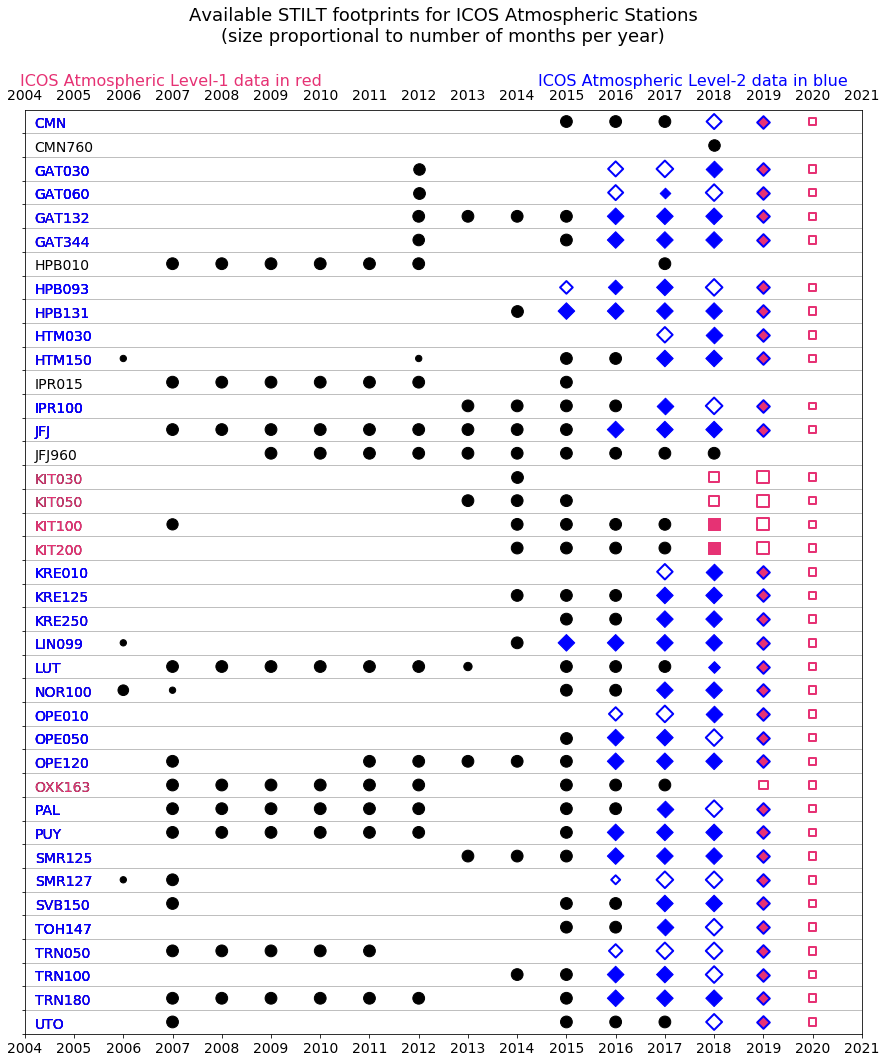

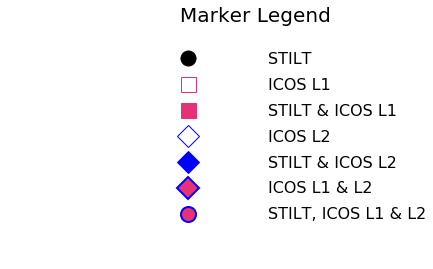

In [38]:
#Plot STILT & ICOS data availability (for ICOS Atmosphere Stations only):
plot_available_STILT_ICOS_L1_L2(availability_df)

<br>
<div style="text-align: right"> 
    <a href="#stilt_icos_plot">[Go to plot]</a>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
    <a href="#stilt_fp_plot">[Go to footprint map]</a>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
    <a href="#intro">Back to top</a>
<br>
<br>
<br>


<a id='icos_stilt_station_map'></a>
## 2.3 ICOS Atmospheric Stations with STILT Model Outputs --- > Map
<br>

In [39]:
#Call function to add columns containing reprojected coordinates from lat/long to Web Mercator:
stations_proj_df = changeprojection('epsg:4326', 'epsg:3857', stilt_icos_availability_df.reset_index(), 'lon', 'lat')

#Plot map:
m = plotmap_icos_stilt(stations_proj_df)

#Output should be in the notebook
output_notebook()
    
#Show plot
show(m)

Loading BokehJS ...

<br>
<div style="text-align: right"> 
    <a href="#intro">Back to top</a>
</div>
<br>
<br>
<br>

<a id='stilt_icosAtmObs'></a>

# 3. Plot STILT Model Results with ICOS Atmospheric Observations
This part presents visualizations of STILT Model Results in combination with ICOS Level-1 and/or Level-2 Atmospheric Observations for $CO_2$. More in particular, this part presents an interactive plot with STILT Model results in conjunction with ICOS Level-1 and Level-2 CO2 Atmospheric Data. The results can be viewed by year.

If you wish to use data from this tool in your work, click on the "citation" checkbox to get the text of the recommended citation format.

Note that the sampling height in the Station dropdown list refers to the sampling height defined by the user for the STILT model run and not to the actual sampling height(s) of the station. Plots displaying ICOS data (with or without STILT model results) will have the actual station sampling height stated in the title, whereas plots displaying only STILT model results will display the sampling height defined by the user for the model run.

<br>
<div style="text-align: right"> 
    <a href="#intro">Back to top</a>
</div>
<br>

## 3.1 Plot STILT Model Results with ICOS Atmospheric Observations ---> Python Code

<br>
<div style="text-align: right"> 
    <a href="#stilt_icos_plot">[Go to plot]</a>
</div>

In [40]:
def read_stilt_timeseries(station, date_range, stilt_icos_availability_df):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Mon Oct 08 10:30:00 2018
    Last Changed:     Tue May 07 09:00:00 2019
    Version:          1.1.0
    Author(s):        Ute, Karolina
    
    Description:      Function that takes three input parameters; STILT Station ID, a dataframe of Datetime Objects
                      and a dataframe showing the STILT Model Result and ICOS Level-1 & Level-2 data availability,
                      checks if there are STILT concentration time series available for the given parameters, and, if
                      this is the case, returns the available STILT concentration time series in a pandas dataframe.
                      
    Input parameters: 1. STILT Station Code
                         (var_name: 'station', var_type: String)
                      2. Dataframe with one column of Datetime Objects
                         (var_name: 'date_range', var_type: Pandas Dataframe)
                      3. Dataframe with info about ICOS Atmospheric Stations with STILT results
                         (var_name: 'stilt_icos_availability_df', var_type: Pandas Dataframe)

    Output:           Pandas Dataframe
                      
                      Columns:
                      1. Time (var_name: "isodate", var_type: date),
                      2. STILT CO2 (var_name: "co2.fuel", var_type: float)
                      3. Biospheric CO2 emissions (var_name: "co2.bio", var_type: float)
                      4. Background CO2 (var_name: "co2.background", var_type: float)
    
    """
    
    #Add URL:
    url = 'https://stilt.icos-cp.eu/viewer/stiltresult'
    
    #Add headers:
    headers = {'Content-Type': 'application/json', 'Accept-Charset': 'UTF-8'}
    
    #Create an empty list, to store the new time range with available STILT model results:
    new_range=[]
    
    #Loop through every Datetime object in the dataframe:
    for zDate in date_range:
        
        #Check if STILT results exist:
        if os.path.exists('/data/stiltweb/slots/'+
                          stilt_icos_availability_df.locIdent.loc[stilt_icos_availability_df.index==station].values[0]+
                          '/'+
                          str(zDate.year)+'/'+str(zDate.month).zfill(2)+'/'+
                          str(zDate.year)+'x'+str(zDate.month).zfill(2)+'x'+str(zDate.day).zfill(2)+'x'+
                          str(zDate.hour).zfill(2)+'/'):
            
            #If STILT-results exist for the current Datetime object, append current Datetime object to list: 
            new_range.append(zDate)
    
    #If the list is not empty:
    if len(new_range) > 0:
        
        #Assign the new time range to date_range:
        date_range = new_range
        
        #Get new starting date:
        fromDate = date_range[0].strftime('%Y-%m-%d')
        
        #Get new ending date:
        toDate = date_range[-1].strftime('%Y-%m-%d')
        
        #Store the STILT result column names to a variable:
        columns = ('["isodate","co2.stilt","co2.fuel","co2.bio", "co2.background"]')
        #columns = ('["isodate","co2.stilt","co2.fuel","co2.bio","co2.fuel.coal","co2.fuel.oil",'+
                   #'"co2.fuel.gas","co2.fuel.bio","co2.energy","co2.transport", "co2.industry",'+
                   #'"co2.others", "co2.cement", "co2.background",'+
                   #'"co.stilt","co.fuel","co.bio","co.fuel.coal","co.fuel.oil",'+
                   #'"co.fuel.gas","co.fuel.bio","co.energy","co.transport", "co.industry",'+
                   #'"co.others", "co.cement", "co.background",'+
                   #'"rn", "rn.era","rn.noah","wind.dir","wind.u","wind.v","latstart","lonstart"]')
        
        #Store the STILT result data column names to a variable:
        data = '{"columns": '+columns+', "fromDate": "'+fromDate+'", "toDate": "'+toDate+'", "stationId": "'+station+'"}'
        
        #Send request to get STILT results:
        response = requests.post(url, headers=headers, data=data)
        
        #Check if response is successful: 
        if response.status_code != 500:
            
            #Get response in json-format and read it in to a numpy array:
            output=np.asarray(response.json())
            
            #Convert numpy array with STILT results to a pandas dataframe: 
            df = pd.DataFrame(output[:,:], columns=eval(columns))
            
            #Replace 'null'-values with numpy NaN-values:
            df = df.replace('null',np.NaN)
            
            #Set dataframe data type to float:
            df = df.astype(float)
            
            #Convert the data type of the 'date'-column to Datetime Object:
            df['date'] = pd.to_datetime(df['isodate'], unit='s')
            
            #Set 'date'-column as index:
            df.set_index(['date'],inplace=True)
            
            #Add column with station name:
            df['name'] = station
            
            #Add column with model - name:
            df['model'] = 'STILT'
            
            #Add column to store information about  "wind-speed":
            #df['wind.speed']=np.sqrt((df['wind.u']**2)+(df['wind.v']**2))
        
        #response.status_code == 500
        else:
            
            #Print message:
            print("\033[0;31;1m Error...\nToo big STILT dataset!\nSelect data for a shorter time period.\n\n")
            
            #Create an empty dataframe:
            df=pd.DataFrame({'A' : []})
            
            
    #If the request fails, return an empty dataframe:        
    else:
        df=pd.DataFrame({'A' : []})
        
    #Return dataframe:    
    return df

In [41]:
def create_icos_stilt_station_labels(stilt_icos_availability_df):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Mon Apr 30 10:30:00 2018
    Last Changed:     Tue May 07 09:00:00 2019
    Version:          1.1.0
    Author(s):        Karolina
    
    Description:      Function that takes a pandas dataframe containing ICOS- & STILT-data information as input,
                      filters the dataframe for unique combinations of ICOS station name, STILT Station ID,
                      STILT Station Sampling Height, ICOS Station ID and ICOS Station Sampling Height and
                      returns a list of tuples. Every tuple contains the station name and a list, which in turn
                      includes the STILT Station ID, the STILT Station Sampling Height, the ICOS Station ID and
                      the ICOS Station Sampling Height.
                      
    Input parameters: Dataframe with info about ICOS Atmospheric Stations with STILT results
                      (var_name: 'stilt_icos_availability_df', var_type: Pandas Dataframe)

    Output:           List of tuples
                      
                      Tuple:
                      1. Station Label (e.g. "Gartow (alt. 30.0)")
                      2. List (e.g. ['GAT030', '30.0', 'GAT', '30.0'])
    
    """
    
    df = stilt_icos_availability_df.reset_index().filter(['stationName',
                                                          'stiltStationId',
                                                          'stiltSamplingHeight',
                                                          'stationId',
                                                          'ICOS_SamplHeight']).drop_duplicates(subset=['stationName',
                                                                                                       'stiltStationId',
                                                                                                       'stiltSamplingHeight',
                                                                                                       'stationId',
                                                                                                       'ICOS_SamplHeight'])

    #Sort dataframe by the STILT Station ID:
    df = df.sort_values(by=['stiltStationId'])

    #Get a list of tuples for every station that has provided tracer-data:
    #Every tuple is constructed like: ('Gartow (alt. 30.0)', ['GAT030', 'GAT', '30.0'])
    station_labels = [(df.stationName.iloc[i]+ " (alt. " + str(df.stiltSamplingHeight.iloc[i]) + ")",
                       [df.stiltStationId.iloc[i],
                        str(df.stiltSamplingHeight.iloc[i]),
                        df.stationId.iloc[i],
                        str(df.ICOS_SamplHeight.iloc[i])]) for i in range(len(df))]
    

    #Return list of tuples:
    return station_labels

In [42]:
def plot_icos_single_station_L1_L2_binary(data_df_list, station_info_dict, tracer_info_dict, color='#0F0C08'):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Tue May 07 10:30:00 2018
    Last Changed:     Tue May 07 10:30:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that returns an interactive Bokeh plot of ICOS Level-1 and Level-2
                      Atmopsheric Data for a given ICOS Atmosphere Station.
                      
    Input parameters: 1. List of metadata dataframes for every ICOS Level-1 or Level-2 Data File
                         for a specific ICOS station and timeperiod.
                         (var_name: 'metadata_df_list', var_type: List of pandas dataframes)
                      2. List of data dataframes for every ICOS Level-1 or Level-2 Data File
                         for a specific ICOS station and timeperiod.
                         (var_name: 'data_df_list', var_type: List of pandas dataframes)
                      3. Tracer/gas (var_name: "tracer", var_type: String)
                      4. Plot line/point color (var_name: "color", var_type: String)

    Output:           Bokeh Plot
    
    """
    
    #Import modules to create figure:
    import pandas as pd
    from bokeh.plotting import figure
    from bokeh.models import ColumnDataSource, HoverTool, Label, Legend
    from datetime import datetime

    #Dictionary for subscript transformations of numbers:
    SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")

    #Create a figure object:
    p = figure(plot_width=900,
               plot_height=500,
               x_axis_label='Time (UTC)', 
               y_axis_label=tracer_info_dict['tracer_info'].replace(' mixing ratio (dry mole fraction)', '').translate(SUB)+
               ' (' +tracer_info_dict['tracer_unit'].translate(SUP) + ')',
               x_axis_type='datetime',
               title = tracer_info_dict['tracer_info'].replace(' mixing ratio (dry mole fraction)', '').translate(SUB)+
               ' - Continuous air ( '+
               station_info_dict['station_code']+', '+#.encode('latin1').decode('utf8')+', '+
               station_info_dict['station_country']+', '+
               station_info_dict['station_sampling_height']+' m agl)' ,
               tools='pan,box_zoom,wheel_zoom,reset,save')
    
    
    #Create an empty list that will store the legend info:
    legend_it = []

    #Extract time and tracer values for every data level:
    x1 = data_df_list[0].index.values
    y1 = data_df_list[0][tracer_info_dict['tracer_info'].replace(' mixing ratio (dry mole fraction)', '').lower()].values
    x2 = data_df_list[1].index.values
    y2 = data_df_list[1][tracer_info_dict['tracer_info'].replace(' mixing ratio (dry mole fraction)', '').lower()].values

    #Create a circle and line glyph for the values of every emission category:
    r0 = p.circle(x1, y1, radius=.12, color=color, alpha=0.5)
    r1 = p.line(x1, y1, line_width=2, line_dash='dotted', line_alpha=0.5, color=color, name='L1, '+station_info_dict['station_code']+' ('+station_info_dict['station_sampling_height']+')')
    r2 = p.circle(x2, y2, radius=.12, color=color)
    r3 = p.line(x2, y2, line_width=1, color=color, name='L2, '+station_info_dict['station_code']+' ('+station_info_dict['station_sampling_height']+')')
    
    #Add the name and glyph info (i.e. colour and marker type) to the legend:
    legend_it.append(('Level 1 - '+station_info_dict['station_code']+' ('+station_info_dict['station_sampling_height']+')', [r1]))
    
    #Add the name and glyph info (i.e. colour and marker type) to the legend:
    legend_it.append(('Level 2 - '+station_info_dict['station_code']+' ('+station_info_dict['station_sampling_height']+')', [r3]))



    #Add tooltip on hover:
    p.add_tools(HoverTool(tooltips=[
        ('Station','$name'),
        ('Time (UTC)','@x{%Y-%m-%d %H:%M:%S}'),
        (tracer_info_dict['tracer_info'].replace(' mixing ratio (dry mole fraction)','').translate(SUB),'@y{0.f}'),
        ],
        formatters={
            'x'      : 'datetime', # use 'datetime' formatter for 'date' field
            },
        # display a tooltip whenever the cursor is vertically in line with a glyph
        mode='vline'
        ))    

    #Create legend:
    legend = Legend(items=legend_it, location= 'bottom_center')
    legend.orientation = 'horizontal'
    legend.click_policy='hide'
    legend.spacing = 10 #sets the distance between legend entries

    #Set title attributes:
    p.title.align = 'center'
    p.title.text_font_size = '13pt'
    p.title.offset = 15

    #Set axis label font style:
    p.xaxis.axis_label_text_font_style = 'normal'
    p.yaxis.axis_label_text_font_style = 'normal'
    p.xaxis.axis_label_standoff = 15 #Sets the distance of the label from the x-axis in screen units
    p.yaxis.axis_label_standoff = 15 #Sets the distance of the label from the y-axis in screen units

    #Set the copyright label position:
    label_opts = dict(x=0, y=10,
                      x_units='screen', y_units='screen')
    
    #Create a label object to store the copyright text:
    caption1 = Label(text="© ICOS ERIC", **label_opts)
    caption1.text_font_size = '8pt'
    
    #Deactivate hover-tool, which is by default active:
    p.toolbar.active_inspect = None

    #Add copyright-label to plot:
    p.add_layout(caption1, 'below')
    
    #Add legend to figure:
    p.add_layout(legend, 'below')

    #return plot:
    return p
    

In [43]:
def plot_icos_L1_L2_stilt_single_station_binary(stilt_df, data_df_list, station_info_dict, tracer_info_dict):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Tue May 07 10:30:00 2018
    Last Changed:     Tue May 07 10:30:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that returns an interactive Bokeh plot of ICOS Level-1 and Level-2
                      Atmopsheric Data in conjunction with STILT Model Results for the same station.
                      
    Input parameters: 1. Dataframe with STILT Model Results for a specific ICOS station and timeperiod
                         (var_name: 'stilt_df', var_type: Pandas DataFrame)
                      2. List of data dataframes for every ICOS Level-1 or Level-2 Data File
                         for a specific ICOS station and timeperiod.
                         (var_name: 'data_df_list', var_type: List of pandas dataframes)
                      4. Dictionary with ICOS station info
                         (var_name: 'station_info_dict', var_type: Dictionary)
                      5. Dictionary with tracer info
                         (var_name: 'tracer_info_dict', var_type: Dictionary)

    Output:           Bokeh Plot
    
    """
    
    #Import modules to create figure:
    from bokeh.plotting import figure
    from bokeh.models import ColumnDataSource, HoverTool, Label, Legend, LinearAxis, Range1d, SingleIntervalTicker
    from datetime import datetime

    #Dictionaries for subscript/superscript transformations of numbers:
    SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")

    #Define Datasets:
    x1 = stilt_df.index.values                 #STILT time
    y1 = stilt_df['co2.stilt'].values          #STILT CO2
    y2 = stilt_df['co2.background'].values     #STILT background
    y3 = stilt_df['co2.fuel'].values           #STILT Fuel
    y4 = stilt_df['co2.bio'].values            #STILT bio
    x2 = data_df_list[0].index.values          #ICOS Level-1 time
    y5 = data_df_list[0][tracer_info_dict['tracer_info'].replace(' mixing ratio (dry mole fraction)','').lower()]  #ICOS Level-1 CO2 observations
    x3 = data_df_list[1].index.values          #ICOS Level-2 time
    y6 = data_df_list[1][tracer_info_dict['tracer_info'].replace(' mixing ratio (dry mole fraction)','').lower()]  #ICOS Level-2 CO2 observations
    
    

    #Create a figure object:
    p = figure(plot_width=900,
               plot_height=400,
               x_axis_label='Time (UTC)', 
               y_axis_label=tracer_info_dict['tracer_info'].replace(' mixing ratio (dry mole fraction)','').translate(SUB) + ' (ppm)',
               x_axis_type='datetime',
               title = 'STILT Model Output ('+
               station_info_dict['station_code']+', sampling height: '+
               station_info_dict['station_sampling_height']+' m agl)',
               tools='pan,box_zoom,wheel_zoom,undo,reset,save')
    
    
    #Get primary and secondary y_axis limits:
    y1_stilt_min = (stilt_df[[ 'co2.stilt', 'co2.background']].min()).min()
    y1_stilt_max = (stilt_df[[ 'co2.stilt', 'co2.background']].max()).max()
    y1_icos_L1_min = (min(y5))
    y1_icos_L1_max = (max(y5))
    y1_icos_L2_min = (min(y6))
    y1_icos_L2_max = (max(y6))
    y1_axis_min = min([y1_stilt_min, y1_icos_L1_min, y1_icos_L2_min])
    y1_axis_max = max([y1_stilt_max, y1_icos_L1_max, y1_icos_L2_max])
    y2_axis_min = (stilt_df[[ 'co2.fuel', 'co2.bio']].min()).min()
    y2_axis_max = (stilt_df[[ 'co2.fuel', 'co2.bio']].max()).max()
    
    
    ##### Control min/max values for both y-axes to allign their major ticks #####
    #If the difference between min & max values is >120 for both axes:
    if(((y1_axis_max-y1_axis_min)>120) & ((y2_axis_max-y2_axis_min)>120)):
        
        #Round up or down values to nearest 100:
        y1_axis_min = rounddown_100(y1_axis_min)
        y1_axis_max = roundup_100(y1_axis_max)
        y2_axis_min = rounddown_100(y2_axis_min)
        y2_axis_max = roundup_100(y2_axis_max)
        
        #Set primary and secondary y-axis range, so that they are alligned:
        p.y_range, p.extra_y_ranges = set_yranges_2y(y1_axis_min,
                                                     y1_axis_max,
                                                     y2_axis_min,
                                                     y2_axis_max,
                                                     100.0,
                                                     100.0, 
                                                     'Yaxis2')
        
        #Set y-axes ticker interval:
        ticker1 = SingleIntervalTicker(interval=100)
        ticker2 = ticker1
        
    #If the difference between min & max values is >120 for the primary y-axis only:
    elif(((y1_axis_max-y1_axis_min)>120) & ((y2_axis_max-y2_axis_min)<120)):
        
        #Round up or down values to nearest 100:
        y1_axis_min = rounddown_100(y1_axis_min)
        y1_axis_max = roundup_100(y1_axis_max)
        y2_axis_min = rounddown_20(y2_axis_min)
        y2_axis_max = roundup_20(y2_axis_max)
        
        #Set primary and secondary y-axis range, so that they are alligned:
        p.y_range, p.extra_y_ranges = set_yranges_2y(y1_axis_min,
                                                     y1_axis_max,
                                                     y2_axis_min,
                                                     y2_axis_max,
                                                     100.0,
                                                     20.0, 
                                                     'Yaxis2')
        
        #Set y-axes ticker interval:
        ticker1 = SingleIntervalTicker(interval=100)
        ticker2 = SingleIntervalTicker(interval=20)
        
        
    #If the difference between min & max values is >120 for the secondary y-axis only:
    elif(((y1_axis_max-y1_axis_min)<120) & ((y2_axis_max-y2_axis_min)>120)):
        
        #Round up or down values to nearest 100:
        y1_axis_min = rounddown_20(y1_axis_min)
        y1_axis_max = roundup_20(y1_axis_max)
        y2_axis_min = rounddown_100(y2_axis_min)
        y2_axis_max = roundup_100(y2_axis_max)
        
        #Set primary and secondary y-axis range, so that they are alligned:
        p.y_range, p.extra_y_ranges = set_yranges_2y(y1_axis_min,
                                                     y1_axis_max,
                                                     y2_axis_min,
                                                     y2_axis_max,
                                                     20.0,
                                                     100.0, 
                                                     'Yaxis2')
        
        #Set y-axes ticker interval:
        ticker1 = SingleIntervalTicker(interval=20)
        ticker2 = SingleIntervalTicker(interval=100)
        
    
    #If the difference between min & max values is <120 for both y-axes:
    else:
        #Round up or down values to nearest 100:
        y1_axis_min = rounddown_20(y1_axis_min)
        y1_axis_max = roundup_20(y1_axis_max)
        y2_axis_min = rounddown_20(y2_axis_min)
        y2_axis_max = roundup_20(y2_axis_max)
        
        #Set primary and secondary y-axis range, so that they are alligned:
        p.y_range, p.extra_y_ranges = set_yranges_2y(y1_axis_min,
                                                     y1_axis_max,
                                                     y2_axis_min,
                                                     y2_axis_max,
                                                     20.0,
                                                     20.0, 
                                                     'Yaxis2')
        
        #Set y-axes ticker interval:
        ticker1 = SingleIntervalTicker(interval=20)
        ticker2 = SingleIntervalTicker(interval=20)
    
    ######
    
    

    #Create glyphs:
    g0 = p.circle(x1, y1, radius=.02, color='blue')
    g1 = p.line(x1, y1, line_width=1.5, color='blue', name='STILT')
    g2 = p.circle(x1, y2, radius=.02, color='#42bdff')#'#6baed6'
    g3 = p.line(x1, y2, line_width=1.5, color='#42bdff', name='background')
    g4 = p.circle(x1, y3, radius=.02, color='#d01c8b', y_range_name='Yaxis2')
    g5 = p.line(x1, y3, line_width=1.5, color='#d01c8b', name='fuel', y_range_name='Yaxis2')
    g6 = p.circle(x1, y4, radius=.02, color='#4dac26', y_range_name='Yaxis2')
    g7 = p.line(x1, y4, line_width=1.5, color='#4dac26', name='bio', y_range_name='Yaxis2')
    g8 = p.circle(x2, y5, radius=.02, color='#0F0C08')
    g9 = p.line(x2, y5, line_width=1.5, line_dash='dotted', line_alpha=0.5, color='#0F0C08', name='ICOS L1 Obs')
    g10 = p.circle(x3, y6, radius=.02, color='#0F0C08')
    g11 = p.line(x3, y6, line_width=1.5, color='#0F0C08', name='ICOS L2 Obs')
    
      
    #Create an empty list that will store the legend info:
    legend_it = []
    
    #Add the name and glyph info (i.e. colour and marker type) to the legend:
    legend_it.append((g1.name, [g0, g1]))
    legend_it.append((g3.name, [g2, g3]))
    legend_it.append((g5.name, [g4, g5]))
    legend_it.append((g7.name, [g6, g7]))
    legend_it.append((g9.name, [g8, g9]))
    legend_it.append((g11.name, [g10, g11]))
    
    #Add tooltip on hover:
    p.add_tools(HoverTool(tooltips=[
        ('Time (UTC)','@x{%Y-%m-%d %H:%M:%S}'),
        (tracer_info_dict['tracer_info'].replace(' mixing ratio (dry mole fraction)','').translate(SUB),'@y{0.f}'),
        ('Category', '$name')
        ],
        formatters={
            'x'      : 'datetime', # use 'datetime' formatter for 'date' field
            },
        # display a tooltip whenever the cursor is vertically in line with a glyph
        mode='vline'
        ))    

    #Create legend:
    legend = Legend(items=legend_it, location= 'bottom_center')
    legend.orientation = 'horizontal'
    legend.click_policy='hide'
    legend.spacing = 10 #sets the distance between legend entries

    #Set title attributes:
    p.title.align = 'center'
    p.title.text_font_size = '13pt'
    p.title.offset = 15

    #Set label font style:
    p.xaxis.axis_label_text_font_style = 'normal'
    p.yaxis.axis_label_text_font_style = 'normal'
    p.xaxis.axis_label_standoff = 15 #Sets the distance of the label from the x-axis in screen units
    p.yaxis.axis_label_standoff = 15 #Sets the distance of the label from the y-axis in screen units
    
    #Set primary y-axis ticker:
    p.yaxis.ticker = ticker1
    
    #Create 2nd y-axis: 
    bg_yaxis = LinearAxis(y_range_name='Yaxis2',
                          axis_label=tracer_info_dict['tracer_info'].replace(' mixing ratio (dry mole fraction)','').translate(SUB)+' Components (ppm): Bio & Fuel',
                          ticker=ticker2,
                          axis_label_standoff = 15)
    
    #Add secondary y-axis to the right:
    p.add_layout(bg_yaxis, 'right')
    

    #Set the copyright label position:
    label_opts = dict(x=0, y=10,
                      x_units='screen', y_units='screen')

    #Create a label object and format it:
    caption1 = Label(text="© ICOS ERIC", **label_opts)
    caption1.text_font_size = '8pt'
    
    #Deactivate hover-tool, which is by default active:
    p.toolbar.active_inspect = None

    #Add label to plot:
    p.add_layout(caption1, 'below')
    
    #Add legend to figure:
    p.add_layout(legend, 'below')
    
    #Return plot:
    return p
    
    

In [44]:
def plot_stilt_icos_single_station_binary(data_Lx_df, station_info_dict, tracer_info_dict, icos_data_level, stilt_df):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Tue May 07 10:00:00 2018
    Last Changed:     Tue May 07 10:00:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that returns an interactive Bokeh plot of ICOS Level-1 or Level-2
                      Atmopsheric Data for a given ICOS Atmosphere Station in conjunction with STILT
                      Model Results for the same station.
                      
    Input parameters: 1. Data dataframes with ICOS Level-1 or Level-2 Data
                         (var_name: 'data_Lx_df', var_type: Pandas DataFrame)
                      2. Dictionary with ICOS station info
                         (var_name: 'station_info_dict', var_type: Dictionary)
                      3. Dictionary with tracer info
                         (var_name: 'tracer_info_dict', var_type: Dictionary)
                      4. ICOS Data Level (var_name: "icos_data_level", var_type: Integer)
                      5. Dataframe with STILT Model Results for a specific ICOS station and timeperiod
                         (var_name: 'stilt_df', var_type: Pandas DataFrame)

    Output:           Bokeh Plot
    
    """

    #Import modules to create figure:
    from bokeh.plotting import figure
    from bokeh.models import ColumnDataSource, HoverTool, Label, Legend, LinearAxis, Range1d, SingleIntervalTicker
    from datetime import datetime

    #Dictionaries for subscript/superscript transformations of numbers:
    SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")

    #Define Datasets:
    x1 = stilt_df.index.values                 #STILT time
    y1 = stilt_df['co2.stilt'].values          #STILT CO2
    y2 = stilt_df['co2.background'].values     #STILT background
    y3 = stilt_df['co2.fuel'].values           #STILT Fuel
    y4 = stilt_df['co2.bio'].values            #STILT bio
    x2 = data_Lx_df.index.values               #ICOS time
    y5 = data_Lx_df[tracer_info_dict['tracer_info'].replace(' mixing ratio (dry mole fraction)','').lower()] #ICOS CO2 observations
    

    #Create a figure object:
    p = figure(plot_width=900,
               plot_height=400,
               x_axis_label='Time (UTC)', 
               y_axis_label=tracer_info_dict['tracer_info'].replace(' mixing ratio (dry mole fraction)','').translate(SUB) + ' (ppm)',
               x_axis_type='datetime',
               title = 'STILT Model Output ('+
               station_info_dict['station_code']+', sampling height: '+
               station_info_dict['station_sampling_height']+' m agl)',
               tools='pan,box_zoom,wheel_zoom,undo,reset,save')
    
    
    #Get primary and secondary y_axis limits:
    y1_stilt_min = (stilt_df[[ 'co2.stilt', 'co2.background']].min()).min()
    y1_stilt_max = (stilt_df[[ 'co2.stilt', 'co2.background']].max()).max()
    y1_icos_min = min(y5)
    y1_icos_max = max(y5)
    y1_axis_min = min([y1_stilt_min, y1_icos_min])
    y1_axis_max = max([y1_stilt_max, y1_icos_max])
    y2_axis_min = (stilt_df[[ 'co2.fuel', 'co2.bio']].min()).min()
    y2_axis_max = (stilt_df[[ 'co2.fuel', 'co2.bio']].max()).max()
    
    
    ##### Control min/max values for both y-axes to allign their major ticks #####
    #If the difference between min & max values is >120 for both axes:
    if(((y1_axis_max-y1_axis_min)>120) & ((y2_axis_max-y2_axis_min)>120)):
        
        #Round up or down values to nearest 100:
        y1_axis_min = rounddown_100(y1_axis_min)
        y1_axis_max = roundup_100(y1_axis_max)
        y2_axis_min = rounddown_100(y2_axis_min)
        y2_axis_max = roundup_100(y2_axis_max)
        
        #Set primary and secondary y-axis range, so that they are alligned:
        p.y_range, p.extra_y_ranges = set_yranges_2y(y1_axis_min,
                                                     y1_axis_max,
                                                     y2_axis_min,
                                                     y2_axis_max,
                                                     100.0,
                                                     100.0, 
                                                     'Yaxis2')
        
        #Set y-axes ticker interval:
        ticker1 = SingleIntervalTicker(interval=100)
        ticker2 = ticker1
        
    #If the difference between min & max values is >120 for the primary y-axis only:
    elif(((y1_axis_max-y1_axis_min)>120) & ((y2_axis_max-y2_axis_min)<120)):
        
        #Round up or down values to nearest 100:
        y1_axis_min = rounddown_100(y1_axis_min)
        y1_axis_max = roundup_100(y1_axis_max)
        y2_axis_min = rounddown_20(y2_axis_min)
        y2_axis_max = roundup_20(y2_axis_max)
        
        #Set primary and secondary y-axis range, so that they are alligned:
        p.y_range, p.extra_y_ranges = set_yranges_2y(y1_axis_min,
                                                     y1_axis_max,
                                                     y2_axis_min,
                                                     y2_axis_max,
                                                     100.0,
                                                     20.0, 
                                                     'Yaxis2')
        
        #Set y-axes ticker interval:
        ticker1 = SingleIntervalTicker(interval=100)
        ticker2 = SingleIntervalTicker(interval=20)
        
        
    #If the difference between min & max values is >120 for the secondary y-axis only:
    elif(((y1_axis_max-y1_axis_min)<120) & ((y2_axis_max-y2_axis_min)>120)):
        
        #Round up or down values to nearest 100:
        y1_axis_min = rounddown_20(y1_axis_min)
        y1_axis_max = roundup_20(y1_axis_max)
        y2_axis_min = rounddown_100(y2_axis_min)
        y2_axis_max = roundup_100(y2_axis_max)
        
        #Set primary and secondary y-axis range, so that they are alligned:
        p.y_range, p.extra_y_ranges = set_yranges_2y(y1_axis_min,
                                                     y1_axis_max,
                                                     y2_axis_min,
                                                     y2_axis_max,
                                                     20.0,
                                                     100.0, 
                                                     'Yaxis2')
        
        #Set y-axes ticker interval:
        ticker1 = SingleIntervalTicker(interval=20)
        ticker2 = SingleIntervalTicker(interval=100)
        
    
    #If the difference between min & max values is <120 for both y-axes:
    else:
        #Round up or down values to nearest 100:
        y1_axis_min = rounddown_20(y1_axis_min)
        y1_axis_max = roundup_20(y1_axis_max)
        y2_axis_min = rounddown_20(y2_axis_min)
        y2_axis_max = roundup_20(y2_axis_max)
        
        #Set primary and secondary y-axis range, so that they are alligned:
        p.y_range, p.extra_y_ranges = set_yranges_2y(y1_axis_min,
                                                     y1_axis_max,
                                                     y2_axis_min,
                                                     y2_axis_max,
                                                     20.0,
                                                     20.0, 
                                                     'Yaxis2')
        
        #Set y-axes ticker interval:
        ticker1 = SingleIntervalTicker(interval=20)
        ticker2 = SingleIntervalTicker(interval=20)
    
    ######
    
    
    
    
    #Create glyphs:
    g0 = p.circle(x1, y1, radius=.02, color='blue')
    g1 = p.line(x1, y1, line_width=1.5, color='blue', name='STILT')
    g2 = p.circle(x1, y2, radius=.02, color='#42bdff')#'#6baed6'
    g3 = p.line(x1, y2, line_width=1.5, color='#42bdff', name='background')
    g4 = p.circle(x1, y3, radius=.02, color='#d01c8b', y_range_name='Yaxis2')
    g5 = p.line(x1, y3, line_width=1.5, color='#d01c8b', name='fuel', y_range_name='Yaxis2')
    g6 = p.circle(x1, y4, radius=.02, color='#4dac26', y_range_name='Yaxis2')
    g7 = p.line(x1, y4, line_width=1.5, color='#4dac26', name='bio', y_range_name='Yaxis2')
    g8 = p.circle(x2, y5, radius=.02, color='#0F0C08')
    g9 = p.line(x2, y5, line_width=1.5, color='#0F0C08', name='ICOS L'+str(icos_data_level)+' Obs')
    
      
    #Create an empty list that will store the legend info:
    legend_it = []
    
    #Add the name and glyph info (i.e. colour and marker type) to the legend:
    legend_it.append((g1.name, [g0, g1]))
    legend_it.append((g3.name, [g2, g3]))
    legend_it.append((g5.name, [g4, g5]))
    legend_it.append((g7.name, [g6, g7]))
    legend_it.append((g9.name, [g8, g9]))
    
    #Add tooltip on hover:
    p.add_tools(HoverTool(tooltips=[
        ('Time (UTC)','@x{%Y-%m-%d %H:%M:%S}'),
        (tracer_info_dict['tracer_info'].replace(' mixing ratio (dry mole fraction)','').translate(SUB),'@y{0.f}'),
        ('Category', '$name')
        ],
        formatters={
            'x'      : 'datetime', # use 'datetime' formatter for 'date' field
            },
        # display a tooltip whenever the cursor is vertically in line with a glyph
        mode='vline'
        ))    

    #Create legend:
    legend = Legend(items=legend_it, location= 'bottom_center')
    legend.orientation = 'horizontal'
    legend.click_policy='hide'
    legend.spacing = 10 #sets the distance between legend entries

    #Set title attributes:
    p.title.align = 'center'
    p.title.text_font_size = '13pt'
    p.title.offset = 15

    #Set label font style:
    p.xaxis.axis_label_text_font_style = 'normal'
    p.yaxis.axis_label_text_font_style = 'normal'
    p.xaxis.axis_label_standoff = 15 #Sets the distance of the label from the x-axis in screen units
    p.yaxis.axis_label_standoff = 15 #Sets the distance of the label from the y-axis in screen units
    
    #Set primary y-axis ticker:
    p.yaxis.ticker = ticker1
    
    #Create 2nd y-axis: 
    bg_yaxis = LinearAxis(y_range_name='Yaxis2',
                          axis_label=tracer_info_dict['tracer_info'].replace(' mixing ratio (dry mole fraction)','').translate(SUB)+' Components (ppm): Bio & Fuel',
                          ticker=ticker2,
                          axis_label_standoff = 15)
    
    #Add secondary y-axis to the right:
    p.add_layout(bg_yaxis, 'right')
    

    #Set the copyright label position:
    label_opts = dict(x=0, y=10,
                      x_units='screen', y_units='screen')

    #Create a label object and format it:
    caption1 = Label(text="© ICOS ERIC", **label_opts)
    caption1.text_font_size = '8pt'
    
    #Deactivate hover-tool, which is by default active:
    p.toolbar.active_inspect = None

    #Add label to plot:
    p.add_layout(caption1, 'below')
    
    #Add legend to figure:
    p.add_layout(legend, 'below')
    
    #Return plot:
    return p
  

In [45]:
def plot_stilt_single_station_binary(stilt_df, Station, tracer):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Wed May 08 15:00:00 2019
    Last Changed:     Wed May 08 15:00:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that plots the content of an STILT model output data file to an 
                      interactive plot using the Bokeh interactive visualization library.
                      Bokeh (URL): https://bokeh.pydata.org/en/latest/
                      
    Input parameters: 1. Dataframe with STILT Model Result for a specific ICOS Station
                         (var_name: 'stilt_df', var_type: pandas dataframe)
                      2. List with ICOS Station Info
                         (var_name: "Station", var_type: List of Strings)
                      3. Name of gas/tracer - e.g. 'co2'
                         (var_name: 'tracer', var_type: String)

    Output:           Bokeh Figure Object (plot) 
    
    """
    
    #Import modules to create figure:
    from bokeh.plotting import figure
    from bokeh.models import ColumnDataSource, HoverTool, Label, Legend, LinearAxis, Range1d, SingleIntervalTicker
    from datetime import datetime

    #Dictionary for subscript/superscript transformations:
    #SUB = {ord(c): ord(t) for c, t in zip(u"0123456789", u"₀₁₂₃₄₅₆₇₈₉")}
    #SUP = {ord(c): ord(t) for c, t in zip(u"0123456789", u"⁰¹²³⁴⁵⁶⁷⁸⁹")}

    #Dictionary for subscript transformations of numbers:
    SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

    #Define Datasets:
    x = stilt_df.index.values
    y1 = stilt_df['co2.stilt'].values
    y2= stilt_df['co2.background'].values
    y3 = stilt_df['co2.fuel'].values
    y4 = stilt_df['co2.bio'].values

    #Create a figure object:
    p = figure(plot_width=900,
               plot_height=400,
               x_axis_label='Time (UTC)', 
               y_axis_label=tracer.upper().translate(SUB) + ' (ppm)',
               x_axis_type='datetime',
               title = 'STILT Model Output ('+
               Station[0]+', sampling height: '+
               Station[1]+' m agl)',
               tools='pan,box_zoom,wheel_zoom,undo,reset,save')
    
    
    
    #Get primary and secondary y_axis limits:
    y1_axis_min = (stilt_df[[ 'co2.stilt', 'co2.background']].min()).min()
    y1_axis_max = (stilt_df[[ 'co2.stilt', 'co2.background']].max()).max()
    y2_axis_min = (stilt_df[[ 'co2.fuel', 'co2.bio']].min()).min()
    y2_axis_max = (stilt_df[[ 'co2.fuel', 'co2.bio']].max()).max()
    
    
    ##### Control min/max values for both y-axes to allign their major ticks #####
    #If the difference between min & max values is >120 for both axes:
    if(((y1_axis_max-y1_axis_min)>120) & ((y2_axis_max-y2_axis_min)>120)):
        
        #Round up or down values to nearest 100:
        y1_axis_min = rounddown_100(y1_axis_min)
        y1_axis_max = roundup_100(y1_axis_max)
        y2_axis_min = rounddown_100(y2_axis_min)
        y2_axis_max = roundup_100(y2_axis_max)
        
        #Set primary and secondary y-axis range, so that they are alligned:
        p.y_range, p.extra_y_ranges = set_yranges_2y(y1_axis_min,
                                                     y1_axis_max,
                                                     y2_axis_min,
                                                     y2_axis_max,
                                                     100.0,
                                                     100.0, 
                                                     'Yaxis2')
        
        #Set y-axes ticker interval:
        ticker1 = SingleIntervalTicker(interval=100)
        ticker2 = ticker1
        
    #If the difference between min & max values is >120 for the primary y-axis only:
    elif(((y1_axis_max-y1_axis_min)>120) & ((y2_axis_max-y2_axis_min)<120)):
        
        #Round up or down values to nearest 100:
        y1_axis_min = rounddown_100(y1_axis_min)
        y1_axis_max = roundup_100(y1_axis_max)
        y2_axis_min = rounddown_20(y2_axis_min)
        y2_axis_max = roundup_20(y2_axis_max)
        
        #Set primary and secondary y-axis range, so that they are alligned:
        p.y_range, p.extra_y_ranges = set_yranges_2y(y1_axis_min,
                                                     y1_axis_max,
                                                     y2_axis_min,
                                                     y2_axis_max,
                                                     100.0,
                                                     20.0, 
                                                     'Yaxis2')
        
        #Set y-axes ticker interval:
        ticker1 = SingleIntervalTicker(interval=100)
        ticker2 = SingleIntervalTicker(interval=20)
        
        
    #If the difference between min & max values is >120 for the secondary y-axis only:
    elif(((y1_axis_max-y1_axis_min)<120) & ((y2_axis_max-y2_axis_min)>120)):
        
        #Round up or down values to nearest 100:
        y1_axis_min = rounddown_20(y1_axis_min)
        y1_axis_max = roundup_20(y1_axis_max)
        y2_axis_min = rounddown_100(y2_axis_min)
        y2_axis_max = roundup_100(y2_axis_max)
        
        #Set primary and secondary y-axis range, so that they are alligned:
        p.y_range, p.extra_y_ranges = set_yranges_2y(y1_axis_min,
                                                     y1_axis_max,
                                                     y2_axis_min,
                                                     y2_axis_max,
                                                     20.0,
                                                     100.0, 
                                                     'Yaxis2')
        
        #Set y-axes ticker interval:
        ticker1 = SingleIntervalTicker(interval=20)
        ticker2 = SingleIntervalTicker(interval=100)
        
    
    #If the difference between min & max values is <120 for both y-axes:
    else:
        #Round up or down values to nearest 100:
        y1_axis_min = rounddown_20(y1_axis_min)
        y1_axis_max = roundup_20(y1_axis_max)
        y2_axis_min = rounddown_20(y2_axis_min)
        y2_axis_max = roundup_20(y2_axis_max)
        
        #Set primary and secondary y-axis range, so that they are alligned:
        p.y_range, p.extra_y_ranges = set_yranges_2y(y1_axis_min,
                                                     y1_axis_max,
                                                     y2_axis_min,
                                                     y2_axis_max,
                                                     20.0,
                                                     20.0, 
                                                     'Yaxis2')
        
        #Set y-axes ticker interval:
        ticker1 = SingleIntervalTicker(interval=20)
        ticker2 = SingleIntervalTicker(interval=20)
    
    ######
    
    
    #Create glyphs:
    g0 = p.circle(x, y1, radius=.02, color='blue')
    g1 = p.line(x, y1, line_width=1.5, color='blue', name='STILT')
    g2 = p.circle(x, y2, radius=.02, color='#8fd8ff')
    g3 = p.line(x, y2, line_width=1.5, color='#8fd8ff', name='background') ##42bdff
    g4 = p.circle(x, y3, radius=.02, color='#d01c8b', y_range_name='Yaxis2')
    g5 = p.line(x, y3, line_width=1.5, color='#d01c8b', name='fuel', y_range_name='Yaxis2')
    g6 = p.circle(x, y4, radius=.02, color='#4dac26', y_range_name='Yaxis2')
    g7 = p.line(x, y4, line_width=1.5, color='#4dac26', name='bio', y_range_name='Yaxis2')
      
    #Create an empty list that will store the legend info:
    legend_it = []
    
    #Add the name and glyph info (i.e. colour and marker type) to the legend:
    legend_it.append((g1.name, [g0, g1]))
    legend_it.append((g3.name, [g2, g3]))
    legend_it.append((g5.name, [g4, g5]))
    legend_it.append((g7.name, [g6, g7]))
    
    #Add tooltip on hover:
    p.add_tools(HoverTool(tooltips=[
        ('Time (UTC)','@x{%Y-%m-%d %H:%M:%S}'),
        (tracer.upper().translate(SUB),'@y{0.f}'),
        ('Category', '$name')
        ],
        formatters={
            'x'      : 'datetime', # use 'datetime' formatter for 'date' field
            },
        # display a tooltip whenever the cursor is vertically in line with a glyph
        mode='vline'
        ))    

    #Create legend:
    legend = Legend(items=legend_it, location= 'bottom_center')
    legend.orientation = 'horizontal'
    legend.click_policy='hide'
    legend.spacing = 10 #sets the distance between legend entries

    #Set title attributes:
    p.title.align = 'center'
    p.title.text_font_size = '13pt'
    p.title.offset = 15

    #Set axis label font style:
    p.xaxis.axis_label_text_font_style = 'normal'
    p.yaxis.axis_label_text_font_style = 'normal'
    p.xaxis.axis_label_standoff = 15 #Sets the distance of the label from the x-axis in screen units
    p.yaxis.axis_label_standoff = 15 #Sets the distance of the label from the y-axis in screen units
    
    #Set primary y-axis ticker:
    p.yaxis.ticker = ticker1
    
    #Create 2nd y-axis: 
    bg_yaxis = LinearAxis(y_range_name='Yaxis2',
                          axis_label=tracer.upper().translate(SUB)+' Components (ppm): Bio & Fuel',
                          ticker=ticker2,
                          axis_label_standoff = 15)
    
    #Add secondary y-axis to the right:
    p.add_layout(bg_yaxis, 'right')
    

    #Set the copyright label position:
    label_opts = dict(x=0, y=10,
                      x_units='screen', y_units='screen')

    #Create a label object and format it:
    caption1 = Label(text="© ICOS ERIC", **label_opts)
    caption1.text_font_size = '8pt'
    
    #Deactivate hover-tool, which is by default active:
    p.toolbar.active_inspect = None

    #Add label to plot:
    p.add_layout(caption1, 'below')
    
    #Add legend to figure:
    p.add_layout(legend, 'below')

    #Define output location:
    output_notebook()

    #Show plot
    show(p)

In [46]:
def update_icos_L1_L2_stilt_single_station_plot_binary(stilt_df, data_obj_id_L1_ls, data_obj_id_L2_ls, station,
                                                       tracer, start_date, end_date):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Wed May 08 15:00:00 2019
    Last Changed:     Wed May 08 15:00:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that updates the content of an interactive Bokeh plot with STILT Model Results,
                      ICOS Level-1 and ICOS Level-2 data. The function gets the data object IDs of the new ICOS
                      data objects and calls functions to read their corresponding data files. Then the ICOS data
                      are filtered to only include information for the selected dates. The dataframes with the new
                      STILT and ICOS data are then sent to a plot function. The plot function returns a Bokeh 
                      Figure Object which is plotted. The interactive plot was developed using the Bokeh 
                      interactive visualization library. Bokeh (URL): https://bokeh.pydata.org/en/latest/
                      
    Input parameters: 1. Dataframe with STILT Model Result for a specific ICOS Station
                         (var_name: 'stilt_df', var_type: pandas dataframe)
                      2. List of data dataframes for every ICOS Level-1 Data File
                         for a specific ICOS station and timeperiod.
                         (var_name: 'data_obj_id_L1_ls', var_type: List of pandas dataframes)
                      3. List of data dataframes for every ICOS Level-2 Data File
                         for a specific ICOS station and timeperiod.
                         (var_name: 'data_obj_id_L2_ls', var_type: List of pandas dataframes)
                      4. List with ICOS Station Info
                         (var_name: "station", var_type: List of Strings)
                      5. Tracer/gas (var_name: "tracer", var_type: String)
                      6. Start Date (var_name: "start_date", var_type: DateTime Object)
                      7. End Date (var_name: "end_date", var_type: DateTime Object)

    Output:           Bokeh Plot 
    
    """
    
    #import modules:
    import pandas as pd
    from icoscp.cpb.cpbinfile import CpBinFile
    
    #Create dictionary to store tracer info:
    tracer_info_dict = {}
    
    #Create dict to store the station info:
    station_info_dict = {}
    
    #Create a file object from the 1st object in the data object id list:
    file = CpBinFile(data_obj_id_L1_ls[0])  
    
    #Get the tracer description:
    tracer_info_dict['tracer_info'] = file.info[1].valueType.loc[file.info[1].colName==tracer].values[0]
    
    #Get tracer unit:
    tracer_info_dict['tracer_unit'] = file.info[1].unit.loc[file.info[1].colName==tracer].values[0]
    
    
    #Get pandas dataframe with all ICOS stations:
    icos_stations_df = get_coords_icos_stations_atc()
    
    #Get station info:
    station_info_dict['station_name'] = icos_stations_df.stationName.loc[icos_stations_df.stationId==station[2]].values[0]
    station_info_dict['station_code'] = station[2]
    station_info_dict['station_sampling_height'] = station[3]
    station_info_dict['station_country_code'] = icos_stations_df.Country.loc[icos_stations_df.stationId==station[2]].values[0]
    station_info_dict['station_country'] = get_country_fullname_from_iso3166_2char(station_info_dict['station_country_code'])
    station_info_dict['station_lat'] = icos_stations_df.lat.loc[icos_stations_df.stationId==station[2]].values[0]
    station_info_dict['station_lon'] = icos_stations_df.lon.loc[icos_stations_df.stationId==station[2]].values[0]
    
    
    
    
    #Create list to store the data dataframes of all data object IDs:
    L1_data_df_ls = []
    
    #Loop through every data object ID in the list:
    for dobjid_L1 in data_obj_id_L1_ls:
        
        #Get a pandas dataframe with all the columns for the selected data-object id:
        obs_data_df_L1 = CpBinFile(dobjid_L1).getData()
        
        #Add data dataframe of the current data object ID to the list:
        L1_data_df_ls.append(obs_data_df_L1)
        
    #Concatenate data dataframes to one dataframe:
    data_L1_df = pd.concat(L1_data_df_ls)
    
    #Add column with datetime object:
    data_L1_df['DateTime'] = pd.to_datetime(data_L1_df['TIMESTAMP'], unit='ms') 
    
    #Create a copy of the dataframe and set "DateTime" as index:
    data_df_ind_L1 = data_L1_df.copy().set_index('DateTime')
    
    #Sort the dataframe index in ascending order:
    data_df_ind_L1.sort_index(inplace=True)
    
    #Filter dataframe to only contain data for the selected year:
    data_L1_df_filt = data_df_ind_L1.loc[start_date:end_date]
        
    
    #Create list to store the data dataframes of all data object IDs:
    L2_data_df_ls = []
    
    #Loop through every data object ID in the list:
    for dobjid_L2 in data_obj_id_L2_ls:
        
        #Get a pandas dataframe with all the columns for the selected data-object id:
        obs_data_df_L2 = CpBinFile(dobjid_L2).getData()
        
        #Add data dataframe of the current data object ID to the list:
        L2_data_df_ls.append(obs_data_df_L2)
        
    #Concatenate data dataframes to one dataframe:
    data_L2_df = pd.concat(L2_data_df_ls)
    
    #Add column with datetime object:
    data_L2_df['DateTime'] = pd.to_datetime(data_L2_df['TIMESTAMP'], unit='ms') 
    
    #Create a copy of the dataframe and set "DateTime" as index:
    data_df_ind_L2 = data_L2_df.copy().set_index('DateTime')
    
    #Sort the dataframe index in ascending order:
    data_df_ind_L2.sort_index(inplace=True)
    
    #Filter dataframe to only contain data for the selected year:
    data_L2_df_filt = data_df_ind_L2.loc[start_date:end_date]
       
        
    #Plot station:
    p = plot_icos_L1_L2_stilt_single_station_binary(stilt_df,
                                                    [data_L1_df_filt, data_L2_df_filt],
                                                    station_info_dict,
                                                    tracer_info_dict)
    
    #Output should be in the notebook
    output_notebook()
    
    #Show plot
    show(p)

In [47]:
def update_icos_single_station_plot_L1_L2_binary(data_obj_id_L1_ls, data_obj_id_L2_ls, station_code, station_sampl_height, tracer, start_date, end_date):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Wed May 08 15:00:00 2019
    Last Changed:     Wed May 08 15:00:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that updates the content of an interactive Bokeh plot with ICOS Level-1 and
                      ICOS Level-2 data. The function gets the data object IDs of the new ICOS data objects
                      and calls functions to read their corresponding data files. Then the ICOS data are
                      filtered to only include information for the selected dates. The dataframes with the new
                      ICOS data are then sent to a plot function. The plot function returns a Bokeh 
                      Figure Object which is plotted. The interactive plot was developed using the Bokeh 
                      interactive visualization library. Bokeh (URL): https://bokeh.pydata.org/en/latest/
                      
    Input parameters: 1. List of data dataframes for every ICOS Level-1 Data File
                         for a specific ICOS station and timeperiod.
                         (var_name: 'data_obj_id_L1_ls', var_type: List of pandas dataframes)
                      2. List of data dataframes for every ICOS Level-2 Data File
                         for a specific ICOS station and timeperiod.
                         (var_name: 'data_obj_id_L2_ls', var_type: List of pandas dataframes)
                      3. Tracer/gas (var_name: "tracer", var_type: String)
                      4. Start Date (var_name: "start_date", var_type: DateTime Object)
                      5. End Date (var_name: "end_date", var_type: DateTime Object)

    Output:           Bokeh Plot 
    
    """
    
    #import modules:
    import pandas as pd
    from icoscp.cpb.cpbinfile import CpBinFile
    
    #Create dictionary to store tracer info:
    tracer_info_dict = {}
    
    #Create dict to store the station info:
    station_info_dict = {}
    
    #Create a file object from the 1st object in the data object id list:
    file = CpBinFile(data_obj_id_L1_ls[0])  
    
    #Get the tracer description:
    tracer_info_dict['tracer_info'] = file.info[1].valueType.loc[file.info[1].colName==tracer].values[0]
    
    #Get tracer unit:
    tracer_info_dict['tracer_unit'] = file.info[1].unit.loc[file.info[1].colName==tracer].values[0]
    
    
    #Get pandas dataframe with all ICOS stations:
    icos_stations_df = get_coords_icos_stations_atc()
    
    #Get station info:
    station_info_dict['station_name'] = icos_stations_df.stationName.loc[icos_stations_df.stationId==station_code].values[0]
    station_info_dict['station_code'] = station_code
    station_info_dict['station_sampling_height'] = station_sampl_height
    station_info_dict['station_country_code'] = icos_stations_df.Country.loc[icos_stations_df.stationId==station_code].values[0]
    station_info_dict['station_country'] = get_country_fullname_from_iso3166_2char(station_info_dict['station_country_code'])
    station_info_dict['station_lat'] = icos_stations_df.lat.loc[icos_stations_df.stationId==station_code].values[0]
    station_info_dict['station_lon'] = icos_stations_df.lon.loc[icos_stations_df.stationId==station_code].values[0]
    
    
    #Create list to store the data dataframes of all data object IDs:
    L1_data_df_ls = []
    
    #Loop through every data object ID in the list:
    for dobjid_L1 in data_obj_id_L1_ls:
        
        #Get a pandas dataframe with all the columns for the selected data-object id:
        obs_data_df_L1 = CpBinFile(dobjid_L1).getData()
        
        #Add data dataframe of the current data object ID to the list:
        L1_data_df_ls.append(obs_data_df_L1)
        
    #Concatenate data dataframes to one dataframe:
    data_L1_df = pd.concat(L1_data_df_ls)
    
    #Add column with datetime object:
    data_L1_df['DateTime'] = pd.to_datetime(data_L1_df['TIMESTAMP'], unit='ms') 
    
    #Create a copy of the dataframe and set "DateTime" as index:
    data_df_ind_L1 = data_L1_df.copy().set_index('DateTime')
    
    #Sort the dataframe index in ascending order:
    data_df_ind_L1.sort_index(inplace=True)
    
    #Filter dataframe to only contain data for the selected year:
    data_L1_df_filt = data_df_ind_L1.loc[start_date:end_date]
        
        
    
    #Create list to store the data dataframes of all data object IDs:
    L2_data_df_ls = []
    
    #Loop through every data object ID in the list:
    for dobjid_L2 in data_obj_id_L2_ls:
        
        #Get a pandas dataframe with all the columns for the selected data-object id:
        obs_data_df_L2 = CpBinFile(dobjid_L2).getData()
        
        #Add data dataframe of the current data object ID to the list:
        L2_data_df_ls.append(obs_data_df_L2)
        
    #Concatenate data dataframes to one dataframe:
    data_L2_df = pd.concat(L2_data_df_ls)
    
    #Add column with datetime object:
    data_L2_df['DateTime'] = pd.to_datetime(data_L2_df['TIMESTAMP'], unit='ms') 
    
    #Create a copy of the dataframe and set "DateTime" as index:
    data_df_ind_L2 = data_L2_df.copy().set_index('DateTime')
    
    #Sort the dataframe index in ascending order:
    data_df_ind_L2.sort_index(inplace=True)
    
    #Filter dataframe to only contain data for the selected year:
    data_L2_df_filt = data_df_ind_L2.loc[start_date:end_date]
    

        
    #Plot station:
    p = plot_icos_single_station_L1_L2_binary([data_L1_df_filt, data_L2_df_filt],
                                              station_info_dict,
                                              tracer_info_dict)
    
    #Output should be in the notebook
    output_notebook()
    
    #Show plot
    show(p)
   

In [48]:
def update_icos_stilt_single_station_plot_binary(data_obj_id_Lx_ls, station, tracer, icos_data_level,
                                                 stilt_df, start_date, end_date):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Wed May 08 15:00:00 2019
    Last Changed:     Wed May 08 15:00:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that updates the content of an interactive Bokeh plot with STILT Model Results and
                      ICOS Level-1 or ICOS Level-2 data. The function gets the data object IDs of the new ICOS
                      data objects and calls functions to read their corresponding data files. Then the ICOS data
                      are filtered to only include information for the selected dates. The dataframes with the new
                      STILT and ICOS data are then sent to a plot function. The plot function returns a Bokeh 
                      Figure Object which is plotted. The interactive plot was developed using the Bokeh 
                      interactive visualization library. Bokeh (URL): https://bokeh.pydata.org/en/latest/
                      
    Input parameters: 1. List of data dataframes for every ICOS Level-x Data File
                         for a specific ICOS station and timeperiod.
                         (var_name: 'data_obj_id_L1_ls', var_type: List of pandas dataframes)
                      2. List with ICOS Station Info
                         (var_name: "station", var_type: List of Strings)
                      3. Tracer/gas (var_name: "tracer", var_type: String)
                      4. ICOS Data Level (var_name: "icos_data_level", var_type: Integer)
                      5. Dataframe with STILT Model Result for a specific ICOS Station
                         (var_name: 'stilt_df', var_type: pandas dataframe)
                      6. Start Date (var_name: "start_date", var_type: DateTime Object)
                      7. End Date (var_name: "end_date", var_type: DateTime Object)

    Output:           Bokeh Plot 
    
    """
    
    #import modules:
    import pandas as pd
    from icoscp.cpb.cpbinfile import CpBinFile
    
    #Create dictionary to store tracer info:
    tracer_info_dict = {}
    
    #Create dict to store the station info:
    station_info_dict = {}
    
    #Create a file object from the 1st object in the data object id list:
    file = CpBinFile(data_obj_id_Lx_ls[0])  
    
    #Get the tracer description:
    tracer_info_dict['tracer_info'] = file.info[1].valueType.loc[file.info[1].colName==tracer].values[0]
    
    #Get tracer unit:
    tracer_info_dict['tracer_unit'] = file.info[1].unit.loc[file.info[1].colName==tracer].values[0]
    
    
    #Get pandas dataframe with all ICOS stations:
    icos_stations_df = get_coords_icos_stations_atc()
    
    #Get station info:
    station_info_dict['station_name'] = icos_stations_df.stationName.loc[icos_stations_df.stationId==station[2]].values[0]
    station_info_dict['station_code'] = station[2]
    station_info_dict['station_sampling_height'] = station[3]
    station_info_dict['station_country_code'] = icos_stations_df.Country.loc[icos_stations_df.stationId==station[2]].values[0]
    station_info_dict['station_country'] = get_country_fullname_from_iso3166_2char(station_info_dict['station_country_code'])
    station_info_dict['station_lat'] = icos_stations_df.lat.loc[icos_stations_df.stationId==station[2]].values[0]
    station_info_dict['station_lon'] = icos_stations_df.lon.loc[icos_stations_df.stationId==station[2]].values[0]
    
    
    
    #Create list to store the data dataframes of all data object IDs:
    data_df_ls = []
    
    #Loop through every data object ID in the list:
    for dobjid in data_obj_id_Lx_ls: 
        
        #Get a pandas dataframe with all the columns for the selected data-object id:
        obs_data_df = CpBinFile(dobjid).getData()
        
        #Add data dataframe of the current data object ID to the list:
        data_df_ls.append(obs_data_df)
        
    #Concatenate data dataframes to one dataframe:
    data_Lx_df = pd.concat(data_df_ls)
    
    #Add column with datetime object:
    data_Lx_df['DateTime'] = pd.to_datetime(data_Lx_df['TIMESTAMP'], unit='ms') 
    
    #Create a copy of the dataframe and set "DateTime" as index:
    data_df_ind_Lx = data_Lx_df.copy().set_index('DateTime')
    
    #Sort the dataframe index in ascending order:
    data_df_ind_Lx.sort_index(inplace=True)
    
    #Filter dataframe to only contain data for the selected year:
    data_Lx_df_filt = data_df_ind_Lx.loc[start_date:end_date]
    
    #Call plotting function:
    p = plot_stilt_icos_single_station_binary(data_Lx_df_filt,
                                              station_info_dict,
                                              tracer_info_dict,
                                              icos_data_level,
                                              stilt_df)
    
    #Output should be in the notebook
    output_notebook()
    
    #Show plot
    show(p)
    


In [49]:
def update_icos_single_station_plot_binary(data_obj_id_Lx_ls, station_code, station_sampl_height, tracer, level, start_date, end_date):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Wed May 08 15:00:00 2019
    Last Changed:     Wed May 08 15:00:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that updates the content of an interactive Bokeh plot with ICOS Level-1 or
                      ICOS Level-2 data. The function gets the data object IDs of the new ICOS data objects and
                      calls functions to read their corresponding data files. Then the ICOS data are filtered
                      to only include information for the selected dates. The dataframes with the new ICOS data
                      are then sent to a plot function. The plot function returns a Bokeh Figure Object which
                      is plotted. The interactive plot was developed using the Bokeh interactive visualization
                      library. Bokeh (URL): https://bokeh.pydata.org/en/latest/
                      
    Input parameters: 1. List of data dataframes for every ICOS Level-x Data File
                         for a specific ICOS station and timeperiod.
                         (var_name: 'data_obj_id_L1_ls', var_type: List of pandas dataframes)
                      2. List with ICOS Station Info
                         (var_name: "station", var_type: List of Strings)
                      3. Tracer/gas (var_name: "tracer", var_type: String)
                      4. ICOS Data Level (var_name: "icos_data_level", var_type: Integer)
                      5. Dataframe with STILT Model Result for a specific ICOS Station
                         (var_name: 'stilt_df', var_type: pandas dataframe)
                      6. Start Date (var_name: "start_date", var_type: DateTime Object)
                      7. End Date (var_name: "end_date", var_type: DateTime Object)

    Output:           Bokeh Plot 
    
    """
    
    #import modules:
    import pandas as pd
    from icoscp.cpb.cpbinfile import CpBinFile
    
    #Create dictionary to store tracer info:
    tracer_info_dict = {}
    
    #Create dict to store the station info:
    station_info_dict = {}
    
    #Create a file object from the 1st object in the data object id list:
    file = CpBinFile(data_obj_id_Lx_ls[0])  
    
    #Get the tracer description:
    tracer_info_dict['tracer_info'] = file.info[1].valueType.loc[file.info[1].colName==tracer].values[0]
    
    #Get tracer unit:
    tracer_info_dict['tracer_unit'] = file.info[1].unit.loc[file.info[1].colName==tracer].values[0]
    
    
    #Get pandas dataframe with all ICOS stations:
    icos_stations_df = get_coords_icos_stations_atc()
    
    #Get station info:
    station_info_dict['station_name'] = icos_stations_df.stationName.loc[icos_stations_df.stationId==station_code].values[0]
    station_info_dict['station_code'] = station_code
    station_info_dict['station_sampling_height'] = station_sampl_height
    station_info_dict['station_country_code'] = icos_stations_df.Country.loc[icos_stations_df.stationId==station_code].values[0]
    station_info_dict['station_country'] = get_country_fullname_from_iso3166_2char(station_info_dict['station_country_code'])
    station_info_dict['station_lat'] = icos_stations_df.lat.loc[icos_stations_df.stationId==station_code].values[0]
    station_info_dict['station_lon'] = icos_stations_df.lon.loc[icos_stations_df.stationId==station_code].values[0]
    
    
    
    #Create list to store the data dataframes of all data object IDs:
    data_df_ls = []
    
    #Loop through every data object ID in the list:
    for dobjid in data_obj_id_Lx_ls: 
        
        #Get a pandas dataframe with all the columns for the selected data-object id:
        obs_data_df = CpBinFile(dobjid).getData()
        
        #Add data dataframe of the current data object ID to the list:
        data_df_ls.append(obs_data_df)
        
    #Concatenate data dataframes to one dataframe:
    data_Lx_df = pd.concat(data_df_ls)
    
    #Add column with datetime object:
    data_Lx_df['DateTime'] = pd.to_datetime(data_Lx_df['TIMESTAMP'], unit='ms') 
    
    #Create a copy of the dataframe and set "DateTime" as index:
    data_df_ind_Lx = data_Lx_df.copy().set_index('DateTime')
    
    #Sort the dataframe index in ascending order:
    data_df_ind_Lx.sort_index(inplace=True)
    
    
    #Filter dataframe to only contain data for the selected year:
    data_Lx_df_filt = data_df_ind_Lx.loc[start_date:end_date]
        
    #Call plotting function:
    p = plot_icos_single_station_binary(data_Lx_df_filt, station_info_dict, tracer_info_dict, level)
    
    #Output should be in the notebook
    output_notebook()
    
    #Show plot
    show(p)
   

In [50]:
def create_widgets_stilt_icos_plots(stilt_icos_availability_df, availability_df):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Tue May 07 14:00:00 2019
    Last Changed:     Tue May 07 14:00:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that creates a set of widgets; a station dropdown list, a year dropdown list,
                      a citation checkbox and a button, populates the dropdown lists with values, captures the 
                      user's input and calls a function to update the contents of the plot. If the citation checkbox
                      is checked, a string including the citation text for all data layers included in the plot
                      will be displayed.
                      
    Input parameters: 1. Dataframe with info about ICOS Atmospheric Stations with STILT results
                         (var_name: 'stilt_icos_availability_df', var_type: Pandas Dataframe)
                      2. Dataframe with info about ICOS Atmospheric Stations with STILT results (months per year)
                         (var_name: 'availability_df', var_type: Pandas Dataframe)

    Output:           Plot and/or Citation and/or Warning Message
    
    """
    
    #Convert NaN-values to zero in all "number-of-months" columns:
    availability_df.nmonthsSTILT.fillna(0, inplace=True)
    availability_df.nmonthsICOSL1.fillna(0, inplace=True)
    availability_df.nmonthsICOSL2.fillna(0, inplace=True)

    #Create lookup dataframe:
    df_lookup_L1 = create_lookup_df_atc_L1()
    df_lookup_L2 = create_lookup_df_atc_L2() 
    

    #Get a list of ICOS Atmospheric stations for which STILT model results are available:
    init_station_ls = create_icos_stilt_station_labels(stilt_icos_availability_df)

    #Remove test-result for SMEAR:
    stations_updated = [x for x in init_station_ls if x!=('SMEAR II-ICOS Hyytiälä (alt. 127.0)', ['SMR127', '40.0', 'SMR', '125.0'])]

    #Create widgets:
    station =  Dropdown(options = stations_updated)
    year = Dropdown(options = np.arange(2016, datetime.now().year +1, 1).tolist())

    #Function that calls functions to update the plot/s and/or map,
    #based on the selected tracer, station and color:
    def update_plot_func(Station, Year, Citation):
        
        #Define start date:
        start_date = pd.Timestamp(Year,1,1,0)
        
        #Define end date:
        end_date = pd.Timestamp(Year+1,1,1,0)
        
        #Create a pandas dataframe containing one column of datetime objects with 3-hour intervals:
        date_range = pd.date_range(start_date, end_date, freq='3H')
        

        #Check availability of STILT-data (if = False --- > data is available, True ---> data is not available)
        stilt_availability = availability_df.loc[(availability_df.index.get_level_values('stiltStationId')==Station[0]) &
                                                 (availability_df.index.get_level_values('year')==Year) &
                                                 (availability_df.nmonthsSTILT>0)].empty
        
        #Check availability of ICOS-L1-data:
        icos_L1_availability = availability_df.loc[(availability_df.index.get_level_values('stiltStationId')==Station[0]) &
                                                   (availability_df.index.get_level_values('year')==Year) &
                                                   (availability_df.nmonthsICOSL1>0)].empty
        #Check availability of ICOS-L2-data:
        icos_L2_availability = availability_df.loc[(availability_df.index.get_level_values('stiltStationId')==Station[0]) &
                                                   (availability_df.index.get_level_values('year')==Year) &
                                                   (availability_df.nmonthsICOSL2>0)].empty
        
        
        #If no STILT-data, ICOS-L1-data or ICOS-L2-data are available:
        if((stilt_availability) & (icos_L1_availability) & (icos_L2_availability)):
            
            #Print message:
            print("\033[0;31;1m No ICOS Level-1 or Level-2 data available.\n No STILT results available yet.\n\n")
                   
                
                    
        #If only STILT-data are available:    
        elif(((icos_L1_availability) & (icos_L2_availability)) & (stilt_availability==False)):
                    
            #Print message:
            print("\033[0;31;1m No ICOS Level-1 or Level-2 data available.\n\n")

            #Get STILT-data:
            stilt_df = read_stilt_timeseries(Station[0], date_range, stilt_icos_availability_df)
            
            #Plot STILT-data:
            plot_stilt_single_station_binary(stilt_df, Station, 'co2')
            
            #If the "citation" checkbox is checked:
            if(Citation):
                
                #Print citation:
                print('\n\n\033[1m' + 'Data Citation:' +  '\033[0m')
                printmd("<sub>"+'STILT Model Results: https://www.icos-cp.eu/footprint-tool'+"</sub>")
   

                    
        #If only ICOS data are available:
        elif(((icos_L1_availability==False) & (icos_L2_availability==False)) & (stilt_availability)):
                    
            #Print message:
            print("\033[0;31;1m No STILT-data available yet.\n\n")
                    
            #Get a list of L1 data object URLs that refer to the selected station and tracer:
            data_obj_url_L1_ls = df_lookup_L1.dobj.loc[(df_lookup_L1.stationId==Station[2]) &
                                                       (df_lookup_L1.height==Station[3]) &
                                                       (df_lookup_L1.variable=='CO2 mixing ratio (dry mole fraction)')].values
            
            #Get a list of L2 data object URLs that refer to the selected station and tracer:
            data_obj_url_L2_ls = df_lookup_L2.dobj.loc[(df_lookup_L2.stationId==Station[2]) &
                                                       (df_lookup_L2.height==Station[3]) &
                                                       (df_lookup_L2.variable=='CO2 mixing ratio (dry mole fraction)')].values
            
            #If Level-1 & Level-2 data are available for the selected tracer and station:
            if((data_obj_url_L1_ls.size>0) & (data_obj_url_L2_ls.size>0)):
                
                #Get a list of data object IDs (L1-data):
                data_obj_id_L1_ls = [data_obj_url_L1_ls[j].replace('https://meta.icos-cp.eu/objects/', '')
                                     for j in range(data_obj_url_L1_ls.size)]
                
                #Get a list of data object IDs (L2-data):
                data_obj_id_L2_ls = [data_obj_url_L2_ls[k].replace('https://meta.icos-cp.eu/objects/', '')
                                     for k in range(data_obj_url_L2_ls.size)]
                
                #Call function to return plot for the selected station (Level 1 & 2 Data):
                update_icos_single_station_plot_L1_L2_binary(data_obj_id_L1_ls,
                                                             data_obj_id_L2_ls,
                                                             Station[2],
                                                             Station[3],
                                                             'co2',
                                                             start_date,
                                                             end_date)
                
                #If the "citation" checkbox is checked:
                if(Citation):
                    
                    #Get a list with citation info for every ICOS Level-1 data object:
                    cit_ls_L1 = [get_icos_citation(dobj).cit.iloc[0] for dobj in data_obj_url_L1_ls]

                    #Get a list with citation info for every ICOS Level-2 data object:
                    cit_ls_L2 = [get_icos_citation(dobj).cit.iloc[0] for dobj in data_obj_url_L2_ls]

                    #Get a list with citation info for every ICOS Level-1 and Level-2 data object.
                    #Concatenate citation lists to one list: 
                    cit_ls = cit_ls_L1 + cit_ls_L2
                    
                    #Print citation:
                    print('\n\n\033[1m' + 'Data Citation:' +  '\033[0m')
                    
                    #Loop through all citations:
                    for cit in cit_ls:
                        
                        #Print data object citation:
                        printmd("<sub>"+cit+"</sub>")
                 
                
            #If no L1-data or L2-data are available for the selected tracer and station:
            else:
                print("\033[0;31;1m No Level-1 or Level-2 data available for the selected tracer and station at present.\n Try a new combination!\n\n")
                
                   
                    
        #If only ICOS Level-1 data are available:
        elif(((icos_L1_availability==False) & (icos_L2_availability)) & (stilt_availability)):
                    
            #Print message:
            print("\033[0;31;1m No ICOS Level-2 or STILT data are available yet.\n\n")
                    
            #Get a list of L1 data obect URLs that refer to the selected station and tracer:
            data_obj_url_L1_ls = df_lookup_L1.dobj.loc[(df_lookup_L1.stationId==Station[2]) &
                                                       (df_lookup_L1.height==Station[3]) &
                                                       (df_lookup_L1.variable=='CO2 mixing ratio (dry mole fraction)')].values
            
            #If L1-data is available for the selected tracer and station:
            if(data_obj_url_L1_ls.size>0):
                
                #Get a list of data object IDs (L1-data):
                data_obj_id_L1_ls = [data_obj_url_L1_ls[i].replace('https://meta.icos-cp.eu/objects/', '') 
                                     for i in range(data_obj_url_L1_ls.size)]
    
                #Call function to return plot for the selected station (Level 1 Data):
                update_icos_single_station_plot_binary(data_obj_id_L1_ls,
                                                       Station[2],
                                                       Station[3],
                                                       'co2',
                                                       1,
                                                       start_date,
                                                       end_date)
            
                #If the "citation" checkbox is checked:
                if(Citation):
                    
                    #Get a list with citation info for every ICOS Level-1 data object:
                    cit_ls_L1 = [get_icos_citation(dobj).cit.iloc[0] for dobj in data_obj_url_L1_ls]
                    
                    #Print citation:
                    print('\n\n\033[1m' + 'Data Citation:' +  '\033[0m')
                    
                    #Loop through all citations:
                    for cit in cit_ls_L1:
                        
                        #Print data object citation:
                        printmd("<sub>"+cit+"</sub>")
            
            
            #If no L1-data is available for the selected tracer and station:
            else:
                print("\033[0;31;1m "+ 'No '+tracer.upper().translate(SUB)+
                      ' Level-1 data available for the selected station.\n\n')
                    
                
                
        #If only ICOS Level-2 data are available:
        elif(((icos_L1_availability) & (icos_L2_availability==False)) & (stilt_availability)):
                    
            #Print message:
            print("\033[0;31;1m No ICOS Level-1 or STILT data are available yet.\n\n")
                    
            #Get a list of data obect URLs that refer to the selected station and tracer:
            data_obj_url_ls = df_lookup_L2.dobj.loc[(df_lookup_L2.stationId==Station[2]) &
                                                    (df_lookup_L2.height==Station[3]) &
                                                    (df_lookup_L2.variable=='CO2 mixing ratio (dry mole fraction)')].values

            #If L2-data is available for the selected tracer and station:
            if(data_obj_url_ls.size>0):

                #Get a list of data object IDs (L2-data):
                data_obj_id_L2_ls = [data_obj_url_ls[i].replace('https://meta.icos-cp.eu/objects/', '')
                                     for i in range(data_obj_url_ls.size)]

                #Call function to return plot and map for the selected station:
                update_icos_single_station_plot_binary(data_obj_id_L2_ls,
                                                       Station[2],
                                                       Station[3], 
                                                       'co2',
                                                       2,
                                                       start_date,
                                                       end_date)
                
                #If the "citation" checkbox is checked:
                if(Citation):
                    
                    #Get a list with citation info for every ICOS Level-1 data object:
                    cit_ls_L2 = [get_icos_citation(dobj).cit.iloc[0] for dobj in data_obj_url_ls]
                    
                    #Print citation:
                    print('\n\n\033[1m' + 'Data Citation:' +  '\033[0m')
                    
                    #Loop through all citations:
                    for cit in cit_ls_L2:
                        
                        #Print data object citation:
                        printmd("<sub>"+cit+"</sub>")
      

            #If no L2-data are available for the selected tracer and station:
            else:
                print("\033[0;31;1m " +'No '+tracer.upper().translate(SUB)+' Level-2 data available for the selected station.\n\n')
               
                
                    
        #If only STILT and ICOS Level-1 data are available:
        elif(((icos_L1_availability==False) & (icos_L2_availability)) & (stilt_availability==False)):
                    
            #Print message:
            print("\033[0;31;1m No ICOS Level-2 data are available.\n\n")
            
            #Get STILT-data:
            stilt_df = read_stilt_timeseries(Station[0], date_range, stilt_icos_availability_df)
            
            #Get a list of data obect URLs that refer to the selected station and tracer:
            data_obj_url_ls = df_lookup_L1.dobj.loc[(df_lookup_L1.stationId==Station[2]) &
                                                    (df_lookup_L1.height==Station[3]) &
                                                    (df_lookup_L1.variable=='CO2 mixing ratio (dry mole fraction)')].values

            #If L2-data is available for the selected tracer and station:
            if(data_obj_url_ls.size>0):

                #Get a list of data object IDs (L2-data):
                data_obj_id_L1_ls = [data_obj_url_ls[i].replace('https://meta.icos-cp.eu/objects/', '')
                                     for i in range(data_obj_url_ls.size)]
                
                #Plot ICOS Level-2 & STILT-data:
                update_icos_stilt_single_station_plot_binary(data_obj_id_L1_ls,
                                                             Station,
                                                             'co2',
                                                             2,
                                                             stilt_df,
                                                             start_date,
                                                             end_date)
                
                
                #If the "citation" checkbox is checked:
                if(Citation):
                    
                    #Get a list with citation info for every ICOS Level-1 data object:
                    cit_ls_L1 = [get_icos_citation(dobj).cit.iloc[0] for dobj in data_obj_url_ls]
                    
                    #Print citation title:
                    print('\n\n\033[1m' + 'Data Citation:' +  '\033[0m')
                    
                    #Loop through all citations:
                    for cit in cit_ls_L1:
                        
                        #Print data object citation:
                        printmd("<sub>"+cit+"</sub>")

                    #Print STILT citation:
                    printmd("<sub>"+'STILT Model Results: https://www.icos-cp.eu/footprint-tool'+"</sub>")
                

            #If no L2-data are available for the selected tracer and station:
            else:
                print("\033[0;31;1m "+'No '+tracer.upper().translate(SUB)+' Level-1 data available for the selected station.\n\n')
            
            
          
        #If only STILT and ICOS Level-2 data are available:
        elif(((icos_L1_availability) & (icos_L2_availability==False)) & (stilt_availability==False)):
                    
            #Print message:
            print("\033[0;31;1m No ICOS Level-1 data are available.\n\n")
            
            #Get STILT-data:
            stilt_df = read_stilt_timeseries(Station[0], date_range, stilt_icos_availability_df)
            
            #Get a list of data obect URLs that refer to the selected station and tracer:
            data_obj_url_ls = df_lookup_L2.dobj.loc[(df_lookup_L2.stationId==Station[2]) &
                                                    (df_lookup_L2.height==Station[3]) &
                                                    (df_lookup_L2.variable=='CO2 mixing ratio (dry mole fraction)')].values

            #If L2-data is available for the selected tracer and station:
            if(data_obj_url_ls.size>0):

                #Get a list of data object IDs (L2-data):
                data_obj_id_L2_ls = [data_obj_url_ls[i].replace('https://meta.icos-cp.eu/objects/', '')
                                  for i in range(data_obj_url_ls.size)]
                
                #Plot ICOS Level-2 & STILT-data:
                update_icos_stilt_single_station_plot_binary(data_obj_id_L2_ls,
                                                             Station,
                                                             'co2',
                                                             2,
                                                             stilt_df,
                                                             start_date,
                                                             end_date)
                
                
                #If the "citation" checkbox is checked:
                if(Citation):
                    
                    #Get a list with citation info for every ICOS Level-1 data object:
                    cit_ls_L2 = [get_icos_citation(dobj).cit.iloc[0] for dobj in data_obj_url_ls]
                    
                    #Print citation title:
                    print('\n\n\033[1m' + 'Data Citation:' +  '\033[0m')
                    
                    #Loop through all citations:
                    for cit in cit_ls_L2:
                        
                        #Print data object citation:
                        printmd("<sub>"+cit+"</sub>")

                    #Print STILT citation:
                    printmd("<sub>"+'STILT Model Results: https://www.icos-cp.eu/footprint-tool'+"</sub>")
                

            #If no L2-data are available for the selected tracer and station:
            else:
                print("\033[0;31;1m "+'No '+tracer.upper().translate(SUB)+' Level-2 data available for the selected station.\n\n')
            
     
        #If STILT and ICOS Level-2 and ICOS Level-1 data are available:
        elif(((icos_L1_availability==False) & (icos_L2_availability==False)) & (stilt_availability==False)):
                    
            #Print message:
            print("\033[0;31;1m Data available.\n\n")
            
            #Get STILT-data:
            stilt_df = read_stilt_timeseries(Station[0], date_range, stilt_icos_availability_df)
            
            #Get a list of L1 data object URLs that refer to the selected station and tracer:
            data_obj_url_L1_ls = df_lookup_L1.dobj.loc[(df_lookup_L1.stationId==Station[2]) &
                                                       (df_lookup_L1.height==Station[3]) &
                                                       (df_lookup_L1.variable=='CO2 mixing ratio (dry mole fraction)')].values
            
            #Get a list of L2 data object URLs that refer to the selected station and tracer:
            data_obj_url_L2_ls = df_lookup_L2.dobj.loc[(df_lookup_L2.stationId==Station[2]) &
                                                       (df_lookup_L2.height==Station[3]) &
                                                       (df_lookup_L2.variable=='CO2 mixing ratio (dry mole fraction)')].values
            
            #If Level-1 & Level-2 data are available for the selected tracer and station:
            if((data_obj_url_L1_ls.size>0) & (data_obj_url_L2_ls.size>0)):
                
                #Get a list of data object IDs (L1-data):
                data_obj_id_L1_ls = [data_obj_url_L1_ls[j].replace('https://meta.icos-cp.eu/objects/', '')
                                     for j in range(data_obj_url_L1_ls.size)]
                
                #Get a list of data object IDs (L2-data):
                data_obj_id_L2_ls = [data_obj_url_L2_ls[k].replace('https://meta.icos-cp.eu/objects/', '')
                                     for k in range(data_obj_url_L2_ls.size)]
                
                #Call function to return plot for the selected station (Level 1 & 2 Data):
                update_icos_L1_L2_stilt_single_station_plot(stilt_df,
                                                            data_obj_id_L1_ls,
                                                            data_obj_id_L2_ls,
                                                            Station,
                                                            'co2',
                                                            start_date,
                                                            end_date)
                
                #If the "citation" checkbox is checked:
                if(Citation):
                    
                    #Get a list with citation info for every ICOS Level-1 data object:
                    cit_ls_L1 = [get_icos_citation(dobj).cit.iloc[0] for dobj in data_obj_url_L1_ls]

                    #Get a list with citation info for every ICOS Level-2 data object:
                    cit_ls_L2 = [get_icos_citation(dobj).cit.iloc[0] for dobj in data_obj_url_L2_ls]

                    #Get a list with citation info for every ICOS Level-1 and Level-2 data object.
                    #Concatenate citation lists to one list: 
                    cit_ls = cit_ls_L1 + cit_ls_L2
                    
                    #Print citation:
                    print('\n\n\033[1m' + 'Data Citation:' +  '\033[0m')
                    
                    #Loop through all citations:
                    for cit in cit_ls:
                        
                        #Print data object citation:
                        printmd("<sub>"+cit+"</sub>")
                        
                    #Print STILT citation:
                    printmd("<sub>"+'STILT Model Results: https://www.icos-cp.eu/footprint-tool'+"</sub>")
                 
                
            #If no L1-data or L2-data are available for the selected tracer and station:
            else:
                print("\033[0;31;1m No Level-1 or Level-2 data available for the selected tracer and station at present.\n Try a new combination!\n\n")
 


        else:
            
            #Print message:
            print("\033[0;31;1m No data available!\n\n")
                    
    

    

    #Create function that contains a box of widgets:
    interact_c = interact_manual(update_plot_func,
                                 Station=station,
                                 Year = year,
                                 Citation=Checkbox(value=True, description='Citation', disabled=False))

    #Set the font of the widgets included in interact_manual:
    interact_c.widget.children[0].layout.width = '430px'
    interact_c.widget.children[0].layout.margin = '40px 2px 2px 2px'
    interact_c.widget.children[1].layout.width = '430px'
    interact_c.widget.children[2].layout.width = '430px'
    interact_c.widget.children[3].description = 'Update Plot'
    interact_c.widget.children[3].button_style = 'danger'
    interact_c.widget.children[3].style.button_color = '#3973ac'
    interact_c.widget.children[3].layout.margin = '10px 10px 40px 180px' # top/right/bottom/left

<a id='stilt_icos_plot'></a>
## 3.2 Plot STILT Model Results with ICOS Atmospheric Observations ---> Plot
<br>

In [51]:
#Call function to display widgets:
create_widgets_stilt_icos_plots(stilt_icos_availability_df, availability_df)

interactive(children=(Dropdown(description='Station', options=(('Monte Cimone (alt. 13.0)', ['CMN', '13.0', 'C…

<br>
<div style="text-align: right"> 
    <a href="#data_availability_table">[Back to availability table]</a>
    &emsp; &emsp;
    <a href="#intro">Back to top</a>
</div>
<br>
<br>
<br>

<a id='fp_maps'></a>

# 4. STILT Footprint Maps
This part presents an interactive plot with STILT Model results in conjunction with ICOS Level-1 and Level-2 CO2 Atmospheric Data. It is possible to perform a more detailed search with the help of the date-picker widgets. These features enable you to perform a search that may span over a few days, months or years.

In cases, where STILT Model Results are available it is also possible to view maps of their corresponding footprints.
If you wish to use data from this tool in your work, click on the "citation" checkbox to get the text of the recommended citation format.

In the title of the footprint maps, "n" represents the total number of footprints that were aggregated, whilst "min" and "max" correspond to the minimum and maximum footprint values. Note that, if a logarithmic colorscale is used, the "min" and "max" values in the title will not correspond to the min and max values of the colormap values.

<br>
<div style="text-align: right"> 
    <a href="#intro">Back to top</a>
</div>
<br>
<br>
<br>

## 4.1 STILT Footprint Maps ---> Python Code
This part contains the python code used to create the tool. Note that functions from previous parts of the notebook are called to produce the output.

<br>
<div style="text-align: right"> 
    <a href="#stilt_fp_plot">Go to plot</a>
</div>


In [52]:
def read_aggreg_footprints(station, date_range, stilt_icos_availability_df, timeselect='all'):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Fri Nov 09 14:00:00 2018
    Last Changed:     Mon May 13 12:00:00 2018
    Version:          1.0.0
    Author(s):        Ute, Karolina
    
    Description:      Function to read and aggregate footprints for given time range.
                      
    Input parameters: 1. STILT Station ID
                         (var_name: "station", var_type: String)
                      2. Set of Datetime Objects
                         (var_name: "date_range", var_type: Pandas Dataframe)
                      3. Dataframe with info about ICOS Atmospheric Stations with STILT results
                         (var_name: 'stilt_icos_availability_df', var_type: Pandas Dataframe)
                      4. Time Selection, available options: ('all', 'daytime', 'nighttime')
                         (var_name: "timeselect", var_type: String)

    Output:           1. Total number of Footprints available for the given station & date range
                         (var_name: "nfp", var_type: Integer)
                      2. Aggregated footprint
                         (var_name: "fp", var_type: Masked Array of Floats)
                      3. Longitudes
                         (var_name: "lon", var_type: Masked Array of Floats)
                      4. Latitudes
                         (var_name: "lat", var_type: Masked Array of Floats)
                      5. Title of plot
                         (var_name: "title", var_type: String)
    
    """
    
    #Path to footprint files in new stiltweb directory structure:
    pathFP='/data/stiltweb/'
    
    #Create and initialize variables:
    fp=[]        #List to store footprints
    nfp=0        #Store total number of footprints
    first = True #Control variable -> cotrols 1st loop iteration
    
    # loop over all dates and read netcdf files
    for dd in date_range:
        filename=(pathFP+'slots/'+
                  stilt_icos_availability_df.locIdent.loc[stilt_icos_availability_df.index==station].values[0]+'/'+
                  str(dd.year)+'/'+str(dd.month).zfill(2)+'/'+
                  str(dd.year)+'x'+str(dd.month).zfill(2)+'x'+
                  str(dd.day).zfill(2)+'x'+str(dd.hour).zfill(2)+'/foot')
        
        #If path to footprint exists, read netcdf-file:
        if os.path.isfile(filename):
            f_fp = cdf.Dataset(filename)
            
            #If this is the 1st iteration,
            #get footprint as well as latitudes & longitudes:
            if (first):
                fp=f_fp.variables['foot'][:,:,:]
                lon=f_fp.variables['lon'][:]
                lat=f_fp.variables['lat'][:]
                
                #Set variable controling check of 1st loop iteration to False:
                first = False
                
            #If this is not the first iteration of the loop:    
            else:
                
                #Read footprint:
                fp=fp+f_fp.variables['foot'][:,:,:]
            
            #Close file:
            f_fp.close()
            
            #Increase the counter of total num of footprints:
            nfp+=1        
    
    
    #If the total number of footprints is greater than zero:
    if nfp > 0:
        
        #Aggregate footprints:
        fp=fp/nfp
    

    #If no footprints are found:
    if(nfp==0):
        
        #Set output values:
        nfp = 0
        fp = None
        lon = None
        lat = None 
        title = ""
    
    
    #If there are footprints:
    else:
        #Create variable to store the footprint-map title:
        title = (date_range.min().strftime('%Y-%m-%d')+' - '+date_range.max().strftime('%Y-%m-%d')+'\n'+
                 'time selection: '+timeselect)

    #Return output:
    return nfp, fp, lon, lat, title

In [53]:
def lonlat_2_ixjy(slon,slat,mlon,mlat):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Mon May 13 15:00:00 2019
    Last Changed:     Mon May 13 15:00:00 2019
    Version:          1.0.0
    Author(s):        Ute, Karolina
    
    Description:      Function to convert station longitude and latitude (slat, slon) to indices
                      of STILT model grid (ix,jy)
                      
    Input parameters: 1. ICOS Station Longitude
                         (var_name: 'slon', var_type: Float)
                      2. ICOS Station Latitude
                         (var_name: "slat", var_type: Float)
                      3. Longitudes of the STILT Model Grid
                         (var_name: "mlon", var_type: Array of Floats)
                      4. Latitudes of the STILT Model Grid
                         (var_name: "mlat", var_type: Array of Floats)
                      

    Output:           Integer Variables (2)
    
    """
    
    #Get the STILT Model Grid-indices for the ICOS Station lat/lon:
    ix = (np.abs(mlon-slon)).argmin()
    jy = (np.abs(mlat-slat)).argmin()
    
    #Return STILT Model Grid indices:
    return ix,jy

In [54]:
# function to plot maps (show station location if station is provided and zoom in second plot if zoom is provided)
def plot_fp_maps(field, lon, lat, stilt_icos_availability_df,
                 title='', label='', unit='', linlog='linear', station='',
                 vmin=None, vmax=None, colors='GnBu',midpoint=False):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Mon May 13 15:00:00 2019
    Last Changed:     Mon May 13 15:00:00 2019
    Version:          1.0.0
    Author(s):        Ute, Karolina
    
    Description:      Function to plot footprint maps, depicting the station location. This function returns two
                      matplotlib plots with the footprints for a given ICOS Atmosphere Station for a given time
                      period. The first plot presents the STILT footprint over an area that covers the entire
                      European continent. The second plot presents the footprint over a smaller area around the
                      station.
                      
    Input parameters:  1. STILT Footprints for a specific ICOS Station
                          (var_name: 'field', var_type: Array)
                       2. Longitudes of the STILT Model Grid
                          (var_name: "lon", var_type: Array of Floats)
                       3. Latitudes of the STILT Model Grid
                          (var_name: "lat", var_type: Array of Floats)
                       4. STILT-ICOS Data Availability Dataframe
                          (var_name: "stilt_icos_availability_df", var_type: Pandas DataFrame)
                       5. Footprint Map Title
                          (var_name: "title", var_type: String)
                       6. Footprint Map Label
                          (var_name: "label", var_type: String)
                       7. Footprint Map Units
                          (var_name: "unit", var_type: String)
                       8. Colorscale Color Assignment Method
                          (var_name: "linlog", var_type: String)
                       9. List with Station Info
                          (var_name: "station", var_type: List of Strings)
                      10. Colorscale Lower Limit Footprint Value
                          (var_name: "vmin", var_type: Float)
                      11. Colorscale Upper Limit Footprint Value
                          (var_name: "vmax", var_type: Float)
                      12. Colorscale Name
                          (var_name: "colors", var_type: String)
                      13. Midpoint for diverging colorscales
                          (var_name: "midpoint", var_type: Float or Boolean)
                      

    Output:           Matplotlib Footprint Maps (if available)
    
    """
    
    
    #Check the dimensions of the Footprint array:
    if np.shape(field)[0] > 1:
        print ('More than one field: ',np.shape(field)[0],' Only the first will be plotted!!!')
    
    #Create figure and set figure size:
    fig = plt.figure(figsize=(15,8))

    # set up a map
    ax = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
    img_extent = (lon.min(), lon.max(), lat.min(), lat.max())
    #ax.set_extent([-15,35,33,72],crs=ccrs.PlateCarree())
    ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()],crs=ccrs.PlateCarree())
    #ax.gridlines(draw_labels=True)

    # Create a feature for Countries at 1:50m from Natural Earth
    countries = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_countries',
        scale='50m',
        facecolor='none')
    ax.add_feature(countries, edgecolor='black', linewidth=0.3)
    #ax.coastlines(resolution='50m', color='white', linewidth=0.3

    #cmap = p.get_cmap('Blues')
    #cmap = p.get_cmap('GnBu')
    cmap = plt.get_cmap(colors)
    if linlog == 'linear':
        print(' ')
        im=ax.imshow(field[0,:,:], origin='lower', extent=img_extent,vmin=vmin,vmax=vmax,cmap=cmap)
        cbar=plt.colorbar(im,orientation='horizontal',pad=0.03,fraction=0.055,extend='neither')
        cbar.set_label(label+'  '+unit)
    
    else:
        im=ax.imshow(np.log10(field)[0,:,:], origin='lower', extent=img_extent,vmin=vmin,vmax=vmax,cmap=cmap)
        cbar=plt.colorbar(im,orientation='horizontal',pad=0.05, fraction=0.055,extend='neither')
        cbar.set_label(label+'  log$_{10}$ '+unit)
    plt.title(title)
    ax.text(0.01, -0.27, 'min: %.5f' % np.nanmin(field[0,:,:]), horizontalalignment='left',transform=ax.transAxes)
    ax.text(0.99, -0.27, 'max: %.5f' % np.nanmax(field[0,:,:]), horizontalalignment='right',transform=ax.transAxes)
    
   
    if station != '':
        #show station location if station is provided
        ax.plot(float(stilt_icos_availability_df.lon.loc[stilt_icos_availability_df.index.values==station[0]].values[0]),
                float(stilt_icos_availability_df.lat.loc[stilt_icos_availability_df.index.values==station[0]].values[0]),
                'm+',markersize=8,transform=ccrs.PlateCarree())
    #ax.plot(10.0,53.0,'m+',markersize=8,transform=ccrs.PlateCarree())
 


    #grid cell index of station 
    ix,jy = lonlat_2_ixjy(float(stilt_icos_availability_df.lon.loc[stilt_icos_availability_df.index.values==station[0]].values[0]),
                          float(stilt_icos_availability_df.lat.loc[stilt_icos_availability_df.index.values==station[0]].values[0]),
                          lon,lat)

    # define zoom area 
    i1 = np.max([ix-35,0])
    i2 = np.min([ix+35,400])
    j1 = np.max([jy-42,0])
    j2 = np.min([jy+42,480])

    # set up a map
    ax = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
    img_extent = (lon[i1:i2].min(), lon[i1:i2].max(), lat[j1:j2].min(), lat[j1:j2].max())
    #ax.set_extent([-15,35,33,72],crs=ccrs.PlateCarree())
    ax.set_extent([lon[i1:i2].min(), lon[i1:i2].max(), lat[j1:j2].min(), lat[j1:j2].max()],crs=ccrs.PlateCarree())
    #ax.gridlines(draw_labels=True)

    # Create a feature for Countries at 1:50m from Natural Earth
    countries = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_0_countries',
        scale='50m',
        facecolor='none')
    ax.add_feature(countries, edgecolor='black', linewidth=0.3)
    #ax.coastlines(resolution='50m', color='white', linewidth=0.3

    if linlog == 'linear':
        print(' ')
        im=ax.imshow(field[0,j1:j2,i1:i2], origin='lower', extent=img_extent,vmin=vmin,vmax=vmax,cmap=cmap)
        cbar=plt.colorbar(im,orientation='horizontal',pad=0.03,fraction=0.055,extend='neither')
        cbar.set_label(label+'  '+unit)
        
    else:
        
        im=ax.imshow(np.log10(field)[0,j1:j2,i1:i2], origin='lower', extent=img_extent,vmin=vmin,vmax=vmax,cmap=cmap)
        cbar=plt.colorbar(im,orientation='horizontal',pad=0.05,fraction=0.055,extend='neither')
        cbar.set_label(label+'  log$_{10}$ '+unit)
    
    plt.title(title)
    ax.text(0.01, -0.27, 'min: %.5f' % np.nanmin(field[0,j1:j2,i1:i2]), horizontalalignment='left',transform=ax.transAxes)
    ax.text(0.99, -0.27, 'max: %.5f' % np.nanmax(field[0,j1:j2,i1:i2]), horizontalalignment='right',transform=ax.transAxes)
        
    if station != '':
        
        #show station location if station is provided
        ax.plot(float(stilt_icos_availability_df.lon.loc[stilt_icos_availability_df.index.values==station[0]].values[0]),
                float(stilt_icos_availability_df.lat.loc[stilt_icos_availability_df.index.values==station[0]].values[0]),
                'm+',markersize=8,transform=ccrs.PlateCarree())
        
    #Show plots:
    plt.show()
    plt.close()
   

In [55]:
def create_widgets_stilt_icos_fp(stilt_icos_availability_df):
    
    """
    Project:         'ICOS Carbon Portal'
    Created:          Sat May 11 14:00:00 2019
    Last Changed:     Sat May 11 14:00:00 2019
    Version:          1.0.0
    Author(s):        Karolina
    
    Description:      Function that creates a set of widgets; a station dropdown list, two datepickers, 
                      two checkboxes and a button, populates the dropdown lists with values, captures the 
                      user's input and calls a function to update the contents of the plot. The function
                      also outputs a set of Footprint maps and data citation strings, if the corresponding
                      checkboxes are checked.
                      
    Input parameters: Dataframe with info about ICOS Atmospheric Stations with STILT results
                      (var_name: 'stilt_icos_availability_df', var_type: Pandas Dataframe)

    Output:           Plot with Map or Warning Message
    
    """

    #Create lookup dataframes for ICOS Level-1 & Level-2 CO2 Atmosphere Data:
    df_lookup_L1 = create_lookup_df_atc_L1() 
    df_lookup_L2 = create_lookup_df_atc_L2() 
    
    #Convert data type of date-columns from string to datetime:
    df_lookup_L1.timeStart = [datetime.strptime(df_lookup_L1.timeStart.iloc[i],'%Y-%m-%dT%H:%M:%SZ')
                              for i in range(len(df_lookup_L1))]
    df_lookup_L1.timeEnd = [datetime.strptime(df_lookup_L1.timeEnd.iloc[i],'%Y-%m-%dT%H:%M:%SZ')
                            for i in range(len(df_lookup_L1))]
    df_lookup_L2.timeStart = [datetime.strptime(df_lookup_L2.timeStart.iloc[i],'%Y-%m-%dT%H:%M:%SZ')
                              for i in range(len(df_lookup_L2))]
    df_lookup_L2.timeEnd = [datetime.strptime(df_lookup_L2.timeEnd.iloc[i],'%Y-%m-%dT%H:%M:%SZ')
                            for i in range(len(df_lookup_L2))]

    #Get a list of ICOS Atmospheric stations for which STILT model results are available:
    init_station_ls = create_icos_stilt_station_labels(stilt_icos_availability_df)

    #Remove test-result for SMEAR:
    stations_updated = [x for x in init_station_ls if x!=('SMEAR II-ICOS Hyytiälä (alt. 127.0)', ['SMR127', '40.0', 'SMR', '125.0'])]

    #Create widgets:
    station =  Dropdown(options = stations_updated)
    

    #Function that calls functions to update the plot/s and/or map,
    #based on the selected tracer, station and color:
    def update_plot_func(Station, start_date, end_date, Footprint, Citation):
        
        #Check if either or both of the selected start_date or end_date are equal to NULL:
        if((start_date==None)|(end_date==None)):
            
            #Print message:
            print('\033[0;31;1m No date(s) selected!\n\n')
            
        else:
            #Compute the difference between end_date and start_date:
            diff = end_date - start_date
            
            #If start_date corresponds to a later date than end_date:
            if(diff.days<0):
                
                #Print message:
                print('\033[0;31;1m Error...\n The selected start-date corresponds to a later date than the selected end-date.\n Enter new dates!\n\n')
            
            else:
                
                #Create a pandas dataframe containing one column of datetime objects with 3-hour intervals:
                date_range = pd.date_range(start_date, end_date+dt.timedelta(hours=24), freq='3H')
                
                #Get STILT-data:
                stilt_df = read_stilt_timeseries(Station[0], date_range, stilt_icos_availability_df)
                
                #Get a list of available ICOS Level-1 Data Object URLs:
                data_obj_url_L1_ls = df_lookup_L1.dobj.loc[(df_lookup_L1.stationId==Station[2]) &
                                                           (df_lookup_L1.height==Station[3]) &
                                                           (df_lookup_L1.variable=='CO2 mixing ratio (dry mole fraction)')&
                                                           (((df_lookup_L1.timeStart<=pd.Timestamp(start_date))&
                                                             (df_lookup_L1.timeEnd>=pd.Timestamp(start_date)))|
                                                            ((df_lookup_L1.timeStart<=pd.Timestamp(end_date))&
                                                             (df_lookup_L1.timeEnd>=pd.Timestamp(end_date)))|
                                                            ((df_lookup_L1.timeStart>=pd.Timestamp(start_date))&
                                                             (df_lookup_L1.timeEnd<=pd.Timestamp(end_date))))].values
                
                #Get a list of available ICOS Level-2 Data Object URLs:
                data_obj_url_L2_ls = df_lookup_L2.dobj.loc[(df_lookup_L2.stationId==Station[2]) &
                                                           (df_lookup_L2.height==Station[3]) &
                                                           (df_lookup_L2.variable=='CO2 mixing ratio (dry mole fraction)')&
                                                           (((df_lookup_L2.timeStart<=pd.Timestamp(start_date))&
                                                             (df_lookup_L2.timeEnd>=pd.Timestamp(start_date)))|
                                                            ((df_lookup_L2.timeStart<=pd.Timestamp(end_date))&
                                                             (df_lookup_L2.timeEnd>=pd.Timestamp(end_date)))|
                                                            ((df_lookup_L2.timeStart>=pd.Timestamp(start_date))&
                                                             (df_lookup_L2.timeEnd<=pd.Timestamp(end_date))))].values
                
                
                
                #If only STILT model results are available:
                if((data_obj_url_L1_ls.size==0) & (data_obj_url_L2_ls.size==0) & (stilt_df.size>0)):
                    
                    #Print message:
                    print("\033[0;31;1m No ICOS Level-1 or Level-2 data available.\033[0;31;0m\n\n")

                    #Plot STILT-data:
                    plot_stilt_single_station_binary(stilt_df, Station, 'co2')
                        
                    #If the "footprint" checkbox is checked:
                    if(Footprint):
                        
                        #Get footprint data and plot map:
                        stilt_nfp, stilt_fp, stilt_lon, stilt_lat, stilt_title = read_aggreg_footprints(Station[0],
                                                                                                        date_range,
                                                                                                        stilt_icos_availability_df)
                        
                        #If no footprints are found:
                        if(stilt_nfp == 0):
                            
                            #Print message:
                            print("\033[0;31;1m No footprints available.\033[0;31;0m\n\n")
                      
                    
                        #If footprints are found:
                        else:
                            
                            #Set footprints that are equal to zero, equal to NaN:
                            stilt_fp.data[stilt_fp.data==0.0] = np.nan
                            
                            #Call function to plot footprint maps:
                            plot_fp_maps(stilt_fp, stilt_lon, stilt_lat, stilt_icos_availability_df,
                                         title='Aggregated Footrpint (n='+str(stilt_nfp)+')\n'+stilt_title+
                                         '\nStation: '+
                                         stilt_icos_availability_df.stationName.loc[stilt_icos_availability_df.index.values==Station[0]].values[0]+
                                         ' ('+Station[0] + ') ' + Station[1] + ' m agl ' + '\n['+
                                         stilt_icos_availability_df.locIdent.loc[stilt_icos_availability_df.index.values==Station[0]].values[0]+
                                         ']',
                                         label='Surface Influence',
                                         unit='[ppm / ($\mu$mol / m$^{2}$s)]',
                                         linlog="log10", station=Station, midpoint=True)
                  
                
                    #If the "citation" checkbox is checked:
                    if(Citation):

                        #Print citation:
                        print('\n\n\033[1m' + 'Data Citation:' +  '\033[0m')
                        printmd("<sub>"+'STILT Model Results: https://www.icos-cp.eu/footprint-tool'+"</sub>")


                
                #If only ICOS Level-1 & Level-2 data are available for the selected tracer and station:
                elif((data_obj_url_L1_ls.size>0) & (data_obj_url_L2_ls.size>0) & (stilt_df.size==0)):
                    
                    #Print message:
                    print("\033[0;31;1m No STILT model results available yet ...\033[0;31;0m\n\n")

                    #Get a list of data object IDs (L1-data):
                    data_obj_id_L1_ls = [data_obj_url_L1_ls[j].replace('https://meta.icos-cp.eu/objects/', '')
                                         for j in range(data_obj_url_L1_ls.size)]

                    #Get a list of data object IDs (L2-data):
                    data_obj_id_L2_ls = [data_obj_url_L2_ls[k].replace('https://meta.icos-cp.eu/objects/', '')
                                         for k in range(data_obj_url_L2_ls.size)]

                    #Call function to return plot for the selected station (ICOS Level-1 & Level-2 Data):
                    update_icos_single_station_plot_L1_L2_binary (data_obj_id_L1_ls,
                                                                  data_obj_id_L2_ls,
                                                                  Station[2],
                                                                  Station[3],
                                                                  'co2',
                                                                  start_date,
                                                                  end_date)
                    
                    #Fix "update_icos_L1_L2_stilt_single_station_plot" function to filter ICOS data after dates!!!
                    
                    #If the "footprint" checkbox is checked:
                    if(Footprint):
                        
                        #Print:
                        print('\033[0;31;1m No STILT footprints available yet ...\033[0;31;0m\n\n')
                        
                        
                    #If the "citation" checkbox is checked:
                    if(Citation):

                        #Get a list with citation info for every ICOS Level-1 data object:
                        cit_ls_L1 = [get_icos_citation(dobj).cit.iloc[0] for dobj in data_obj_url_L1_ls]

                        #Get a list with citation info for every ICOS Level-2 data object:
                        cit_ls_L2 = [get_icos_citation(dobj).cit.iloc[0] for dobj in data_obj_url_L2_ls]

                        #Concatenate citation lists to one list: 
                        cit_ls = cit_ls_L1 + cit_ls_L2

                        #Print citation:
                        print('\n\n\033[1m' + 'Data Citation:' +  '\033[0m')

                        #Loop through all citations:
                        for cit in cit_ls:

                            #Print data object citation:
                            printmd("<sub>"+cit+"</sub>")
                
                          
                          
                #If only ICOS Level-1 data are available for the selected tracer and station:
                elif((data_obj_url_L1_ls.size>0) & (data_obj_url_L2_ls.size==0) & (stilt_df.size==0)):
                          
                    #Print message:
                    print("\033[0;31;1m No STILT model results or ICOS Level-2 data available.\033[0;31;0m\n\n")
                          
                    #Get a list of data object IDs (L1-data):
                    data_obj_id_L1_ls = [data_obj_url_L1_ls[j].replace('https://meta.icos-cp.eu/objects/', '')
                                         for j in range(data_obj_url_L1_ls.size)]
                    
                    #Call function to return plot for the selected station (ICOS Level-1 Data):
                    update_icos_single_station_plot_binary(data_obj_id_L1_ls,
                                                           Station[2],
                                                           Station[3],
                                                           'co2',
                                                           1,
                                                           start_date,
                                                           end_date)
                    
                    
                    #If the "footprint" checkbox is checked:
                    if(Footprint):
                        
                        #Print:
                        print('\033[0;31;1m No STILT footprints available yet ...\033[0;31;0m\n\n')
                        
                        
                    #If the "citation" checkbox is checked:
                    if(Citation):

                        #Get a list with citation info for every ICOS Level-1 data object:
                        cit_ls_L1 = [get_icos_citation(dobj).cit.iloc[0] for dobj in data_obj_url_L1_ls]

                        #Print citation:
                        print('\n\n\033[1m' + 'Data Citation:' +  '\033[0m')

                        #Loop through all citations:
                        for cit in cit_ls_L1:

                            #Print data object citation:
                            printmd("<sub>"+cit+"</sub>")
                    
                    
                    
                #If only ICOS Level-2 data are available for the selected tracer and station:
                elif((data_obj_url_L1_ls.size==0) & (data_obj_url_L2_ls.size>0) & (stilt_df.size==0)):
                    
                    #Print message:
                    print("\033[0;31;1m No STILT model results or ICOS Level-1 data available.\033[0;31;0m\n\n")
                    
                    #Get a list of data object IDs (L1-data):
                    data_obj_id_L2_ls = [data_obj_url_L2_ls[j].replace('https://meta.icos-cp.eu/objects/', '')
                                         for j in range(data_obj_url_L2_ls.size)]
                    
                    #Call function to return plot for the selected station (ICOS Level-2 Data):
                    update_icos_single_station_plot_binary(data_obj_id_L2_ls,
                                                           Station[2],
                                                           Station[3],
                                                           'co2',
                                                           2,
                                                           start_date,
                                                           end_date)
                    
                    
                    #If the "footprint" checkbox is checked:
                    if(Footprint):
                        
                        #Print:
                        print('\033[0;31;1m No STILT footprints available yet ...\033[0;31;0m\n\n')
                        
                        
                    #If the "citation" checkbox is checked:
                    if(Citation):

                        #Get a list with citation info for every ICOS Level-1 data object:
                        cit_ls_L2 = [get_icos_citation(dobj).cit.iloc[0] for dobj in data_obj_url_L2_ls]

                        #Print citation:
                        print('\n\n\033[1m' + 'Data Citation:' +  '\033[0m')

                        #Loop through all citations:
                        for cit in cit_ls_L2:

                            #Print data object citation:
                            printmd("<sub>"+cit+"</sub>")
                    
                    
                    
                #If only STILT Model results & ICOS Level-1 data are available for the selected tracer and station:
                elif((data_obj_url_L1_ls.size>0) & (data_obj_url_L2_ls.size==0) & (stilt_df.size>0)):
                    
                    #Print message:
                    print("\033[0;31;1m No ICOS Level-2 data available.\033[0;31;0m\n\n")
                    
                    #Get a list of data object IDs (L1-data):
                    data_obj_id_L1_ls = [data_obj_url_L1_ls[j].replace('https://meta.icos-cp.eu/objects/', '')
                                         for j in range(data_obj_url_L1_ls.size)]
                
                    #Plot ICOS Level-2 & STILT-data:
                    update_icos_stilt_single_station_plot_binary(data_obj_id_L1_ls,
                                                                 Station,
                                                                 'co2',
                                                                 2,
                                                                 stilt_df,
                                                                 start_date,
                                                                 end_date)
                    
                    
                    #If the "footprint" checkbox is checked:
                    if(Footprint):
                        
                        #Get footprint data and plot map:
                        stilt_nfp, stilt_fp, stilt_lon, stilt_lat, stilt_title = read_aggreg_footprints(Station[0],
                                                                                                        date_range,
                                                                                                        stilt_icos_availability_df)
                        
                        #If no footprints are found:
                        if(stilt_nfp == 0):
                            
                            #Print message:
                            print("\033[0;31;1m No footprints available.\033[0;31;0m\n\n")
                      
                    
                        #If footprints are found:
                        else:
                            
                            #Set footprints that are equal to zero, equal to NaN:
                            stilt_fp.data[stilt_fp.data==0.0] = np.nan
                            
                            #Call function to plot footprint maps:
                            plot_fp_maps(stilt_fp, stilt_lon, stilt_lat, stilt_icos_availability_df,
                                         title='Aggregated Footrpint (n='+str(stilt_nfp)+')\n'+stilt_title+
                                         '\nStation: '+
                                         stilt_icos_availability_df.stationName.loc[stilt_icos_availability_df.index.values==Station[0]].values[0]+
                                         ' ('+Station[0] + ') ' + Station[1] + ' m agl ' + '\n['+
                                         stilt_icos_availability_df.locIdent.loc[stilt_icos_availability_df.index.values==Station[0]].values[0]+
                                         ']',
                                         label='Surface Influence',
                                         unit='[ppm / ($\mu$mol / m$^{2}$s)]',
                                         linlog="log10", station=Station, midpoint=True)
                  


                    #If the "citation" checkbox is checked:
                    if(Citation):

                        #Get a list with citation info for every ICOS Level-1 data object:
                        cit_ls_L1 = [get_icos_citation(dobj).cit.iloc[0] for dobj in data_obj_url_L1_ls]

                        #Print citation title:
                        print('\n\n\033[1m' + 'Data Citation:' +  '\033[0m')

                        #Loop through all citations:
                        for cit in cit_ls_L1:

                            #Print data object citation:
                            printmd("<sub>"+cit+"</sub>")

                        #Print STILT citation:
                        printmd("<sub>"+'STILT Model Results: https://www.icos-cp.eu/footprint-tool'+"</sub>")

                    
                    
                #If only STILT Model results & ICOS Level-2 data are available for the selected tracer and station:
                elif((data_obj_url_L1_ls.size==0) & (data_obj_url_L2_ls.size>0) & (stilt_df.size>0)):
                    
                    #Print message:
                    print("\033[0;31;1m No ICOS Level-1 data available.\n\n\033[0;31;0m")
                    
                    #Get a list of data object IDs (L2-data):
                    data_obj_id_L2_ls = [data_obj_url_L2_ls[i].replace('https://meta.icos-cp.eu/objects/', '')
                                         for i in range(data_obj_url_L2_ls.size)]

                    #Plot ICOS Level-2 & STILT-data:
                    update_icos_stilt_single_station_plot_binary(data_obj_id_L2_ls,
                                                                 Station,
                                                                 'co2',
                                                                 2,
                                                                 stilt_df,
                                                                 start_date, 
                                                                 end_date)
                    
                    
                    #If the "footprint" checkbox is checked:
                    if(Footprint):
                        
                        #Get footprint data and plot map:
                        stilt_nfp, stilt_fp, stilt_lon, stilt_lat, stilt_title = read_aggreg_footprints(Station[0],
                                                                                                        date_range,
                                                                                                        stilt_icos_availability_df)
                        #If no footprints are found:
                        if(stilt_nfp == 0):
                            
                            #Print message:
                            print("\033[0;31;1m No footprints available.\033[0;31;0m\n\n")
                      
                    
                        #If footprints are found:
                        else:
                            
                            #Set footprints that are equal to zero, equal to NaN:
                            stilt_fp.data[stilt_fp.data==0.0] = np.nan
                            
                            #Call function to plot footprint maps:
                            plot_fp_maps(stilt_fp, stilt_lon, stilt_lat, stilt_icos_availability_df,
                                         title='Aggregated Footrpint (n='+str(stilt_nfp)+')\n'+stilt_title+
                                         '\nStation: '+
                                         stilt_icos_availability_df.stationName.loc[stilt_icos_availability_df.index.values==Station[0]].values[0]+
                                         ' ('+Station[0] + ') ' + Station[1] + ' m agl ' + '\n['+
                                         stilt_icos_availability_df.locIdent.loc[stilt_icos_availability_df.index.values==Station[0]].values[0]+
                                         ']',
                                         label='Surface Influence',
                                         unit='[ppm / ($\mu$mol / m$^{2}$s)]',
                                         linlog="log10", station=Station, midpoint=True)
                  

                    #If the "citation" checkbox is checked:
                    if(Citation):

                        #Get a list with citation info for every ICOS Level-1 data object:
                        cit_ls_L2 = [get_icos_citation(dobj).cit.iloc[0] for dobj in data_obj_url_L2_ls]

                        #Print citation title:
                        print('\n\n\033[1m' + 'Data Citation:' +  '\033[0m')

                        #Loop through all citations:
                        for cit in cit_ls_L2:

                            #Print data object citation:
                            printmd("<sub>"+cit+"</sub>")

                        #Print STILT citation:
                        printmd("<sub>"+'STILT Model Results: https://www.icos-cp.eu/footprint-tool'+"</sub>")


                    
                    
                #If STILT Model results, ICOS Level-1 & Level-2 data are available:
                elif((data_obj_url_L1_ls.size>0) & (data_obj_url_L2_ls.size>0) & (stilt_df.size>0)):
                    
                    #Print message:
                    #print("\033[0;31;1m Data available.\033[0;31;0m\n\n")
                    
                    #Get a list of data object IDs (L1-data):
                    data_obj_id_L1_ls = [data_obj_url_L1_ls[j].replace('https://meta.icos-cp.eu/objects/', '')
                                         for j in range(data_obj_url_L1_ls.size)]

                    #Get a list of data object IDs (L2-data):
                    data_obj_id_L2_ls = [data_obj_url_L2_ls[k].replace('https://meta.icos-cp.eu/objects/', '')
                                         for k in range(data_obj_url_L2_ls.size)]

                    #Call function to return plot for the selected station (Level-1 & Level-2 Data):
                    update_icos_L1_L2_stilt_single_station_plot_binary(stilt_df,
                                                                       data_obj_id_L1_ls,
                                                                       data_obj_id_L2_ls,
                                                                       Station,
                                                                       'co2',
                                                                       start_date,
                                                                       end_date)
                                    
                    #If the "footprint" checkbox is checked:
                    if(Footprint):
                        
                        #Get footprint data and plot map:
                        stilt_nfp, stilt_fp, stilt_lon, stilt_lat, stilt_title = read_aggreg_footprints(Station[0],
                                                                                                        date_range,
                                                                                                        stilt_icos_availability_df)
                        ##If no footprints are found:
                        if(stilt_nfp == 0):
                            
                            #Print message:
                            print("\033[0;31;1m No footprints available.\033[0;31;0m\n\n")
                      
                    
                        #If footprints are found:
                        else:
                            
                            #Set footprints that are equal to zero, equal to NaN:
                            stilt_fp.data[stilt_fp.data==0.0] = np.nan
                            
                            #Call function to plot footprint maps:
                            plot_fp_maps(stilt_fp, stilt_lon, stilt_lat, stilt_icos_availability_df,
                                         title='Aggregated Footrpint (n='+str(stilt_nfp)+')\n'+stilt_title+
                                         '\nStation: '+
                                         stilt_icos_availability_df.stationName.loc[stilt_icos_availability_df.index.values==Station[0]].values[0]+
                                         ' ('+Station[0] + ') ' + Station[1] + ' m agl ' + '\n['+
                                         stilt_icos_availability_df.locIdent.loc[stilt_icos_availability_df.index.values==Station[0]].values[0]+
                                         ']',
                                         label='Surface Influence',
                                         unit='[ppm / ($\mu$mol / m$^{2}$s)]',
                                         linlog="log10", station=Station, midpoint=True)
                  

                    #If the "citation" checkbox is checked:
                    if(Citation):

                        #Get a list with citation info for every ICOS Level-1 data object:
                        cit_ls_L1 = [get_icos_citation(dobj).cit.iloc[0] for dobj in data_obj_url_L1_ls]

                        #Get a list with citation info for every ICOS Level-2 data object:
                        cit_ls_L2 = [get_icos_citation(dobj).cit.iloc[0] for dobj in data_obj_url_L2_ls]

                        #Concatenate citation lists to one list: 
                        cit_ls = cit_ls_L1 + cit_ls_L2

                        #Print citation:
                        print('\n\n\033[1m' + 'Data Citation:' +  '\033[0m')

                        #Loop through all citations:
                        for cit in cit_ls:

                            #Print data object citation:
                            printmd("<sub>"+cit+"</sub>")

                        #Print STILT citation:
                        printmd("<sub>"+'STILT Model Results: https://www.icos-cp.eu/footprint-tool'+"</sub>")


              
                #If no STILT Model results, ICOS Level-1 & Level-2 data are available:    
                else:
                    
                    #Print message:
                    print("\033[0;31;1m No STILT model results or ICOS data available.\033[0;31;0m\n\n")
                
            
            
            
            
            
            
            
            
    #Create function that contains a box of widgets:
    interact_c = interact_manual(update_plot_func,
                                 Station=station,
                                 start_date=DatePicker(description='Starting Date',disabled=False),
                                 end_date=DatePicker(description='Ending Date',disabled=False),
                                 Footprint=Checkbox(value=False, description='Footprint', disabled=False),
                                 Citation=Checkbox(value=True, description='Citation', disabled=False))
                                 #color=ColorPicker(concise=False,
                                                   #description='Pick a color',
                                                   #value='#3973ac',
                                                   #disabled=False))

    #Set the font of the widgets included in interact_manual:
    interact_c.widget.children[0].layout.width = '430px'
    interact_c.widget.children[0].layout.margin = '40px 2px 2px 2px'
    interact_c.widget.children[1].layout.width = '430px'
    interact_c.widget.children[2].layout.width = '430px'
    interact_c.widget.children[3].layout.margin = '10px 2px 2px 2px'
    interact_c.widget.children[3].layout.width = '430px'
    interact_c.widget.children[4].layout.width = '430px'
    interact_c.widget.children[5].description = 'Update Plot'
    interact_c.widget.children[5].button_style = 'danger'
    interact_c.widget.children[5].style.button_color = '#3973ac'
    interact_c.widget.children[5].layout.margin = '10px 10px 40px 180px' # top/right/bottom/left
            

<a id='stilt_fp_plot'></a>
## 4.2 STILT Footprint Maps ---> Plot & Map


In [56]:
#Call function to show widgets:
create_widgets_stilt_icos_fp(stilt_icos_availability_df)

interactive(children=(Dropdown(description='Station', options=(('Monte Cimone (alt. 13.0)', ['CMN', '13.0', 'C…

<br>
<div style="text-align: right"> 
    <a href="#data_availability_table">[Back to availability table]</a>
    &emsp; &emsp;
    <a href="#intro">Back to top</a>
</div>
<br>
<br>
<br>

# 5. Get Access to ICOS Jupyter Notebook Developing Environment
If you wish to extend the functionality of the already existent ICOS notebooks or develop your own Jupyter notebook, send an email with your request to <jupyter-info@icos-cp.eu>.

<br>
<br>
<div style="text-align: right"> 
    <a href="#intro">Back to top</a>
</div>
<br>
<br>
<br>